# 1 Time Series 7-Day Forecasting with SARIMAX individual countries <a id='1'></a>

## 1.1 Contents<a id='1.1'></a>
* [1 Time Series 7-Day Forecasting with SARIMAX](#1)
  * [1.1 Contents](#1.1)  
  * [1.2 Imports](#1.2)
  * [1.3 Functions](#1.3)
      * [1.3.1 Functions: feature_list](#1.3.1)
      * [1.3.2 Functions: split_sequences](#1.3.2)
      * [1.3.3 Functions: plot_actual_predicted](#1.3.3)
      * [1.3.4 Functions: split_sequence_features](#1.3.4)
      * [1.3.5 Functions: rmse_y_y_pred](#1.3.5)
      * [1.3.6 Functions: rmse_y_y_pred_country](#1.3.6)
      * [1.3.7 Functions: simplify_cats](#1.3.7)
  * [1.4 Load data](#1.4)
  * [1.5 Preprocessing](#1.5)
      * [1.5.1 Preprocessing: get feature and target for model training and testing with cross-validation](#1.5.1)
      * [1.5.2 Preprocessing: scale feature and target variables](#1.5.2)
      * [1.5.3 Preprocessing: get feature names](#1.5.3)
  * [1.6 XGBoost model](#1.6)
      * [1.6.1 Organize and evaluate model performance: train set](#1.6.1)
      * [1.6.2 Organize and evaluate model performance: validation set](#1.6.2)
      * [1.6.3 Organize and evaluate model performance: test set](#1.6.3)
      * [1.6.4 Train and test the XGBoost model](#1.6.4)
  * [1.7 Save and plot model performance](#1.7)
      * [1.7.1 Save data](#1.7.1)
      * [1.7.2 Plot model performance](#1.7.2)
      * [1.7.3 Visualize the tree](#1.7.3)
      * [1.7.4 Visualize feature importance](#1.7.4)

## 1.2 Imports <a id='1.2'></a>

In [1]:
from collections import defaultdict
from pathlib import Path
import os
import numpy as np
import numpy.matlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from pathlib import Path
from deepdiff import DeepDiff
from datetime import date, timedelta
from isoweek import Week
import math
import warnings; warnings.simplefilter('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz
import graphviz

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize=14,
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

## 1.3 Functions<a id='1.3'></a>

#### 1.3.1 Functions: feature_list <a id='1.3.1'></a>

In [2]:
# organize features in each row into 1) static categorical, 2) temporal categorical, 3) temporal continuous
def feature_list(country_id, row): 
    # Static Categorical
    country = country_id #0 country id
    # Temporal Categorical (datetime variables)
    dt = row[0].to_pydatetime()
    year = dt.year #1
    month = dt.month #2
    day = dt.day #3
    week_of_year = dt.isocalendar()[1] #4
    day_of_week = row[1].dayow #5
    holiday = row[1].holiday #6 holiday
    # Temporal Continuous (mobility variables-this will be lagged for srm)
    # Temporal Continuous (weather variables)
    cloudcover = float(row[1].cloudcover) #13 weather; cloudcover
    tempC = float(row[1].tempC) #14 weather; temparature
    humidity = float(row[1].humidity) #15 weather; humidity
    precipMM = float(row[1].precipMM) #16 weather; precipitation
    # Temporal Continuous (vaccination-this will be lagged for srm)           
    return [country], \
[year, month, day, week_of_year, day_of_week, holiday], \
[cloudcover, tempC, humidity, precipMM] # Static Categorical, Temporal Categorical, Temporal Continuous

#### 1.3.2 Functions: split_sequences <a id='1.3.2'></a>

In [3]:
# get the input and output sequences from the entire time series
def split_sequences(sequences, timestamp, n_steps_in, n_steps_out): 
    timestamps = sequences.index
    df_time0 = timestamps[0]
    df_time_end = timestamps[-1]
    dt_steps_in = timedelta(days=n_steps_in)
    dt_steps_out = timedelta(days=n_steps_out-1)   
    dt_1 = timedelta(days=1)
    if (timestamp-dt_steps_in>=df_time0) & (timestamp+dt_steps_out<=df_time_end): # if within bounds
        # gather input and output parts of the pattern 
        seq_x = sequences[timestamp-dt_steps_in:timestamp] # input sequence (e.g. previous 14 days) 
        seq_y = sequences[timestamp+dt_1:timestamp+dt_1+dt_steps_out] # output sequence (e.g. next 7 days including the current timestamp)
    return list(seq_x), list(seq_y)

#### 1.3.3 Functions: plot_actual_predicted <a id='1.3.3'></a>

In [60]:
def plot_actual_predicted(rez_dict, dict_country, save_name, n_steps_out=7):
    countries = rez_dict.keys()
    # plot for each of the 7-day forecast
    for country in countries:
        fig, ax = plt.subplots(n_steps_out, 1, figsize=(12, 36))
        fig.subplots_adjust(wspace=0.5, hspace=0.7)
        
        timestamps = rez_dict[country]['timestamp']
        
        holidays = np.array(dict_country[country].loc[timestamps, 'holiday']==1) # holidays
        sundays = np.array(dict_country[country].loc[timestamps, 'dayow']==6) # Sundays
        holi_sun = np.logical_or(holidays, sundays)
        holiday_timestamps = [date.strftime(i, '%b-%d') for i,v in zip(timestamps ,holi_sun) if v]
        
        y_actual = rez_dict[country]['y']
        y_pred = rez_dict[country]['y_pred']
        
        for i in range(n_steps_out):
            ts_td = [t+timedelta(days=i) for t in timestamps]
            ts = list(map(lambda x:date.strftime(x,'%y-%b-%d'),ts_td))           
            
            if save_name is 'train':
                interval = 28
            elif save_name is 'validation':
                interval = 14
            elif save_name is 'test':
                interval = 7
            
            ts_td_interval = [ts for i, ts in enumerate(ts_td) if i in np.arange(0, len(ts_td), interval)]
            ts_interval = list(map(lambda x:date.strftime(x,'%y-%b-%d'),ts_td_interval))            
            ax[i].plot(ts, y_actual[:,i], 'o-')
            ax[i].plot(ts, y_pred[:,i], 'o-')
            ax[i].xaxis.set_ticks(ts_interval)
            ax[i].set_xlabel('Date', fontsize=14, fontweight='bold')
            ax[i].set_xlim(ts[0], ts[-1])
            ax[i].set_ylabel('Cases per million', fontsize=14, fontweight='bold')          
            ax[i].set_title(country + '_step_#' + str(i), fontweight='bold', fontsize=20)
            ax[i].legend(['y_actual','y_pred'], prop=dict(weight='bold',size=12))
            for tick in ax[i].get_xticklabels():
                tick.set_rotation(45)
            ax[i].tick_params(axis='x', labelsize=12)
            ax[i].tick_params(axis='y', labelsize=12)
            for holi in holiday_timestamps:
                ax[i].axvspan(holi, holi, color='red', alpha=0.3, linewidth=2)
        # figure save
        fig.savefig(os.path.join('/Users/parkj/Documents/pyDat/dataSet/covid19_forecasting/covid19_figures/sarimax', \
                                 country+'_'+'individual'+'_'+save_name+'_srm_7d.pdf'), tranparent=True)

SyntaxError: invalid syntax (<ipython-input-60-ff89a7fb4daf>, line 26)

#### 1.3.4 Functions: split_sequence_features <a id='1.3.4'></a>

In [5]:
def split_sequence_features(df_country, ts_curr): 
    f_rtrc, _ = split_sequences(df_country['rtrc'], ts_curr, n_steps_in=0, n_steps_out=0) # n_steps_in=0, there's no need to lag time series for SARIMAX
    f_grph, _ = split_sequences(df_country['grph'], ts_curr, n_steps_in=0, n_steps_out=0)
    f_prks, _ = split_sequences(df_country['prks'], ts_curr, n_steps_in=0, n_steps_out=0)   
    f_tran, _ = split_sequences(df_country['tran'], ts_curr, n_steps_in=0, n_steps_out=0)   
    f_work, _ = split_sequences(df_country['work'], ts_curr, n_steps_in=0, n_steps_out=0)
    f_resi, _ = split_sequences(df_country['resi'], ts_curr, n_steps_in=0, n_steps_out=0)
    f_vac, _ = split_sequences(df_country['vac'], ts_curr, n_steps_in=0, n_steps_out=0)
    f_case, t_case = split_sequences(df_country['case_mil'], ts_curr, n_steps_in=0, n_steps_out=7)    
    return f_rtrc, f_grph, f_prks, f_tran, f_work, f_resi, f_vac, f_case, t_case

In [6]:
def split_sequence_features_wo_target(df_country, ts_curr): 
    f_rtrc, _ = split_sequences(df_country['rtrc'], ts_curr, n_steps_in=0, n_steps_out=0) # n_steps_in=0, there's no need to lag time series for SARIMAX
    f_grph, _ = split_sequences(df_country['grph'], ts_curr, n_steps_in=0, n_steps_out=0)
    f_prks, _ = split_sequences(df_country['prks'], ts_curr, n_steps_in=0, n_steps_out=0)   
    f_tran, _ = split_sequences(df_country['tran'], ts_curr, n_steps_in=0, n_steps_out=0)   
    f_work, _ = split_sequences(df_country['work'], ts_curr, n_steps_in=0, n_steps_out=0)
    f_resi, _ = split_sequences(df_country['resi'], ts_curr, n_steps_in=0, n_steps_out=0)
    f_vac, _ = split_sequences(df_country['vac'], ts_curr, n_steps_in=0, n_steps_out=0)
    f_case, _= split_sequences(df_country['case_mil'], ts_curr, n_steps_in=0, n_steps_out=0)    
    return f_rtrc, f_grph, f_prks, f_tran, f_work, f_resi, f_vac, f_case

#### 1.3.5 Functions: rmse_y_y_pred <a id='1.3.5'></a>

In [7]:
def rmse_y_y_pred(rez_dict, n_steps_out):
    rmse_dict = {}
    countries = sorted(set(rez_dict['country']))
    for country in countries:
        country_idx = [cc==country for cc in rez_dict['country']]
        country_rmse = []
        for d in range(n_steps_out):
            country_rmse.append(mean_squared_error(rez_dict['y'][country_idx,d], rez_dict['y_pred'][country_idx,d], squared=False))
        rmse_dict[country] = country_rmse
    return rmse_dict 

#### 1.3.6 Functions: rmse_y_y_pred_country <a id='1.3.6'></a>

In [8]:
def rmse_y_y_pred_country(rez_dict, n_steps_out):
    country_rmse = []
    for d in range(n_steps_out):
        country_rmse.append(mean_squared_error(rez_dict['y'][:,d], rez_dict['y_pred'][:,d], squared=False))
    return country_rmse

#### 1.3.7 Functions: simplify_cats <a id='1.3.7'></a>

In [9]:
# preprocess the categorical variables
def simplify_cats(cat_columns): 
    
    cat_conv_raw = []
    cat_conv_array = np.empty((cat_columns.shape[0],cat_columns.shape[1]))
    
    for c in range(cat_columns.shape[1]):
        cat_conv_raw.append(list(cat_columns[:,c]))
        raw_vals = np.unique(cat_columns[:,c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i
        cat_conv_array[:,c] = [val_map[j] for j in cat_conv_raw[c]]
    return cat_conv_array

## 1.4 Load data<a id='1.4'></a>

In [10]:
# load data from pickle file
filePath_pickle = Path('/Users/parkj/Documents/pyDat/dataSet/covid_country_data.pickle')
with open(filePath_pickle, 'rb') as f:
    dict_country = pickle.load(f)
# countries = ['AR', 'AT', 'AU', 'BE', 'CA', 'DE', 'DK', 'FI', 'FR', 'GB', 'ID', 'IE', 'IL', 'IN', 'IT', 'JP', 'KR', 'MX', 'NL', 'NO', 'RU', 'SG', 'US']

## 1.5 Preprocessing <a id='1.5'></a>

#### 1.5.1 Preprocessing: get feature and target for model training and testing with cross-validation <a id='1.5.1'></a>

In [11]:
train_timestamp = []
train_country = []
train_stat_cat = []
train_temp_cat = []
train_temp_con = []
train_f_rtrc = []
train_f_grph = []
train_f_prks = []
train_f_tran = []
train_f_work = []
train_f_resi = []
train_f_vac = []
train_f_case = []
train_y_unscaled = []

test_timestamp = []
test_country = []
test_stat_cat = []
test_temp_cat = []
test_temp_con = []
test_f_rtrc = []
test_f_grph = []
test_f_prks = []
test_f_tran = []
test_f_work = []
test_f_resi = []
test_f_vac = []
test_f_case = []
test_y_unscaled = []

test_te_timestamp = []
test_te_country = []
test_te_stat_cat = []
test_te_temp_cat = []
test_te_temp_con = []
test_te_f_rtrc = []
test_te_f_grph = []
test_te_f_prks = []
test_te_f_tran = []
test_te_f_work = []
test_te_f_resi = []
test_te_f_vac = []
test_te_f_case = []

n_test = 21 # days
dt_test = timedelta(days=n_test-1)
n_steps_in = 0 # days (# previous cases)
dt_steps_in = timedelta(days=n_steps_in)
n_steps_out = 7 # days (# future cases to be predicted)
dt_steps_out = timedelta(days=n_steps_out-1)

for i, country_key in enumerate(dict_country.keys()):
    case_detection = 0
    df_country = dict_country[country_key]
    df_country.fillna(method='ffill',inplace=True) # forward fill NaNs
    df_time0 = df_country.index[0] # the first day of the data
    df_time_end = df_country.index[-1] # the last day of the data
    # split the df into train and test sets
    test_time0 = df_country.index[-1]-dt_test # the first date of test set 
    train_ind = df_country.index < test_time0 # training index
    # feature_list train 
    df_country_train = df_country.loc[train_ind] # train df
    for row in df_country_train.iterrows():
        ts_curr = row[0] 
        # case_mil lagging
        if (ts_curr-dt_steps_in>=df_time0) & (ts_curr+dt_steps_out<=df_time_end):
            # get feature and target variables
            f_rtrc, f_grph, f_prks, f_tran, f_work, f_resi, f_vac, f_case, t_case = split_sequence_features(df_country, ts_curr)     
            if (case_detection == 0) & (sum(f_case)>0): # to exclude days before 1st case detection
                case_detection = 1
            if case_detection == 1:
                fl_stat_cat, fl_temp_cat, fl_temp_con = feature_list(i, row) # get static categorical, temporal categorical, temporal continuous variables separately 
                # train data X (for embeddings)
                train_country.append(row[1].country_region_code)
                train_timestamp.append(ts_curr) # timestamps
                train_stat_cat.append(fl_stat_cat) # static categorical 
                train_temp_cat.append(fl_temp_cat) # temporal categorical 
                train_temp_con.append(fl_temp_con) # temporal continuous
                # train data X (for srm)
                train_f_rtrc.append(f_rtrc)
                train_f_grph.append(f_grph)
                train_f_prks.append(f_prks)
                train_f_tran.append(f_tran)
                train_f_work.append(f_work)
                train_f_resi.append(f_resi)
                train_f_vac.append(f_vac)
                train_f_case.append(f_case) # case_mil previous days to be used as features
                # train data y
                train_y_unscaled.append(t_case) # case_mil current & future days to be predicted
    # feature list test
    df_country_test = df_country.loc[~train_ind] # test df
    # feature list test 
    for row in df_country_test.iterrows():
        ts_curr = row[0]
        # case_mil lagging
        if (ts_curr-dt_steps_in>=df_time0) & (ts_curr+dt_steps_out+timedelta(days=1)<=df_time_end):        
            # get feature and target variables
            f_rtrc, f_grph, f_prks, f_tran, f_work, f_resi, f_vac, f_case, t_case = split_sequence_features(df_country, ts_curr)   
            fl_stat_cat, fl_temp_cat, fl_temp_con = feature_list(i, row) # get static categorical, temporal categorical, temporal continuous variables separately
            # test data X (for embeddings)
            test_country.append(row[1].country_region_code)
            test_timestamp.append(ts_curr)
            test_stat_cat.append(fl_stat_cat) # static categorical 
            test_temp_cat.append(fl_temp_cat) # temporal categorical 
            test_temp_con.append(fl_temp_con) # temporal continuous
            # test data X (for srm)
            test_f_rtrc.append(f_rtrc)
            test_f_grph.append(f_grph)
            test_f_prks.append(f_prks)
            test_f_tran.append(f_tran)
            test_f_work.append(f_work)
            test_f_resi.append(f_resi)
            test_f_vac.append(f_vac)      
            test_f_case.append(f_case) # case_mil previous days to be used as features
            # train data y
            test_y_unscaled.append(t_case) # case_mil current & future days to be predicted
            
        elif ts_curr+dt_steps_out+timedelta(days=1)>df_time_end: # get X for tailend trials without target cases
            f_rtrc, f_grph, f_prks, f_tran, f_work, f_resi, f_vac, f_case = split_sequence_features_wo_target(df_country, ts_curr)
            fl_stat_cat, fl_temp_cat, fl_temp_con = feature_list(i, row)
            # tailend test data X (for embeddings)
            test_te_country.append(row[1].country_region_code)
            test_te_timestamp.append(ts_curr)
            test_te_stat_cat.append(fl_stat_cat) # static categorical 
            test_te_temp_cat.append(fl_temp_cat) # temporal categorical 
            test_te_temp_con.append(fl_temp_con) # temporal continuous
            # tailend test data X (for srm)
            test_te_f_rtrc.append(f_rtrc)
            test_te_f_grph.append(f_grph)
            test_te_f_prks.append(f_prks)
            test_te_f_tran.append(f_tran)
            test_te_f_work.append(f_work)
            test_te_f_resi.append(f_resi)
            test_te_f_vac.append(f_vac)      
            test_te_f_case.append(f_case) # case_mil previous days to be used as features

#### 1.5.2 Preprocessing: scale feature and target variables <a id='1.5.2'></a>

In [12]:
def matrix_scaler_over_all_columns(input_list, scaler_):
    concat_1d = []
    for m in input_list:
        concat_1d.append(np.reshape(m, (np.shape(m)[0]*np.shape(m)[1],1)))
    concat_1d_array = np.concatenate(concat_1d, axis=0)
    
    output_list = []
    for m in input_list:
        repmat = np.matlib.repmat(concat_1d_array, 1, np.shape(m)[1])
        #scaler_ = StandardScaler()
        scaler_.fit(repmat)
        output_list.append(scaler_.transform(m))       
    return output_list, scaler_

In [13]:
def matrix_scaler_each_column(input_list, scaler_):
    concat = np.concatenate(input_list, axis=0)
    scaler_.fit(concat)
    output_list = []
    for m in input_list:
        output_list.append(scaler_.transform(m))       
    return output_list

In [14]:
# static categorical (country ID) 
train_test_stat_cat_simple = simplify_cats(np.concatenate((np.array(train_stat_cat), np.array(test_stat_cat), np.array(test_te_stat_cat)),axis=0))
train_stat_cat_simple = train_test_stat_cat_simple[:len(train_stat_cat)]
test_stat_cat_simple = train_test_stat_cat_simple[len(train_stat_cat):len(train_stat_cat)+len(test_stat_cat)]
test_te_stat_cat_simple = train_test_stat_cat_simple[len(train_stat_cat)+len(test_stat_cat):]

# temporal categorical (date info)
train_test_temp_cat_simple = simplify_cats(np.concatenate((np.array(train_temp_cat), np.array(test_temp_cat),  np.array(test_te_temp_cat)),axis=0))
train_temp_cat_simple = train_test_temp_cat_simple[:len(train_temp_cat)]
test_temp_cat_simple = train_test_temp_cat_simple[len(train_temp_cat):len(train_temp_cat)+len(test_temp_cat)]
test_te_temp_cat_simple = train_test_temp_cat_simple[len(train_temp_cat)+len(test_temp_cat):]

# scale temporal continuous (weather info)
temp_con_scaled = matrix_scaler_each_column([train_temp_con, test_temp_con, test_te_temp_con], MinMaxScaler())
train_temp_con_scaled = temp_con_scaled[0]
test_temp_con_scaled = temp_con_scaled[1]
test_te_temp_con_scaled = temp_con_scaled[2]

# scale lagged temporal continuous (for srm)
# rtrc
rtrc_scaled, _ = matrix_scaler_over_all_columns([train_f_rtrc, test_f_rtrc, test_te_f_rtrc], MinMaxScaler())
train_rtrc_scaled = rtrc_scaled[0]
test_rtrc_scaled = rtrc_scaled[1]
test_te_rtrc_scaled = rtrc_scaled[2]
# grph
grph_scaled, _ = matrix_scaler_over_all_columns([train_f_grph, test_f_grph, test_te_f_grph], MinMaxScaler())
train_grph_scaled = grph_scaled[0]
test_grph_scaled = grph_scaled[1]
test_te_grph_scaled = grph_scaled[2]
# prks
prks_scaled, _ = matrix_scaler_over_all_columns([train_f_prks, test_f_prks, test_te_f_prks], MinMaxScaler())
train_prks_scaled = prks_scaled[0]
test_prks_scaled = prks_scaled[1]
test_te_prks_scaled = prks_scaled[2]
# tran
tran_scaled, _ = matrix_scaler_over_all_columns([train_f_tran, test_f_tran, test_te_f_tran], MinMaxScaler())
train_tran_scaled = tran_scaled[0]
test_tran_scaled = tran_scaled[1]
test_te_tran_scaled = tran_scaled[2]
# work
work_scaled, _ = matrix_scaler_over_all_columns([train_f_work, test_f_work, test_te_f_work], MinMaxScaler())
train_work_scaled = work_scaled[0]
test_work_scaled = work_scaled[1]
test_te_work_scaled = work_scaled[2]
# resi
resi_scaled, _ = matrix_scaler_over_all_columns([train_f_resi, test_f_resi, test_te_f_resi], MinMaxScaler())
train_resi_scaled = resi_scaled[0]
test_resi_scaled = resi_scaled[1]
test_te_resi_scaled = resi_scaled[2]
# vac
vac_scaled, _ = matrix_scaler_over_all_columns([train_f_vac, test_f_vac, test_te_f_vac], MinMaxScaler())
train_vac_scaled = vac_scaled[0]
test_vac_scaled = vac_scaled[1]
test_te_vac_scaled = vac_scaled[2]
# case - no need to scale for the SARIMAX model, just use case_per_mil
train_y = np.array(train_y_unscaled)
test_y = np.array(test_y_unscaled)

# concatenate features to get X
train_X = np.concatenate((train_stat_cat_simple, train_temp_cat_simple, train_temp_con_scaled, \
                          train_rtrc_scaled, train_grph_scaled, train_prks_scaled, train_tran_scaled, \
                          train_work_scaled, train_resi_scaled, train_vac_scaled, np.array(train_f_case)), axis=1)

test_X = np.concatenate((test_stat_cat_simple, test_temp_cat_simple, test_temp_con_scaled, \
                         test_rtrc_scaled, test_grph_scaled, test_prks_scaled, test_tran_scaled, \
                         test_work_scaled, test_resi_scaled, test_vac_scaled, np.array(test_f_case)), axis=1)

test_te_X = np.concatenate((test_te_stat_cat_simple, test_te_temp_cat_simple, test_te_temp_con_scaled, \
                         test_te_rtrc_scaled, test_te_grph_scaled, test_te_prks_scaled, test_te_tran_scaled, \
                         test_te_work_scaled, test_te_resi_scaled, test_te_vac_scaled, np.array(test_te_f_case)), axis=1)

all_X = np.concatenate((train_X, test_X, test_te_X), axis=0)

print("Number of train datapoints: ", len(train_y))
print("Number of test datapoints: ", len(test_y))

Number of train datapoints:  12670
Number of test datapoints:  322


#### 1.5.3 Preprocessing: get feature names <a id='1.5.3'></a>

In [15]:
def feaure_name_list_append(list_to_append, count, namebase, backward=False):
    for i in range(count):
        if backward==False:
            name_to_append = namebase + str(i+1)
        elif backward==True:
            name_to_append = namebase + str(count-i)
        list_to_append.append(name_to_append)
    return list_to_append

In [16]:
feature_name_list = [] 
# static categorical
feature_name_list.append('country')
# temporal categorical
feature_name_list.append('year')
feature_name_list.append('month')
feature_name_list.append('dayom')
feature_name_list.append('weekoy')
feature_name_list.append('dayoy')
feature_name_list.append('holid')
# temporal continuous
feaure_name_list_append(feature_name_list, 4, 'weather', backward=False)
# rtrc
feaure_name_list_append(feature_name_list, 1, 'rtrc', backward=True)
# grph
feaure_name_list_append(feature_name_list, 1, 'grph', backward=True)
# prks
feaure_name_list_append(feature_name_list, 1, 'prks', backward=True)
# tran
feaure_name_list_append(feature_name_list, 1, 'tran', backward=True)
# work
feaure_name_list_append(feature_name_list, 1, 'work', backward=True)
# resi
feaure_name_list_append(feature_name_list, 1, 'resi', backward=True)
# vac
feaure_name_list_append(feature_name_list, 1, 'vac', backward=True)
# case
feaure_name_list_append(feature_name_list, 1, 'case', backward=True)

['country',
 'year',
 'month',
 'dayom',
 'weekoy',
 'dayoy',
 'holid',
 'weather1',
 'weather2',
 'weather3',
 'weather4',
 'rtrc1',
 'grph1',
 'prks1',
 'tran1',
 'work1',
 'resi1',
 'vac1',
 'case1']

## 1.6 SARIMAX model EDA <a id='1.6'></a>

A classic approach in timeseries forecasting provides a parsimonious desciption of a (weakly) stationary stochastic process in terms of polynomials, one for the autoregression (AR) and the second for the moving average (MA), thus the name 'ARMA' model. ARMA has been extended to better incorporate seasonality (S) in the timeseries and to include exogenous (X) variables to leverage the prediction power of the model. SARIMAX model provides a framework where a timeseries can be forcasted based on 1) autoregressive, 2) moving-average, 3) seasonal, 4) exogenous components. Thus, here we use SARIMAX model to forecast COVID19 cases for days and weeks into the future. Here, we perform an EDA to get an insight for the range of key parameters that would be used in the automatic grid search of best parameters in the next session. 

In [17]:
# EDA to estimate parameters for SARIMAX 
train_X_us = train_X[[country=='US' for country in train_country],:]
us_case = train_X_us[:,-1]

In [18]:
# Dicky-Fuller test for stationarity
adf_rez = adfuller(us_case)
print("p-value for Dickey-Fuller test of stationarity is {0:.4f}, meaning that the time series is non-stationary".format(adf_rez[1]))

p-value for Dickey-Fuller test of stationarity is 0.5333, meaning that the time series is non-stationary


In [19]:
# differencing and log transform
us_case_log = np.log(10+us_case)
us_case_log_diff = np.diff(np.log(10+us_case)) # add 10 to avoid log(0) or log(nagatives)

In [20]:
# Dicky-Fuller test for stationarity
adf_rez1 = adfuller(us_case_log_diff)
print("p-value for Dickey-Fuller test of stationarity is {0:.4f}, thus we can reject the null hypothesis that the time series is non-stationary".format(adf_rez1[1]))

p-value for Dickey-Fuller test of stationarity is 0.0009, thus we can reject the null hypothesis that the time series is non-stationary


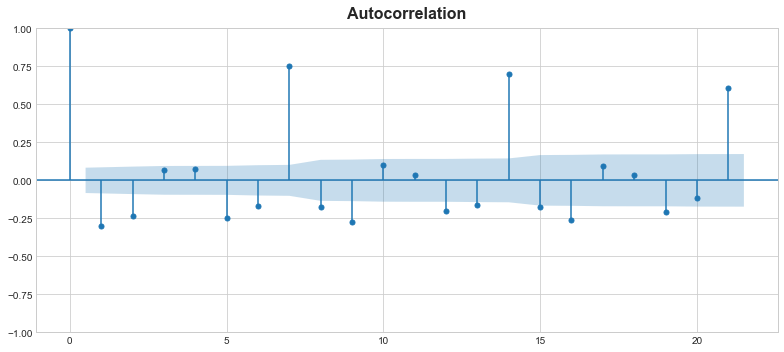

In [21]:
# use auto-correlation function (ACF) and partial ACF to estimate the orders of the AR and MA components in the SARIMAX model
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
fig = plot_acf(us_case_log_diff, lags=21, ax=ax)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Coefficient', fontsize=16)
ax.set_ylim([-1.05,1.05])
plt.show()

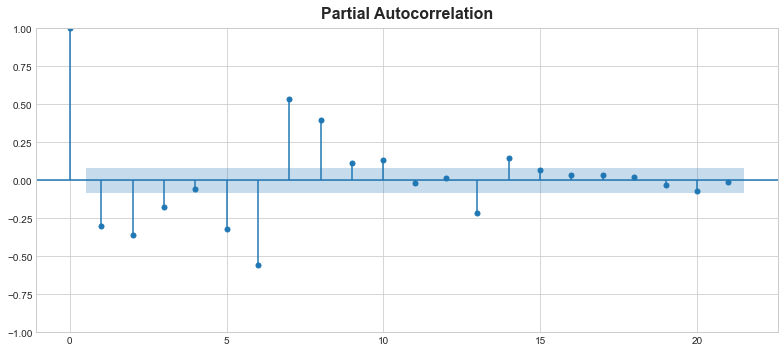

In [22]:
plot_pacf(us_case_log_diff, lags=21)
plt.show()

There is a clear seasonality with period=7 observed reflecting the weekly fluctuations, suggesting that SARIMA would be the better model than ARIMA. 

Try grid searching to estimate parameters for SARIMA

In [383]:
# use pmdarima for an automatic specification of SARIMAX parameters
auto_model = pm.auto_arima(us_case_log,
                      seasonal=True, m=7,
                      d=1, D=1, 
                      start_p=0, start_q=0,
                      max_p=2, max_q=2,
                      max_P=2, max_Q=2,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-305.217, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-146.841, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-463.271, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-490.426, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-365.070, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-488.654, Time=0.38 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-488.627, Time=0.46 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-467.576, Time=0.23 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-486.765, Time=1.56 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-303.621, Time=0.13 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-507.073, Time=0.33 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=-381.182, Time=0.12 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-505.227, Time=0.66 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-505.221, Time=0.59 sec
 ARIMA(1,1,1)(1,1,0)[7]          

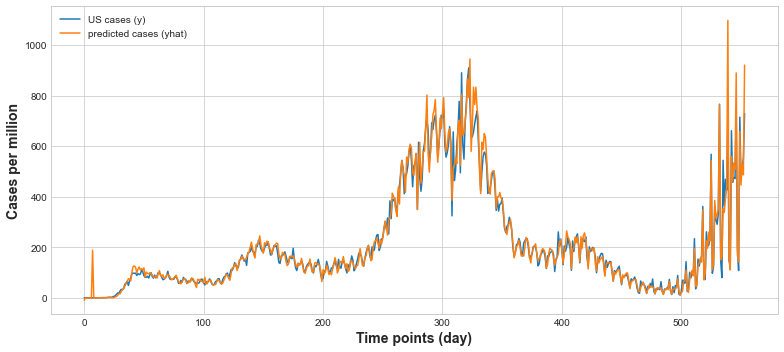

In [425]:
# Create a SARIMAX model
model = SARIMAX(us_case_log, order=auto_model.order, seasonal_order=auto_model.seasonal_order, \
                exog = train_X_us[:,1:len(feature_name_list)-1])
# Fit the model
model_fit = model.fit()
log_yhat = model_fit.predict()
# reverse the log transform and addition of constant
yhat = np.exp(log_yhat)-10

plt.plot(us_case, label='US cases (y)')
plt.plot(yhat, label='predicted cases (yhat)')
plt.legend()
plt.xlabel('Time points (day)')
plt.ylabel('Cases per million')
plt.show()

The above plot shows that the SARIMAX fits the actual case data pretty well. 

In [426]:
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  554
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 7)   Log Likelihood                 320.718
Date:                             Wed, 17 Nov 2021   AIC                           -597.435
Time:                                     15:25:16   BIC                           -502.778
Sample:                                          0   HQIC                          -560.433
                                             - 554                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -32.8411     10.228     -3.211      0.001     -52.888     -12.794
x2            -2.7350      

The model summary shows that autoregressive (AR) and moving average (MA) components of the model appeared to be highly significant as expected. As well some of the exogenous variables like 'vaccination', 'mobility in workplace', and temporal categorical (year, month, dayofm) were significant features for the model. Now let's go ahead and try forecasting with SARIMAX model for all countries. 

## 1.6 SARIMAX model <a id='1.6'></a>

#### 1.6.1 Organize and evaluate model performance: train set <a id='1.6.1'></a>

In [23]:
def country_train_data_sum(country_dict, n_steps_out):
    y_pred_fold = np.empty((len(country_dict['train_idx_country_fold'][0]), n_steps_out, len(country_dict['train_preds_fold'])))
    y_pred_fold[:] = np.NaN
        
    for i, idx in enumerate(country_dict['train_idx_country_fold']):
        y_pred_fold[idx,:,i] = country_dict['train_preds_fold'][i]
    country_dict['train_y_pred'] = np.nanmean(y_pred_fold, axis=2)
    train_set_idx = np.isnan(country_dict['train_y_pred']).sum(axis=1)==0
    country_dict['y'] = train_y[train_set_idx,:] # back to the original unit (cases per million)
    country_dict['y_pred'] = country_dict['train_y_pred'][train_set_idx,:] 
    country_dict['rmse'] = rmse_y_y_pred_country(country_dict, n_steps_out)
    country_dict['X'] = train_X[train_set_idx,:] 
    country_dict['timestamp'] = [train_timestamp[i] for i, logic in enumerate(train_set_idx) if logic ==True]
    return country_dict 

#### 1.6.2 Organize and evaluate model performance: validation set <a id='1.6.2'></a>

In [24]:
def country_validation_data_sum(country_dict, n_steps_out):
    y_pred_fold = np.empty((len(country_dict['val_idx_country_fold'][0]), n_steps_out, len(country_dict['val_preds_fold'])))
    y_pred_fold[:] = np.NaN
        
    for i, idx in enumerate(country_dict['val_idx_country_fold']):
        y_pred_fold[idx,:,i] = country_dict['val_preds_fold'][i]
    country_dict['val_y_pred'] = np.nanmean(y_pred_fold, axis=2)
    val_set_idx = np.isnan(country_dict['val_y_pred']).sum(axis=1)==0
    country_dict['y'] = train_y[val_set_idx,:] # back to the original unit (cases per million)
    country_dict['y_pred'] = country_dict['val_y_pred'][val_set_idx,:] 
    country_dict['rmse'] = rmse_y_y_pred_country(country_dict, n_steps_out)
    country_dict['X'] = train_X[val_set_idx,:] 
    country_dict['timestamp'] = [train_timestamp[i] for i, logic in enumerate(val_set_idx) if logic ==True]
    return country_dict 

#### 1.6.3 Organize and evaluate model performance: test set <a id='1.6.3'></a>

In [25]:
def country_test_data_sum(country_dict, n_steps_out):
    y_pred_fold = np.empty((len(country_dict['test_idx_country_fold'][0]), n_steps_out, len(country_dict['test_preds_fold'])))
    y_pred_fold[:] = np.NaN
        
    for i, idx in enumerate(country_dict['test_idx_country_fold']):
        y_pred_fold[idx,:,i] = country_dict['test_preds_fold'][i]
    country_dict['test_y_pred'] = np.nanmean(y_pred_fold, axis=2)
    test_set_idx = np.isnan(country_dict['test_y_pred']).sum(axis=1)==0
    country_dict['y'] = test_y[test_set_idx,:] # back to the original unit (cases per million)
    country_dict['y_pred'] = country_dict['test_y_pred'][test_set_idx,:] 
    country_dict['rmse'] = rmse_y_y_pred_country(country_dict, n_steps_out)
    country_dict['X'] = test_X[test_set_idx,:] 
    country_dict['timestamp'] = [test_timestamp[i] for i, logic in enumerate(test_set_idx) if logic ==True]
    return country_dict 

#### 1.6.4 Train and test the SARIMAX model <a id='1.6.4'></a>

In [26]:
def SARIMAX_grid_search(timeseries, exogenous, seasonal_diff=7):
    # use pmdarima for an automatic specification of SARIMAX parameters
    auto_model = pm.auto_arima(timeseries,
                             seasonal=True, m=seasonal_diff,
                             d=1, D=1, 
                             start_p=0, start_q=0,
                             max_p=2, max_q=2,
                             max_P=2, max_Q=2,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True) # m is the period for seasonal differencing
    # Create a SARIMAX model
    model = SARIMAX(timeseries, order=auto_model.order, seasonal_order=auto_model.seasonal_order, \
                    exog = exogenous)
    # Fit the model
    model_fit = model.fit()
    return model_fit 

In [27]:
def prepare_exog(train_end_timestamp, entire_timestamp, country_idx, X, steps):
    ts_steps_out = [train_end_timestamp+timedelta(days=i+1) for i in range(steps)]
    ts_steps_out_idx = [ts in ts_steps_out for ts in entire_timestamp]
    X_steps_out = X[np.array(ts_steps_out_idx) & np.array(country_idx),:]
    return X_steps_out

In [28]:
def sarimax_output_organize(timeseries, len_timeseries, n_steps_out): 
    output_array = np.empty((len_timeseries, n_steps_out))
    for i in range(n_steps_out):
        output_array[:,n_steps_out-1-i] = timeseries[np.arange(-len_timeseries-i,-i)]
    return output_array

In [29]:
# get the walk-forward validation folds for train and validation sets  
train_folds = []
validation_folds = []
# get the timestamps for train and validation folds
sorted_train_timestamp = sorted((set(train_timestamp))) # unique timestamps in the train set
tscv = TimeSeriesSplit(n_splits=5, test_size=n_test) # split train and validations sets for cross validation
for train_idx, validation_idx in tscv.split(sorted_train_timestamp): # get train and validation sets
    # print("TRAIN:", train_idx, "VALIDATION:", validation_idx)
    train_folds.append([sorted_train_timestamp[i] for i in train_idx]) # folds in train set
    validation_folds.append([sorted_train_timestamp[i] for i in validation_idx]) # folds in validation set

train_preds = []
val_preds = []
test_preds = []

train_preds = []
val_preds = []
test_preds = []

country_list = list(set(train_country))
country_list.sort()

rez_country_srm_7d_train = {}
rez_country_srm_7d_val = {}
rez_country_srm_7d_test = {}

all_timestamps = train_timestamp+test_timestamp+test_te_timestamp # entire timestamps

# train and test the model with cross validation
for country in country_list:
    rez_country_srm_7d_train[country] = {}
    rez_country_srm_7d_val[country] = {}
    rez_country_srm_7d_test[country] = {}
    
    # train & validation sets
    country_idx = list(map(lambda x: x==country, train_country))  
    # test set (doesn't change across folds)
    country_idx_test = list(map(lambda x: x==country, test_country))
    X_test_country = test_X[country_idx_test,:]
    test_ts = [ts for i, ts in enumerate(test_timestamp) if country_idx_test[i]]
    # test tailend set (doesn't change across folds)
    country_idx_test_te = list(map(lambda x: x==country, test_te_country))
    X_test_te_country = test_te_X[country_idx_test_te,:]
    test_te_ts = [ts for i, ts in enumerate(test_te_timestamp) if country_idx_test_te[i]]
    
    all_country_idx = country_idx+country_idx_test+country_idx_test_te
    
    train_preds_c_f = []
    train_y_c_f = []
    train_idx_c_f = [] 
    
    val_preds_c_f = []
    val_y_c_f = []
    val_idx_c_f = []
    
    test_preds_c_f = []
    test_y_c_f = []
    test_idx_c_f = []
    
    rez_country_srm_7d_train[country] = {}
    rez_country_srm_7d_val[country] = {}
    rez_country_srm_7d_test[country] = {}
    
    for fold in range(len(train_folds)): # iterate cross-validation folds
        fold_idx_train = [ts in train_folds[fold] for ts in train_timestamp]
        fold_idx_val = [ts in validation_folds[fold] for ts in train_timestamp]
    
        train_idx_c_f.append(list(np.array(fold_idx_train) & np.array(country_idx)))
        val_idx_c_f.append(list(np.array(fold_idx_val) & np.array(country_idx)))
        test_idx_c_f.append(country_idx_test)
    
        X_train_c_f, X_val_c_f = train_X[train_idx_c_f[fold],:], train_X[val_idx_c_f[fold],:] # X_train for the current country, fold
        train_y_c_f.append(train_y[train_idx_c_f[fold],:]) # train y for this country and fold  
        val_y_c_f.append(train_y[val_idx_c_f[fold],:]) # validation y for this country and fold
        test_y_c_f.append(test_y[country_idx_test,:])
        
        # prepare exogenous variables to be used for SARIMAX forecasting
        train_ts_c_f = [train_timestamp[i] for i in range(len(train_timestamp)) if train_idx_c_f[fold][i]] # timestamps of the current folder, country
        train_end = train_ts_c_f[-1] # the latest timepoint of the training set
        
        train_exog_steps_out = timedelta(days=n_steps_out).days
        train_exog = prepare_exog(train_end, train_timestamp, country_idx, train_X, train_exog_steps_out) # exogenous variables over days
        
        val_ts_c_f = [train_timestamp[i] for i in range(len(train_timestamp)) if val_idx_c_f[fold][i]] # timestamps of the current folder, country
        val_exog_steps_out = (val_ts_c_f[-1]+timedelta(days=n_steps_out)-train_end).days #USE CAUTION HERE! timedelta(days=n_steps_out+n_test-1).days
        val_exog = prepare_exog(train_end, all_timestamps, all_country_idx, all_X, val_exog_steps_out) # exogenous variables over days
        
        test_exog_steps_out = (test_ts[-1]+timedelta(days=n_steps_out)-train_end).days
        test_exog = prepare_exog(train_end, all_timestamps, all_country_idx, all_X, test_exog_steps_out) 
          
        y_train_pred_c_f = np.empty((train_y_c_f[fold].shape[0], n_steps_out)) 
        y_val_pred_c_f = np.empty((val_y_c_f[fold].shape[0], n_steps_out))
        y_test_pred_c_f = np.empty((X_test_country.shape[0], n_steps_out)) 
        
        # SARIMAX model fit 
        x_log_train = np.log(X_train_c_f[:,-1]+10) # add a constant and log transform the case_per_mil
        x_exog_train = X_train_c_f[:,1:len(feature_name_list)-1] # exogenous variables for model fitting
        x_exog_train_predict = train_exog[:,1:len(feature_name_list)-1] # exogenous variables for forecasting the training set
        x_exog_val_predict = val_exog[:,1:len(feature_name_list)-1] # exogenous variables for forecasting the validation set
        x_exog_test_predict = test_exog[:,1:len(feature_name_list)-1] # # exogenous variables for forecasting the test set      
        # grid search SARIMAX parameters
        sarimax_model = SARIMAX_grid_search(x_log_train, x_exog_train, seasonal_diff=7)
        # predict train data and inverse transform
        model_y_train = np.exp(sarimax_model.predict())-10
        # forecast train data
        train_y_forecast = np.exp(sarimax_model.forecast(train_exog_steps_out, exog=x_exog_train_predict))-10
        model_train_y_forecast = np.concatenate((model_y_train, train_y_forecast), axis=0)
        y_train_pred_c_f = sarimax_output_organize(model_train_y_forecast, train_y_c_f[fold].shape[0], 7)
        # forecast validation data
        val_y_forecast = np.exp(sarimax_model.forecast(val_exog_steps_out, exog=x_exog_val_predict))-10
        y_val_pred_c_f = sarimax_output_organize(val_y_forecast, val_y_c_f[fold].shape[0], 7)
        # forecast test data
        test_y_forecast = np.exp(sarimax_model.forecast(test_exog_steps_out, exog=x_exog_test_predict))-10
        y_test_pred_c_f = sarimax_output_organize(test_y_forecast, test_y_c_f[fold].shape[0], 7)
    
        train_preds_c_f.append(y_train_pred_c_f)     
        val_preds_c_f.append(y_val_pred_c_f)
        test_preds_c_f.append(y_test_pred_c_f)
        
        if fold==len(train_folds)-1: 
            rez_country_srm_7d_train[country]['model'] = sarimax_model # save the model once per country (last fold, one-step prediction)
            
        print('Completed fold #{0:d} of country {1:s}'.format(fold+1, country))
        
    # rez dictionary for train
    rez_country_srm_7d_train[country]['train_preds_fold'] = train_preds_c_f
    rez_country_srm_7d_train[country]['train_idx_country_fold'] = train_idx_c_f
    rez_country_srm_7d_train[country]['train_y_fold'] = train_y_c_f
    rez_country_srm_7d_train[country] = country_train_data_sum(rez_country_srm_7d_train[country], n_steps_out) # 'y', 'y_pred', 'rmse', 'X', 'timestamp'
    
    # rez dictionary for validation
    rez_country_srm_7d_val[country]['val_preds_fold'] = val_preds_c_f 
    rez_country_srm_7d_val[country]['val_idx_country_fold'] = val_idx_c_f
    rez_country_srm_7d_val[country]['val_y_fold'] = val_y_c_f
    rez_country_srm_7d_val[country] = country_validation_data_sum(rez_country_srm_7d_val[country], n_steps_out) # 'y', 'y_pred', 'rmse', 'X', 'timestamp'
    
    # rez dictionary for test
    rez_country_srm_7d_test[country]['test_preds_fold'] = test_preds_c_f
    rez_country_srm_7d_test[country]['test_idx_country_fold'] = test_idx_c_f 
    rez_country_srm_7d_test[country]['test_y_fold'] = test_y_c_f
    rez_country_srm_7d_test[country] = country_test_data_sum(rez_country_srm_7d_test[country], n_steps_out) # 'y', 'y_pred', 'rmse', 'X', 'timestamp'

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=99.867, Time=0.27 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=401.844, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=101.721, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-71.170, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=165.156, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-69.494, Time=0.43 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-69.487, Time=0.94 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=46.436, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-67.640, Time=1.10 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=103.828, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-69.966, Time=0.40 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-69.774, Time=0.41 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-30.769, Time=0.22 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-71.812, Time=0.88 sec
 ARIMA(1,1,2)(0,1,0)[7]             : AIC=156.629

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country AR
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=89.367, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=407.499, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=98.963, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-83.977, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=169.345, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-82.420, Time=0.49 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-82.416, Time=0.91 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=43.389, Time=0.22 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-80.542, Time=0.93 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=93.519, Time=0.22 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-82.380, Time=0.51 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-82.286, Time=0.76 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-41.232, Time=0.26 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-84.198, Time=1.22 sec
 ARIMA(1,1,2)(0,1,0

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country AR
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=82.508, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=412.513, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=97.578, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-91.283, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=167.737, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-89.681, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-89.676, Time=0.78 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=39.313, Time=0.22 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-87.991, Time=1.46 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=87.052, Time=0.22 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-89.551, Time=0.59 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-89.490, Time=0.58 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-48.400, Time=0.31 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-91.193, Time=1.26 sec
 ARIMA(0,1,1)(0,1,1

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country AR
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=69.857, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=417.702, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=90.971, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-109.793, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=168.208, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-108.221, Time=0.51 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-108.221, Time=0.77 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=30.796, Time=0.27 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-106.435, Time=0.95 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=74.447, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-107.968, Time=0.54 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-107.928, Time=0.51 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-64.764, Time=0.32 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-109.654, Time=1.41 sec
 ARIMA(0,1,1

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country AR
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=55.790, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=416.012, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=75.731, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-131.972, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=157.700, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-130.442, Time=0.48 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-130.437, Time=0.82 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=13.430, Time=0.27 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-128.716, Time=0.87 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=60.348, Time=0.27 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-130.165, Time=0.62 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-130.121, Time=0.52 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-85.007, Time=0.36 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-131.920, Time=1.48 sec
 ARIMA(0,1,1

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country AR
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-128.795, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=101.712, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-137.895, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-237.514, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-73.423, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-244.145, Time=0.40 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-157.957, Time=0.16 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-244.405, Time=0.81 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-185.315, Time=0.44 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-241.660, Time=1.08 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-244.283, Time=1.45 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=-128.674, Time=0.63 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=-249.614, Time=1.45 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-249.651, Time=0.79 sec
 AR

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country AT
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-142.147, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=101.621, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-153.872, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-257.558, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-82.767, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-262.716, Time=0.55 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-174.829, Time=0.17 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-263.683, Time=0.88 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-203.140, Time=0.39 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-261.694, Time=3.35 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-263.447, Time=1.97 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=-142.561, Time=0.62 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=-269.244, Time=1.24 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-268.640, Time=0.81 sec
 AR

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country AT
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-155.221, Time=0.32 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=101.069, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-166.229, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-275.937, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-89.903, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-280.165, Time=0.51 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-187.993, Time=0.19 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-280.826, Time=0.95 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-219.972, Time=0.36 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-278.928, Time=2.79 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-280.754, Time=1.89 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=-155.212, Time=0.77 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=-286.214, Time=1.47 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-285.880, Time=0.59 sec
 AR

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country AT
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-163.707, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=97.374, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-170.922, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-279.444, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-96.655, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-287.691, Time=0.50 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-191.996, Time=0.18 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.88 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=1.72 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-285.622, Time=0.86 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-222.389, Time=0.41 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=inf, Time=2.79 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-293.161, Time=1.51 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-285.136, Time=0.49 sec
 ARIMA(1,1,1)(1,1,0

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country AT
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-188.789, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=85.637, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-192.379, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-307.302, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-111.535, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-316.225, Time=0.63 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-213.822, Time=0.37 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.28 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=1.99 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-313.910, Time=0.95 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-246.027, Time=0.37 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=inf, Time=3.93 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-321.648, Time=0.88 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-312.943, Time=0.51 sec
 ARIMA(1,1,1)(1,1,

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country AT
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-453.023, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-709.573, Time=0.52 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-580.218, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-765.110, Time=0.59 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=2.08 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-661.099, Time=0.21 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-818.400, Time=0.50 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-767.227, Time=0.39 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=1.98 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.29 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=-818.017, Time=0.90 sec
 ARIMA(1,1,1)(2,1,0)[7]        

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country AU
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-495.731, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-764.931, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.99 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-629.261, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-823.275, Time=0.57 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.45 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-714.288, Time=0.29 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-879.079, Time=0.47 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-825.266, Time=0.41 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=2.37 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.23 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=-878.770, Time=1.03 sec
 ARIMA(1,1,1)(2,1,0)[7]        

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country AU
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-539.433, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-821.172, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.79 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-679.256, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-882.309, Time=0.55 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.61 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.74 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-768.058, Time=0.23 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-940.642, Time=0.54 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-884.143, Time=0.62 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=1.86 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.34 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=-940.374, Time=1.07 sec
 ARIMA(1,1,1)(2,1,0)[7]        

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country AU
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-578.359, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-872.496, Time=0.42 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.05 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-723.202, Time=0.18 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-935.556, Time=0.52 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.73 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-817.762, Time=0.32 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-994.584, Time=0.82 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-936.468, Time=0.45 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=2.37 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.26 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=-994.063, Time=1.05 sec
 ARIMA(1,1,1)(2,1,0)[7]        

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country AU
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-616.949, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-918.985, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.97 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-763.409, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-986.460, Time=0.56 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=2.46 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-865.554, Time=0.41 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-1046.698, Time=0.81 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-984.321, Time=0.55 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=2.34 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.26 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=-1046.569, Time=1.19 sec
 ARIMA(1,1,1)(2,1,0)[7]      

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country AU
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=599.825, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=827.321, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=624.239, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=426.202, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=605.714, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=422.565, Time=0.42 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=528.882, Time=0.16 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=424.553, Time=0.92 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=424.551, Time=1.37 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=422.587, Time=0.81 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=492.463, Time=0.27 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=426.555, Time=0.73 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=423.193, Time=0.56 sec
 ARIMA(0,1,2)(1,1,1)[7]             : AIC=422.612, Time=0.43 sec
 ARIMA(1,1,0)(1

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country BE
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=611.858, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=852.581, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=641.518, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=431.853, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=624.330, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=428.459, Time=0.39 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=541.765, Time=0.16 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=430.438, Time=0.80 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=430.436, Time=1.25 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=428.452, Time=0.94 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=611.661, Time=0.55 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=429.420, Time=1.26 sec
 ARIMA(0,1,2)(0,1,2)[7]             : AIC=429.011, Time=1.28 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=506.518, Time=0.71 sec
 ARIMA(1,1,2)(0

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country BE
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=656.647, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=896.058, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=674.886, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=466.389, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=669.400, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=462.908, Time=0.45 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=579.420, Time=0.19 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=464.897, Time=0.82 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=464.897, Time=1.78 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=462.936, Time=0.96 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=539.896, Time=0.38 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=466.898, Time=0.91 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=463.469, Time=0.55 sec
 ARIMA(0,1,2)(1,1,1)[7]             : AIC=462.986, Time=0.68 sec
 ARIMA(1,1,0)(1

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country BE
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=816.954, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=985.545, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=786.931, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=620.294, Time=0.22 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=730.235, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=607.292, Time=0.49 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=658.724, Time=0.14 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=606.499, Time=0.89 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=641.229, Time=0.27 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=608.284, Time=1.55 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=606.990, Time=0.99 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=818.797, Time=0.60 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=608.478, Time=1.27 sec
 ARIMA(0,1,2)(2,1,1)[7]             : AIC=608.469, Time=1.51 sec
 ARIMA(1,1,0)(2

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country BE
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=1048.920, Time=0.19 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1260.599, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=933.680, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=768.988, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=917.790, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=770.120, Time=0.36 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=770.141, Time=0.44 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=826.155, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=769.110, Time=1.10 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=1046.928, Time=0.25 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=763.640, Time=0.28 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=912.623, Time=0.23 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=764.835, Time=0.42 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=764.861, Time=0.47 sec
 ARIMA(1,1,1

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country BE
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-32.224, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=228.105, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-38.152, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-235.367, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-47.459, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-233.967, Time=1.00 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-233.891, Time=0.86 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-147.156, Time=0.19 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-234.691, Time=1.73 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-32.925, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-242.252, Time=0.52 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=-54.039, Time=0.17 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-241.221, Time=0.72 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-241.085, Time=1.03 sec
 ARIMA(

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country CA
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-8.683, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=273.722, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-28.181, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-221.241, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-25.607, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-219.666, Time=0.50 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-219.607, Time=0.84 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-133.681, Time=0.28 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-219.935, Time=1.51 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-9.292, Time=0.28 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-231.476, Time=0.57 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=-36.162, Time=0.27 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-230.171, Time=0.71 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-230.072, Time=1.02 sec
 ARIMA(1,

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country CA
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-27.349, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=266.069, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-44.324, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-248.990, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-46.303, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-247.295, Time=0.46 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-247.264, Time=0.83 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-155.193, Time=0.29 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-247.957, Time=1.52 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-28.045, Time=0.24 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-260.092, Time=0.54 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=-57.287, Time=0.17 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-258.679, Time=0.75 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-258.616, Time=1.19 sec
 ARIMA(

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country CA
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-18.938, Time=0.32 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=287.044, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-39.754, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-254.405, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-40.858, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-253.016, Time=0.58 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-252.931, Time=0.80 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-156.083, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-252.798, Time=1.79 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-19.731, Time=0.24 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-266.468, Time=0.56 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=-52.310, Time=0.18 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-265.486, Time=0.77 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-265.333, Time=0.90 sec
 ARIMA(

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country CA
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=42.227, Time=0.32 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=337.658, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-0.962, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-200.702, Time=0.45 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-10.490, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-200.975, Time=0.68 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-115.072, Time=0.24 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.14 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-199.961, Time=1.30 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-200.388, Time=0.93 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-166.018, Time=0.50 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-198.162, Time=2.08 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-215.521, Time=0.92 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-214.550, Time=0.55 sec
 ARIMA(1,1,1

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country CA
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=677.612, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=894.134, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=692.732, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=449.514, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=588.556, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=445.490, Time=0.49 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=545.846, Time=0.18 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=432.014, Time=0.54 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=433.763, Time=0.38 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=425.423, Time=1.07 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=428.289, Time=1.13 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=645.949, Time=0.60 sec
 ARIMA(1,1,1)(2,1,2)[7]             : AIC=423.608, Time=1.22 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=425.786, Time=1.34 sec
 ARIMA(1,1,1)(2

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country DE
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=707.383, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=955.721, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=739.731, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=479.346, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=638.535, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=473.378, Time=0.43 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=582.724, Time=0.19 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=468.514, Time=0.50 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=470.041, Time=0.30 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=459.993, Time=1.28 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=459.444, Time=1.17 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=694.968, Time=0.64 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=458.809, Time=1.47 sec
 ARIMA(1,1,1)(0,1,2

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country DE
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=725.118, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=978.868, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=753.858, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=488.419, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=648.417, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=482.026, Time=0.46 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=590.131, Time=0.20 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=471.745, Time=0.49 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=473.025, Time=0.36 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=467.176, Time=1.08 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=467.411, Time=1.08 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=701.158, Time=1.21 sec
 ARIMA(1,1,1)(2,1,2)[7]             : AIC=467.140, Time=1.28 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=466.928, Time=1.32 sec
 ARIMA(1,1,1)(0

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country DE
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=738.550, Time=0.21 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1001.088, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=766.022, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=494.314, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=659.959, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=486.970, Time=0.44 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=599.391, Time=0.22 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=476.640, Time=0.45 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=477.731, Time=0.44 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=471.774, Time=1.12 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=472.238, Time=1.28 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=712.134, Time=0.73 sec
 ARIMA(1,1,1)(2,1,2)[7]             : AIC=471.687, Time=1.27 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=471.860, Time=1.81 sec
 ARIMA(1,1,1)(

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country DE
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=749.236, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1022.373, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=777.106, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=496.552, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=667.242, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=489.507, Time=0.57 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=603.855, Time=0.23 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=476.242, Time=0.61 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=477.226, Time=0.37 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=472.188, Time=1.05 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=474.088, Time=1.27 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=720.672, Time=1.23 sec
 ARIMA(1,1,1)(2,1,2)[7]             : AIC=471.863, Time=1.18 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=473.426, Time=1.75 sec
 ARIMA(1,1,1)(

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country DE
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=660.175, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=887.800, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=631.373, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=444.239, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=649.438, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.41 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=0.89 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=538.783, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=447.700, Time=0.75 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=658.189, Time=0.16 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=443.220, Time=0.39 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=650.757, Time=0.14 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=0.94 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=inf, Time=1.32 sec
 ARIMA(1,1,1)(1,1,0)[7]        

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country DK
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=913.302, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=659.808, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=448.207, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=663.439, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.15 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=1.02 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=559.138, Time=0.21 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.52 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=674.001, Time=0.21 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=446.513, Time=0.50 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=664.509, Time=0.17 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=0.99 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=inf, Time=1.35 sec
 ARIMA(1,1,1)(1,1,0)[7]             : A

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country DK
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=941.732, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=675.185, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=463.331, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=682.582, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=0.84 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=572.384, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.50 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=694.316, Time=0.21 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=460.878, Time=0.51 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=684.269, Time=0.13 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.08 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=inf, Time=0.98 sec
 ARIMA(1,1,1)(1,1,0)[7]             : A

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country DK
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=965.059, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=687.383, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.41 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=832.479, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=641.741, Time=0.29 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.05 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=783.751, Time=0.16 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=581.351, Time=0.40 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=628.804, Time=0.25 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=2.48 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=0.84 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=545.156, Time=0.53 sec
 ARIMA(2,1,1)(1,1,0)[7]             : A

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country DK
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=990.729, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=699.480, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=850.973, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=651.722, Time=0.31 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.24 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=801.751, Time=0.18 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=591.086, Time=0.42 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=640.438, Time=0.22 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=4.80 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=0.73 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=555.887, Time=0.58 sec
 ARIMA(2,1,1)(1,1,0)[7]             : A

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country DK
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=292.842, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=521.447, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=234.345, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=53.728, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=253.242, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=54.305, Time=0.44 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=54.459, Time=0.63 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=150.898, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=55.213, Time=2.02 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=292.389, Time=0.18 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=42.971, Time=0.56 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=254.944, Time=0.14 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=44.675, Time=0.69 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=44.705, Time=1.05 sec
 ARIMA(1,1,1)(1,1,0)[7

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country FI
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=340.872, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=574.878, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=260.270, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=78.181, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=285.061, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=79.594, Time=0.44 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=79.653, Time=0.70 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=179.594, Time=0.21 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=81.055, Time=2.05 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=339.381, Time=0.21 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=62.418, Time=0.63 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=286.219, Time=0.12 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=64.417, Time=0.74 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=64.417, Time=1.03 sec
 ARIMA(1,1,1)(1,1,0)[7

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country FI
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=359.985, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=622.529, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=278.469, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=89.281, Time=0.43 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=312.911, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=90.676, Time=0.62 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=90.742, Time=0.92 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=196.544, Time=0.29 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.70 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=358.523, Time=0.24 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=72.979, Time=0.70 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=313.364, Time=0.14 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=74.974, Time=0.89 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=74.974, Time=1.11 sec
 ARIMA(1,1,1)(1,1,0)[7]  

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country FI
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=395.719, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=666.802, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=303.058, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=115.374, Time=0.45 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=345.037, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=115.098, Time=0.57 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=223.327, Time=0.24 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.04 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.21 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=115.452, Time=1.16 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=185.946, Time=0.45 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=inf, Time=2.97 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=99.000, Time=0.61 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=97.668, Time=0.46 sec
 ARIMA(1,1,1)(0,1,0)[7]      

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country FI
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=397.839, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=676.226, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=300.191, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=109.081, Time=0.45 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=343.614, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=109.152, Time=0.57 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=109.484, Time=0.91 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=216.601, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.30 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=397.318, Time=0.35 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=91.221, Time=0.56 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=343.716, Time=0.17 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=92.664, Time=0.69 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=92.750, Time=1.01 sec
 ARIMA(1,1,1)(1,1,0)[7

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country FI
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=1082.913, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1275.787, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1023.918, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=826.676, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=987.792, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=816.406, Time=0.49 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=913.945, Time=0.18 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=818.056, Time=0.77 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=818.077, Time=1.24 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=817.478, Time=0.90 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=883.289, Time=0.33 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=820.055, Time=2.53 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=809.746, Time=0.53 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=819.902, Time=0.35 sec
 ARIMA(1,1,1

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country FR
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=1135.057, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1336.831, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1068.136, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=862.925, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=1028.913, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=852.818, Time=0.50 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=953.158, Time=0.20 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=854.452, Time=0.81 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=854.460, Time=1.40 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=853.861, Time=0.63 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=921.211, Time=0.35 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=856.446, Time=2.28 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=845.027, Time=0.54 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=855.449, Time=0.37 sec
 ARIMA(1,1,

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country FR
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=1167.415, Time=0.22 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1386.221, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1101.005, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=883.831, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=1061.842, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=872.894, Time=0.44 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=981.235, Time=0.20 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=874.451, Time=0.81 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=874.447, Time=1.27 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=874.053, Time=0.75 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=946.600, Time=0.37 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=876.438, Time=2.73 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=864.439, Time=0.52 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=875.812, Time=0.37 sec
 ARIMA(1,1,

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country FR
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=1204.503, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1431.136, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1132.738, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=912.484, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=1096.173, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=900.193, Time=0.51 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=1010.836, Time=0.20 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=901.519, Time=0.93 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=901.537, Time=1.24 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=901.696, Time=0.72 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=976.382, Time=0.35 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=903.508, Time=2.37 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=890.987, Time=0.57 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=903.934, Time=0.37 sec
 ARIMA(1,1

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country FR
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=1234.572, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1475.020, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1163.559, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=938.466, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=1133.278, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=925.300, Time=0.54 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=1041.233, Time=0.19 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=926.322, Time=0.93 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=926.350, Time=1.42 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=927.091, Time=0.86 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=1005.035, Time=0.36 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=928.934, Time=1.24 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=914.949, Time=0.63 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=928.962, Time=0.37 sec
 ARIMA(1,

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country FR
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-458.761, Time=0.32 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-282.569, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-410.417, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-487.305, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-326.554, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-490.410, Time=0.48 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-424.096, Time=0.21 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-492.360, Time=1.31 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-439.535, Time=0.35 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-491.365, Time=2.24 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=1.86 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=-458.041, Time=0.69 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=inf, Time=1.99 sec
 ARIMA(0,1,2)(2,1,1)[7]             : AIC=inf, Time=1.60 sec
 ARIMA(1,1,0)(2,

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country GB
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-492.757, Time=0.31 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-310.831, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-444.089, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-519.378, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-357.052, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-524.193, Time=0.60 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-458.097, Time=0.22 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.30 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.34 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-522.328, Time=0.76 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-472.830, Time=0.36 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-526.829, Time=2.29 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=-492.834, Time=1.89 sec
 ARIMA(1,1,1)(2,1,2)[7]             : AIC=-528.876, Time=3.18 sec
 ARIMA(1,1,

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country GB
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-529.643, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-338.977, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-479.184, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-556.777, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-386.498, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-561.223, Time=0.58 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-493.389, Time=0.23 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.22 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.11 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-559.335, Time=0.73 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-508.675, Time=0.29 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-565.112, Time=1.82 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=-530.725, Time=2.05 sec
 ARIMA(1,1,1)(2,1,2)[7]             : AIC=inf, Time=3.22 sec
 ARIMA(0,1,2)(2,

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country GB
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-560.681, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-359.597, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-508.854, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-591.527, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-412.708, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-596.231, Time=0.49 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-523.246, Time=0.23 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.53 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.10 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-594.454, Time=0.94 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-540.231, Time=0.40 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-599.312, Time=2.44 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=-561.122, Time=1.99 sec
 ARIMA(1,1,1)(2,1,2)[7]             : AIC=-600.221, Time=3.05 sec
 ARIMA(1,1,

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country GB
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-587.923, Time=0.40 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-378.835, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-530.238, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-612.923, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-425.492, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-619.879, Time=0.50 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-541.015, Time=0.22 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.63 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.21 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-617.254, Time=0.98 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-558.667, Time=0.42 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=inf, Time=2.55 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-620.324, Time=0.81 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-612.260, Time=0.61 sec
 ARIMA(1,1,1)(1,

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country GB
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-950.080, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-726.311, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-923.473, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1048.220, Time=0.62 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-842.118, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1046.314, Time=0.65 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1046.301, Time=1.02 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-959.067, Time=0.24 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-1046.284, Time=1.63 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-952.008, Time=0.22 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1046.995, Time=0.66 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-1047.164, Time=0.81 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-1014.766, Time=0.42 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-1045.426, Time=1.

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country ID
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-989.642, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-742.958, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-937.267, Time=0.53 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1072.391, Time=0.56 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-828.298, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1070.431, Time=0.65 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1070.428, Time=1.18 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-963.814, Time=0.25 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-1070.331, Time=2.02 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-991.642, Time=0.36 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1074.271, Time=0.89 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=-849.798, Time=0.28 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-1072.296, Time=0.93 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-1072.293, Time=1.3

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country ID
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-1022.540, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-766.100, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-976.611, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1099.528, Time=0.45 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-857.993, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1097.529, Time=0.74 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1097.529, Time=0.88 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-1002.600, Time=0.28 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-1098.905, Time=1.83 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-1024.538, Time=0.26 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1098.769, Time=0.90 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-1098.990, Time=0.73 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-1077.195, Time=0.41 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-1097.130, Time

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country ID
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-1075.414, Time=0.42 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-811.142, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1021.250, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1146.273, Time=0.42 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-904.928, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1144.289, Time=0.62 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1144.287, Time=1.04 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-1047.130, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-1145.778, Time=2.23 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-1077.360, Time=0.27 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1145.463, Time=0.45 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-1145.643, Time=0.69 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-1126.990, Time=0.89 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-1143.750, Tim

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country ID
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-806.503, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1009.102, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1101.511, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-881.195, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1100.434, Time=0.61 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1100.078, Time=0.84 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-1027.800, Time=0.22 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-1099.613, Time=1.76 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-1037.112, Time=0.26 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1101.261, Time=0.70 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-1101.490, Time=0.64 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-1084.380, Time=0.47 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-1099.579, Time=1.47

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country ID
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=443.553, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=240.946, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=109.181, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=308.014, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.27 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=2.27 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=203.417, Time=0.19 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.40 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=223.296, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=107.886, Time=0.65 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=309.614, Time=0.11 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.33 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=inf, Time=2.14 sec
 ARIMA(1,1,1)(1,1,0)[7]             : A

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country IE
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=449.327, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=233.148, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=95.217, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=305.433, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.35 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=1.59 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=194.107, Time=0.19 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.57 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=215.538, Time=0.21 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=93.663, Time=0.57 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=306.916, Time=0.11 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.28 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=inf, Time=2.10 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country IE
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=463.940, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=236.864, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=90.315, Time=0.42 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=310.803, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.05 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=1.09 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=194.808, Time=0.22 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.38 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=218.039, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=88.655, Time=0.83 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=312.241, Time=0.22 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.21 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=inf, Time=1.51 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country IE
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=487.632, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=240.528, Time=0.36 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=88.344, Time=0.64 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=323.378, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.08 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=1.09 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=196.054, Time=0.22 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.69 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=221.938, Time=0.26 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=86.249, Time=0.69 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=324.489, Time=0.12 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.12 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=inf, Time=1.74 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country IE
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=489.876, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=235.137, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=375.147, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=180.214, Time=0.38 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=2.87 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=284.928, Time=0.19 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=135.800, Time=0.64 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=184.989, Time=0.30 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=2.62 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=0.98 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=136.440, Time=0.59 sec
 ARIMA(1,1,1)(2,1,0)[7]             : A

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country IE
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=788.757, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=568.264, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=391.596, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=549.097, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=0.52 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=380.492, Time=0.82 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=379.996, Time=1.01 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=379.550, Time=1.23 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,1)(2,1,2)[7]             : AIC=377.965, Time=1.71 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=378.310, Time=1.37 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=380.505, Time=1.30 sec
 ARIMA(1,1,1)(1,1,1)[7]        

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country IL
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=807.708, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=577.512, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=399.277, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=556.786, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=491.779, Time=0.19 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=384.395, Time=1.07 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=inf, Time=1.09 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=inf, Time=0.74 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=383.121, Time=1.74 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=382.982, Time=1.12 sec
 ARIMA(1,1,1)(0,1,1)[7]             : A

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country IL
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=826.057, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=586.473, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=408.124, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=569.120, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=0.68 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=500.227, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=394.289, Time=1.30 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=inf, Time=1.57 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.03 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=inf, Time=1.14 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=393.148, Time=1.58 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=i

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country IL
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=858.776, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=609.278, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=425.979, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=589.214, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=0.85 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=518.159, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=413.253, Time=1.22 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=inf, Time=1.79 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.96 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=inf, Time=1.23 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=411.451, Time=1.76 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=410.857, Time=1.05 sec
 ARIMA(1,1,1)(0,1,1)[7]             : A

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country IL
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=887.545, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=621.625, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=428.003, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=605.498, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=417.120, Time=0.90 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=417.351, Time=1.20 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=inf, Time=0.78 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=414.606, Time=1.05 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=425.743, Time=0.44 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=414.901, Time=1.54 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=0.89 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=485.462, Time=0.79 sec
 ARIMA(2,1,1)(0,1,2)[7]        

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country IL
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-552.685, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-135.604, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-522.236, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-682.402, Time=0.79 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-447.525, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-694.178, Time=0.54 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-592.017, Time=0.20 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-693.041, Time=0.63 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-692.866, Time=1.33 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-694.834, Time=1.01 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=-561.854, Time=0.58 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-710.502, Time=1.11 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-702.879, Time=0.54 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=-708.524, Time=1.74 sec
 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country IN
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-592.999, Time=0.32 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-162.965, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-567.262, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-705.753, Time=0.55 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-482.558, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-711.783, Time=0.71 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-632.325, Time=0.23 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-710.160, Time=1.22 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-709.803, Time=1.29 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-710.802, Time=0.84 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-683.160, Time=0.40 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-707.924, Time=2.23 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-730.677, Time=0.96 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-726.578, Time=0.55 sec
 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country IN
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-637.569, Time=0.45 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-191.293, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-613.971, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-748.918, Time=0.46 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-524.106, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-759.851, Time=0.57 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-680.385, Time=0.26 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-758.816, Time=0.65 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-758.362, Time=0.87 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-760.118, Time=0.95 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=-641.356, Time=1.22 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-780.622, Time=1.61 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-772.849, Time=0.54 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=-778.789, Time=1.83 sec
 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country IN
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-685.572, Time=0.49 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-220.973, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-661.157, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=-455.006, Time=0.15 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=-688.540, Time=0.76 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-565.826, Time=0.51 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=-686.573, Time=2.52 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=-687.472, Time=1.54 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=-811.356, Time=2.03 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=-813.199, Time=0.53 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-801.365, Time=0.32 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=-811.286, Time=1.79 sec
 ARIMA(1,1,

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country IN
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-425.855, Time=0.40 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-18.105, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-459.068, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-622.391, Time=0.77 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-389.181, Time=0.22 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.72 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-625.548, Time=1.55 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-622.837, Time=2.61 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=-427.899, Time=0.52 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-649.615, Time=1.23 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-648.467, Time=0.62 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=-647.696, Time=2.62 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-649.682, Time=0.84 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=-571.989, Time=0.37 sec
 ARIMA(

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country IN
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-494.009, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-305.836, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-438.934, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-536.044, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-414.835, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-550.191, Time=0.52 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-462.738, Time=0.23 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-548.821, Time=1.05 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-549.193, Time=1.42 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-551.190, Time=1.11 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=-495.572, Time=0.78 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-549.426, Time=1.64 sec
 ARIMA(0,1,2)(0,1,2)[7]             : AIC=-549.476, Time=1.93 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=-543.588, Time=1.07 sec
 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country IT
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-526.158, Time=0.31 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-333.286, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-471.966, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-571.346, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-448.571, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-585.664, Time=0.48 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-497.385, Time=0.23 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-584.215, Time=0.99 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-584.637, Time=1.54 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-586.636, Time=1.11 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=-527.757, Time=0.80 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-584.925, Time=1.43 sec
 ARIMA(0,1,2)(0,1,2)[7]             : AIC=-584.989, Time=1.86 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=-578.730, Time=1.53 sec
 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country IT
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-527.834, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-336.013, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-486.601, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-586.927, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-463.887, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-598.006, Time=0.66 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-514.348, Time=0.23 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-596.651, Time=1.14 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-597.702, Time=1.35 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-599.434, Time=1.19 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=-529.469, Time=0.81 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-597.846, Time=1.83 sec
 ARIMA(0,1,2)(0,1,2)[7]             : AIC=-597.927, Time=1.64 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=-589.456, Time=1.70 sec
 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country IT
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-558.552, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-337.617, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-499.038, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-606.144, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-471.051, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-622.216, Time=0.65 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-525.648, Time=0.22 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-620.453, Time=1.27 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-621.275, Time=1.52 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-623.221, Time=1.65 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=-560.226, Time=0.82 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-621.671, Time=1.49 sec
 ARIMA(0,1,2)(0,1,2)[7]             : AIC=-621.758, Time=2.70 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=-615.751, Time=1.16 sec
 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country IT
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-596.920, Time=0.32 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-368.964, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-535.353, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-643.053, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-503.382, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-660.880, Time=0.84 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-560.378, Time=0.33 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-658.918, Time=1.12 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-659.282, Time=1.66 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-661.282, Time=2.00 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=-598.512, Time=0.98 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-659.866, Time=1.76 sec
 ARIMA(0,1,2)(0,1,2)[7]             : AIC=-659.982, Time=2.13 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=-654.686, Time=1.28 sec
 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country IT
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-828.431, Time=0.31 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-611.747, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-791.236, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-888.226, Time=0.40 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-725.913, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-894.490, Time=0.61 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-803.109, Time=0.23 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-892.491, Time=1.25 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-892.495, Time=1.68 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-894.462, Time=1.15 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-847.063, Time=0.50 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-890.492, Time=1.21 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-892.620, Time=1.19 sec
 ARIMA(0,1,2)(1,1,1)[7]             : AIC=-892.564, Time=0.79 sec
 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country JP
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-883.652, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-658.261, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-834.109, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-937.947, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-764.591, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-945.695, Time=0.46 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-841.169, Time=0.25 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-943.786, Time=1.35 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-943.852, Time=1.59 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-945.846, Time=1.08 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=-884.016, Time=0.79 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-943.922, Time=1.84 sec
 ARIMA(0,1,2)(0,1,2)[7]             : AIC=-943.888, Time=1.69 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=-942.348, Time=1.17 sec
 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country JP
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-939.891, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-706.299, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-889.007, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-996.143, Time=0.49 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-816.543, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1005.212, Time=0.69 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-895.409, Time=0.44 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-1003.245, Time=2.13 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-1003.276, Time=1.80 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1005.223, Time=1.08 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=-940.295, Time=0.86 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-1003.424, Time=1.54 sec
 ARIMA(0,1,2)(0,1,2)[7]             : AIC=-1003.335, Time=2.11 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=-1002.114, Time=1.0

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country JP
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-996.336, Time=0.36 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-754.995, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-944.738, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1051.300, Time=0.44 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-869.384, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1062.195, Time=1.14 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-950.623, Time=0.27 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-1060.197, Time=1.41 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-1060.198, Time=1.72 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1061.989, Time=1.18 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-996.868, Time=0.67 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-1058.206, Time=1.56 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-1060.641, Time=1.06 sec
 ARIMA(0,1,2)(1,1,1)[7]             : AIC=-1060.440, Time=1.

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country JP
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-1021.342, Time=0.43 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-766.772, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-956.623, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1064.025, Time=0.51 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-864.884, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1072.118, Time=0.78 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-962.733, Time=0.22 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-1070.191, Time=1.08 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-1070.331, Time=2.31 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1071.731, Time=1.33 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-1010.271, Time=0.56 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-1068.388, Time=2.64 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-1070.733, Time=1.54 sec
 ARIMA(0,1,2)(1,1,1)[7]             : AIC=-1070.474, Time=

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country JP
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-1095.089, Time=0.39 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-796.912, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1003.073, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1125.972, Time=0.49 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-867.617, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1124.556, Time=0.70 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1124.560, Time=1.31 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-1005.448, Time=0.33 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-1122.627, Time=1.21 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-1092.720, Time=0.41 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1124.148, Time=1.09 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-1124.305, Time=0.83 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-1122.714, Time=0.50 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-1122.730, Tim

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country KR
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-1158.263, Time=0.39 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-843.040, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1060.021, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1190.015, Time=0.61 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-915.318, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1188.907, Time=0.65 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1188.913, Time=1.23 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-1062.330, Time=0.24 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-1187.787, Time=2.23 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-1155.309, Time=0.28 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1188.250, Time=0.86 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-1188.455, Time=0.67 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-1100.701, Time=0.11 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-1186.705, Tim

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country KR
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-1223.626, Time=0.71 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-897.126, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1121.172, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1256.077, Time=0.56 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-970.699, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1255.100, Time=0.64 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1255.119, Time=2.07 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-1123.330, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-1252.957, Time=1.11 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-1220.363, Time=0.47 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1254.340, Time=1.10 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-1254.562, Time=1.22 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-1253.170, Time=0.36 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-1252.757, Tim

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country KR
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-1283.823, Time=0.39 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-948.463, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1182.017, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1314.764, Time=0.55 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-1021.999, Time=0.16 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1313.658, Time=1.48 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1313.654, Time=1.20 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-1183.867, Time=0.32 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-1312.370, Time=2.34 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-1280.865, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1313.150, Time=1.22 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-1313.522, Time=0.81 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-1312.625, Time=0.36 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-1311.392, Ti

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country KR
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-1347.488, Time=0.40 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-999.701, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1244.347, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1380.139, Time=0.52 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-1077.257, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1379.221, Time=0.66 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1379.206, Time=1.03 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-1245.736, Time=0.35 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-1377.407, Time=1.10 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-1343.951, Time=0.34 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1378.615, Time=0.96 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-1379.075, Time=0.69 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=-1378.020, Time=0.39 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-1376.658, Ti

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country KR
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=165.888, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=395.790, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=140.539, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-17.320, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=207.424, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-15.366, Time=0.49 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-15.367, Time=0.85 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=94.090, Time=0.24 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-13.323, Time=0.71 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=163.947, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-15.642, Time=0.53 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-15.546, Time=0.53 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=34.204, Time=0.26 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-15.692, Time=0.94 sec
 ARIMA(0,1,1)(0,1

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country MX
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=165.762, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=403.599, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=137.699, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-24.987, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=206.972, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-23.017, Time=0.72 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-23.017, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=87.264, Time=0.23 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-21.005, Time=0.74 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=163.799, Time=0.19 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-23.429, Time=0.51 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=-23.301, Time=0.56 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=29.759, Time=0.28 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=-23.262, Time=0.93 sec
 ARIMA(0,1,1)(0,1

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country MX
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=237.391, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=462.453, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=173.540, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=11.624, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=231.915, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=13.394, Time=0.55 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=13.406, Time=0.89 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=110.785, Time=0.27 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=15.246, Time=1.17 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=235.456, Time=0.18 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=13.548, Time=0.47 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=13.567, Time=0.59 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=78.799, Time=0.27 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=12.939, Time=1.03 sec
 ARIMA(0,1,1)(0,1,1)[7]

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country MX
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=236.211, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=509.640, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=193.279, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=6.256, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=256.042, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=8.190, Time=0.50 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=8.193, Time=0.58 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=121.246, Time=0.27 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=9.983, Time=1.28 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=234.224, Time=0.25 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=8.059, Time=0.60 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=8.102, Time=0.51 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=75.484, Time=0.26 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=7.371, Time=1.05 sec
 ARIMA(0,1,1)(0,1,1)[7] interc

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country MX
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=414.767, Time=0.27 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=697.900, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=348.011, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=130.013, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=384.676, Time=0.13 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=131.884, Time=0.59 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=131.887, Time=0.75 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=250.143, Time=0.27 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=133.862, Time=2.03 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=412.787, Time=0.28 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=128.551, Time=0.48 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=385.670, Time=0.19 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=130.196, Time=0.69 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=130.201, Time=0.97 sec
 ARIMA(1,1,1)(1

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country MX
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-103.394, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-334.179, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-418.274, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-259.568, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=0.96 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=0.90 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-344.778, Time=0.19 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.17 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-419.989, Time=0.61 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=-264.995, Time=0.10 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.50 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=inf, Time=1.62 sec
 ARIMA(1,1,1)(1,1,0)[7]             

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country NL
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-95.804, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-334.016, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-427.753, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-258.256, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=1.13 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-346.725, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.26 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-429.657, Time=0.50 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=-262.101, Time=0.12 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=inf, Time=1.62 sec
 ARIMA(1,1,1)(1,1,0)[7]             :

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country NL
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-117.000, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-362.699, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-460.581, Time=0.37 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-286.336, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.00 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-463.808, Time=0.88 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.42 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=inf, Time=1.09 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-465.770, Time=1.71 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-462.816, Time=0.75 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=inf, Time=2.65 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-467.857, Time=1.62 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=-381.273, Time=0.32 sec
 ARIMA(1,1,1)(2,1,1)[7]   

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country NL
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-118.132, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-333.638, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-419.209, Time=0.81 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-229.228, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.74 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=1.38 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-325.803, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.67 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.39 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-424.301, Time=0.92 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=-235.587, Time=0.16 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.34 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=inf, Time=2.60 sec
 ARIMA(1,1,1)(1,1,0)[7]             

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country NL
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-127.242, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-322.792, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-233.766, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-374.248, Time=0.56 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.84 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-314.153, Time=0.26 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-372.248, Time=1.09 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=-372.248, Time=0.87 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-363.763, Time=0.45 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=-370.951, Time=1.08 sec
 ARIMA(1,1,0)(2,1,0)[7] intercept   : AIC=-372.418, Time=1.44 sec

Best model:  ARIMA(1

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country NL
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=582.381, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=382.181, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=178.075, Time=0.41 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=402.595, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=179.604, Time=0.58 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=179.636, Time=0.90 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=290.059, Time=0.29 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=181.148, Time=2.29 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=179.182, Time=0.63 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=178.816, Time=0.68 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=251.636, Time=0.32 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=175.853, Time=1.41 sec
 ARIMA(1,1,2)(0,1,0)[7]

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country NO
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=606.781, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=403.831, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=187.412, Time=0.42 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=426.984, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=188.678, Time=0.52 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=188.715, Time=0.78 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=310.006, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.18 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=187.872, Time=0.72 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=187.325, Time=0.58 sec
 ARIMA(0,1,2)(0,1,0)[7]             : AIC=418.255, Time=0.15 sec
 ARIMA(0,1,2)(1,1,1)[7]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,2)(0,1,2)[7]        

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country NO
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=623.952, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=414.572, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=190.739, Time=0.44 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=436.244, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=191.762, Time=0.53 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=191.812, Time=0.80 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=317.417, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.06 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=191.776, Time=0.53 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=191.436, Time=0.60 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=268.663, Time=0.35 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=189.147, Time=1.13 sec
 ARIMA(1,1,2)(0,1,0)[7]    

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country NO
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=655.759, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=434.080, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=189.283, Time=0.45 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=449.024, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=190.066, Time=0.69 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=190.088, Time=0.94 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=329.070, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=192.047, Time=1.72 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=190.624, Time=0.67 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=190.403, Time=0.63 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=272.771, Time=0.33 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=186.913, Time=1.08 sec
 ARIMA(1,1,2)(0,1,0)[7]

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country NO
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=675.155, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=447.156, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=193.226, Time=0.47 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=456.903, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=0.97 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=335.936, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=1.92 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.25 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=194.772, Time=0.68 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=194.596, Time=0.64 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=281.351, Time=0.32 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=188.963, Time=1.04 sec
 ARIMA(1,1,2)(0,1,0)[7]            

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country NO
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-1464.247, Time=0.39 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-1267.802, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1414.267, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1474.038, Time=0.46 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-1331.215, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1481.304, Time=0.88 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-1406.697, Time=0.30 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.53 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=1.88 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1479.308, Time=1.23 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-1437.550, Time=0.67 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-1478.220, Time=1.69 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-1488.377, Time=1.34 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1480.058, Time=1.07 sec

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country RU
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-1515.405, Time=0.52 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-1308.518, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1459.399, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1529.627, Time=0.45 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-1381.584, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1538.776, Time=1.03 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-1453.518, Time=0.33 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.73 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=1.99 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1537.297, Time=1.24 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-1492.911, Time=0.92 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-1534.844, Time=2.30 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-1545.621, Time=1.43 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1535.433, Time=0.74 sec

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country RU
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-1567.865, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-1341.702, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1502.990, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1579.556, Time=0.45 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-1409.676, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1585.003, Time=1.00 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-1498.196, Time=0.30 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.83 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=1.90 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1583.579, Time=1.52 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-1536.990, Time=0.41 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-1581.454, Time=1.94 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-1590.146, Time=2.16 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1583.879, Time=0.94 sec

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country RU
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-1648.657, Time=0.52 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-1410.540, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1574.052, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1659.634, Time=0.47 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-1482.267, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-1668.104, Time=0.95 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-1568.676, Time=0.27 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=1.95 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.26 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1666.553, Time=1.22 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-1611.558, Time=0.73 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-1664.213, Time=1.82 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-1674.190, Time=1.65 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1664.905, Time=0.85 sec

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country RU
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.64 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-1485.479, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-1657.580, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-1742.737, Time=0.48 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-1561.439, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.07 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-1751.895, Time=1.87 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.21 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=-1733.317, Time=0.97 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-1758.412, Time=1.85 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1748.408, Time=0.96 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=inf, Time=2.56 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=2.50 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=-1759.042, Time=1.51 sec
 ARIMA(1,1,0)(0,1

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country RU
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=175.845, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-58.115, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.13 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=91.466, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-87.805, Time=0.47 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.97 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.55 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=7.904, Time=0.22 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-98.975, Time=0.37 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-64.364, Time=0.25 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=3.03 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.19 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=-103.447, Time=0.70 sec
 ARIMA(2,1,1)(1,1,0)[7]             : AIC

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country SG
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=170.328, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-74.465, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=82.075, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-104.255, Time=0.52 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=2.20 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.12 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-3.583, Time=0.27 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-116.439, Time=0.46 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-81.498, Time=0.35 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=3.24 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.89 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=-121.536, Time=0.84 sec
 ARIMA(2,1,1)(1,1,0)[7]             : 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country SG
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=1.02 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=160.846, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-95.896, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.88 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=69.864, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-127.708, Time=0.52 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=2.18 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.13 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-22.539, Time=0.27 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-140.403, Time=0.55 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-103.395, Time=0.39 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=3.81 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.43 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=-145.657, Time=0.87 sec
 ARIMA(2,1,1)(1,1,0)[7]             

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country SG
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=150.194, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-115.700, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=55.316, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-149.322, Time=0.45 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=3.11 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-40.112, Time=0.29 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-161.498, Time=0.49 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-122.619, Time=0.39 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=2.93 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=2.11 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=-166.403, Time=0.75 sec
 ARIMA(2,1,1)(1,1,0)[7]            

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country SG
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=142.596, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-125.253, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.40 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=48.705, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-160.407, Time=0.57 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=2.43 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.39 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=-54.859, Time=0.27 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-169.579, Time=0.46 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=-129.855, Time=0.32 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=3.03 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=1.66 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=-172.339, Time=0.96 sec
 ARIMA(2,1,1)(1,1,0)[7]            

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country SG
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-538.475, Time=0.59 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-370.434, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-565.044, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-624.394, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-492.697, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-632.467, Time=0.60 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-560.116, Time=0.24 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-630.761, Time=1.07 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-631.022, Time=2.02 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-631.429, Time=0.76 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-589.693, Time=0.45 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-628.659, Time=2.29 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-640.337, Time=0.75 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-633.876, Time=0.53 sec
 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #1 of country US
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-493.426, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-339.395, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-539.253, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-591.903, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-473.248, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-598.510, Time=0.56 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-536.431, Time=0.22 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-596.987, Time=1.45 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-597.319, Time=1.94 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-597.457, Time=0.74 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-562.683, Time=0.50 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-594.511, Time=1.17 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-605.786, Time=0.75 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-601.404, Time=0.51 sec
 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #2 of country US
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-447.282, Time=0.30 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-256.828, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-523.604, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-574.313, Time=0.34 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-426.589, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-579.100, Time=0.47 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-510.612, Time=0.28 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=-577.348, Time=1.13 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-577.319, Time=1.50 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-578.458, Time=0.87 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=-539.267, Time=0.43 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=-575.387, Time=2.32 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-595.846, Time=0.59 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-592.289, Time=0.51 sec
 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #3 of country US
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-330.903, Time=0.21 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-157.533, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-449.851, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-487.496, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-347.136, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-485.675, Time=0.51 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-485.668, Time=0.67 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-446.725, Time=0.25 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-487.383, Time=1.39 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-332.345, Time=0.17 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-503.580, Time=0.52 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=-361.854, Time=0.14 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-501.720, Time=0.78 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-501.720, Time=0.88 sec
 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #4 of country US
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-332.103, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-169.595, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-467.371, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-502.998, Time=0.29 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-371.881, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=-501.001, Time=0.44 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=-501.002, Time=0.59 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=-468.927, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=-502.222, Time=1.47 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-332.184, Time=0.14 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-518.802, Time=0.46 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=-388.851, Time=0.15 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-516.802, Time=0.65 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=-516.802, Time=0.92 sec
 

/Users/parkj/opt/anaconda3/envs/pylearn/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Completed fold #5 of country US


## 1.7 Save and plot model performance <a id='1.7'></a>

#### 1.7.1 Save data<a id='1.7.1'></a>

In [30]:
rez_country_srm_7d = {'train':rez_country_srm_7d_train, 'validation':rez_country_srm_7d_val, 'test':rez_country_srm_7d_test}

filePath_pickle = Path('/Users/parkj/Documents/pyDat/dataSet/covid19_country_srm_7d_with_lagging.pickle')
with open(filePath_pickle, 'wb') as f:
     pickle.dump(rez_country_srm_7d, f)

In [45]:
filePath_pickle = Path('/Users/parkj/Documents/pyDat/dataSet/covid19_country_srm_7d_with_lagging.pickle')
with open(filePath_pickle, 'rb') as f:
    rez_country_srm_7d = pickle.load(f)

#### 1.7.2 Plot model performance <a id='1.7.2'></a>

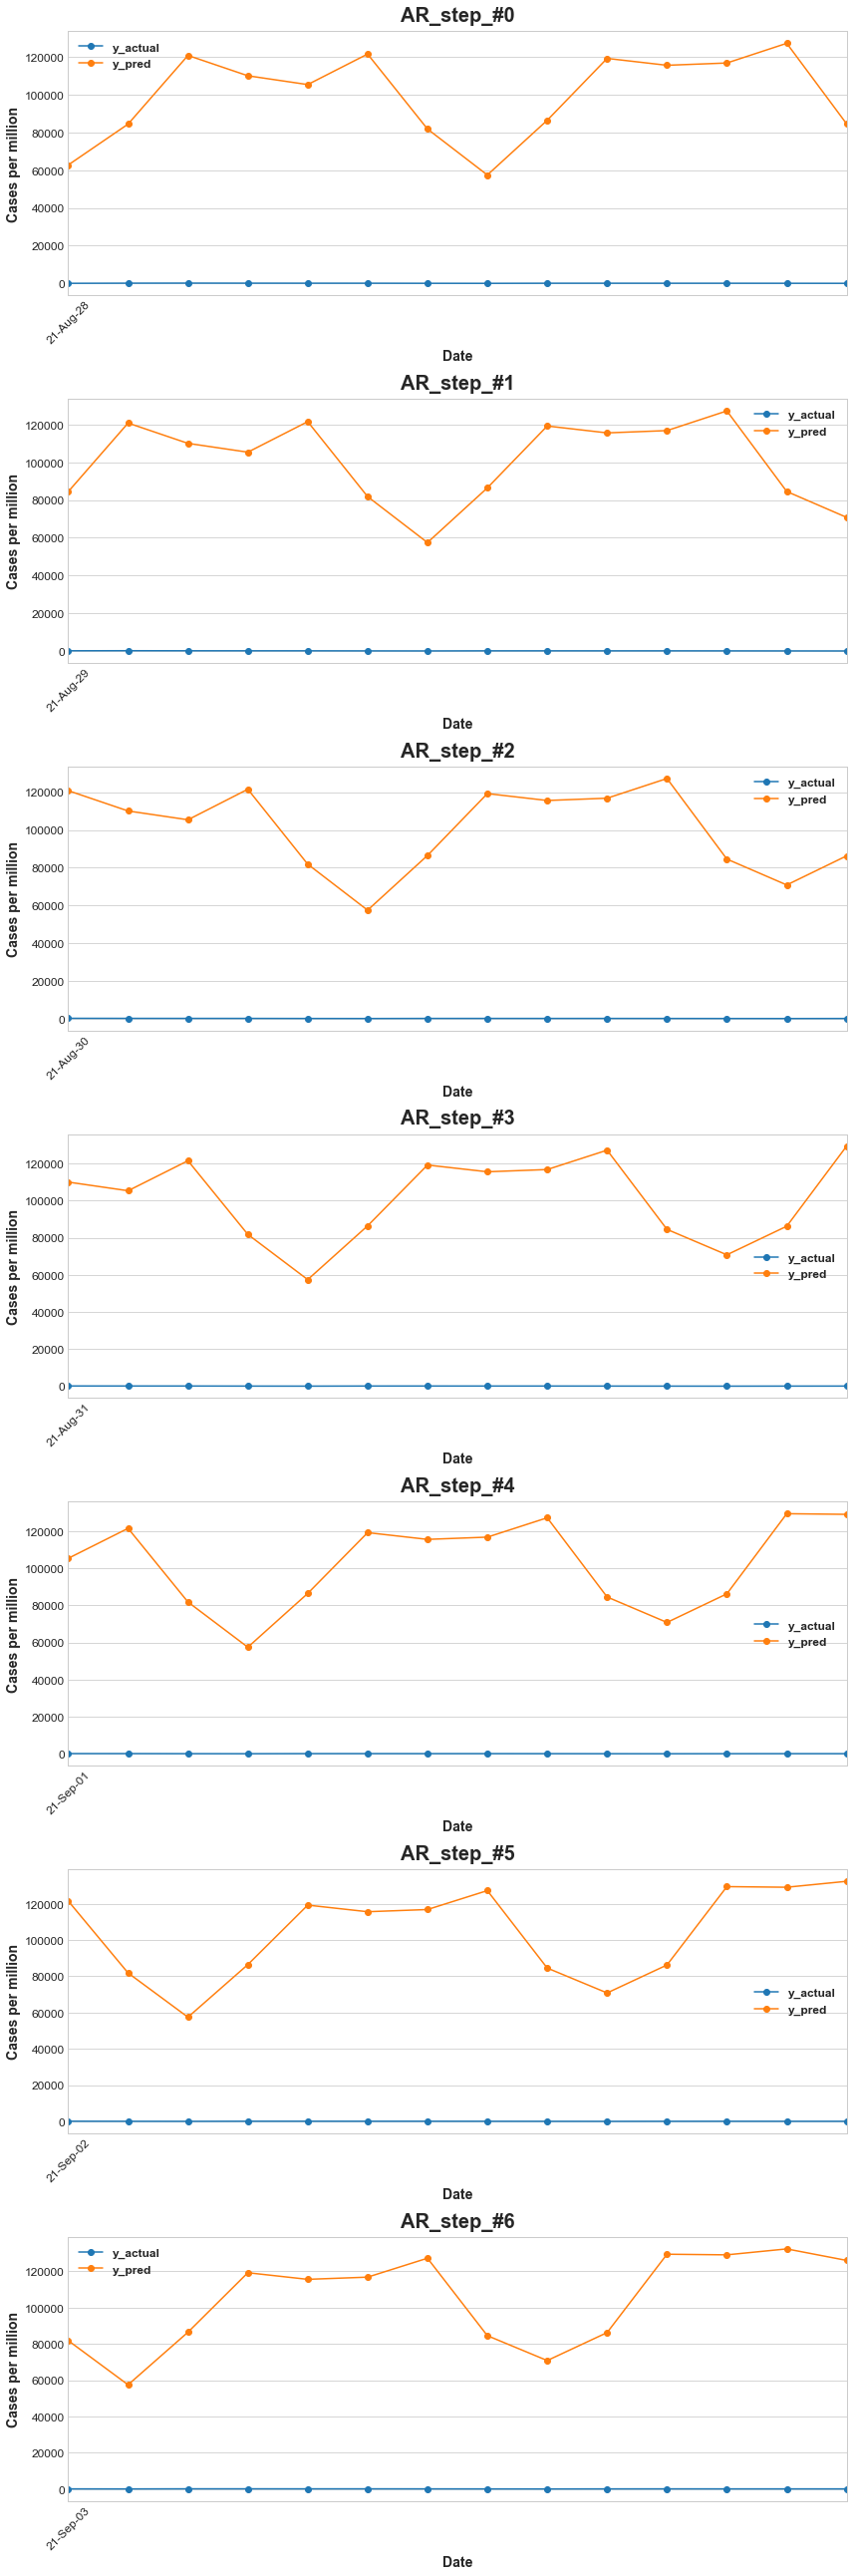

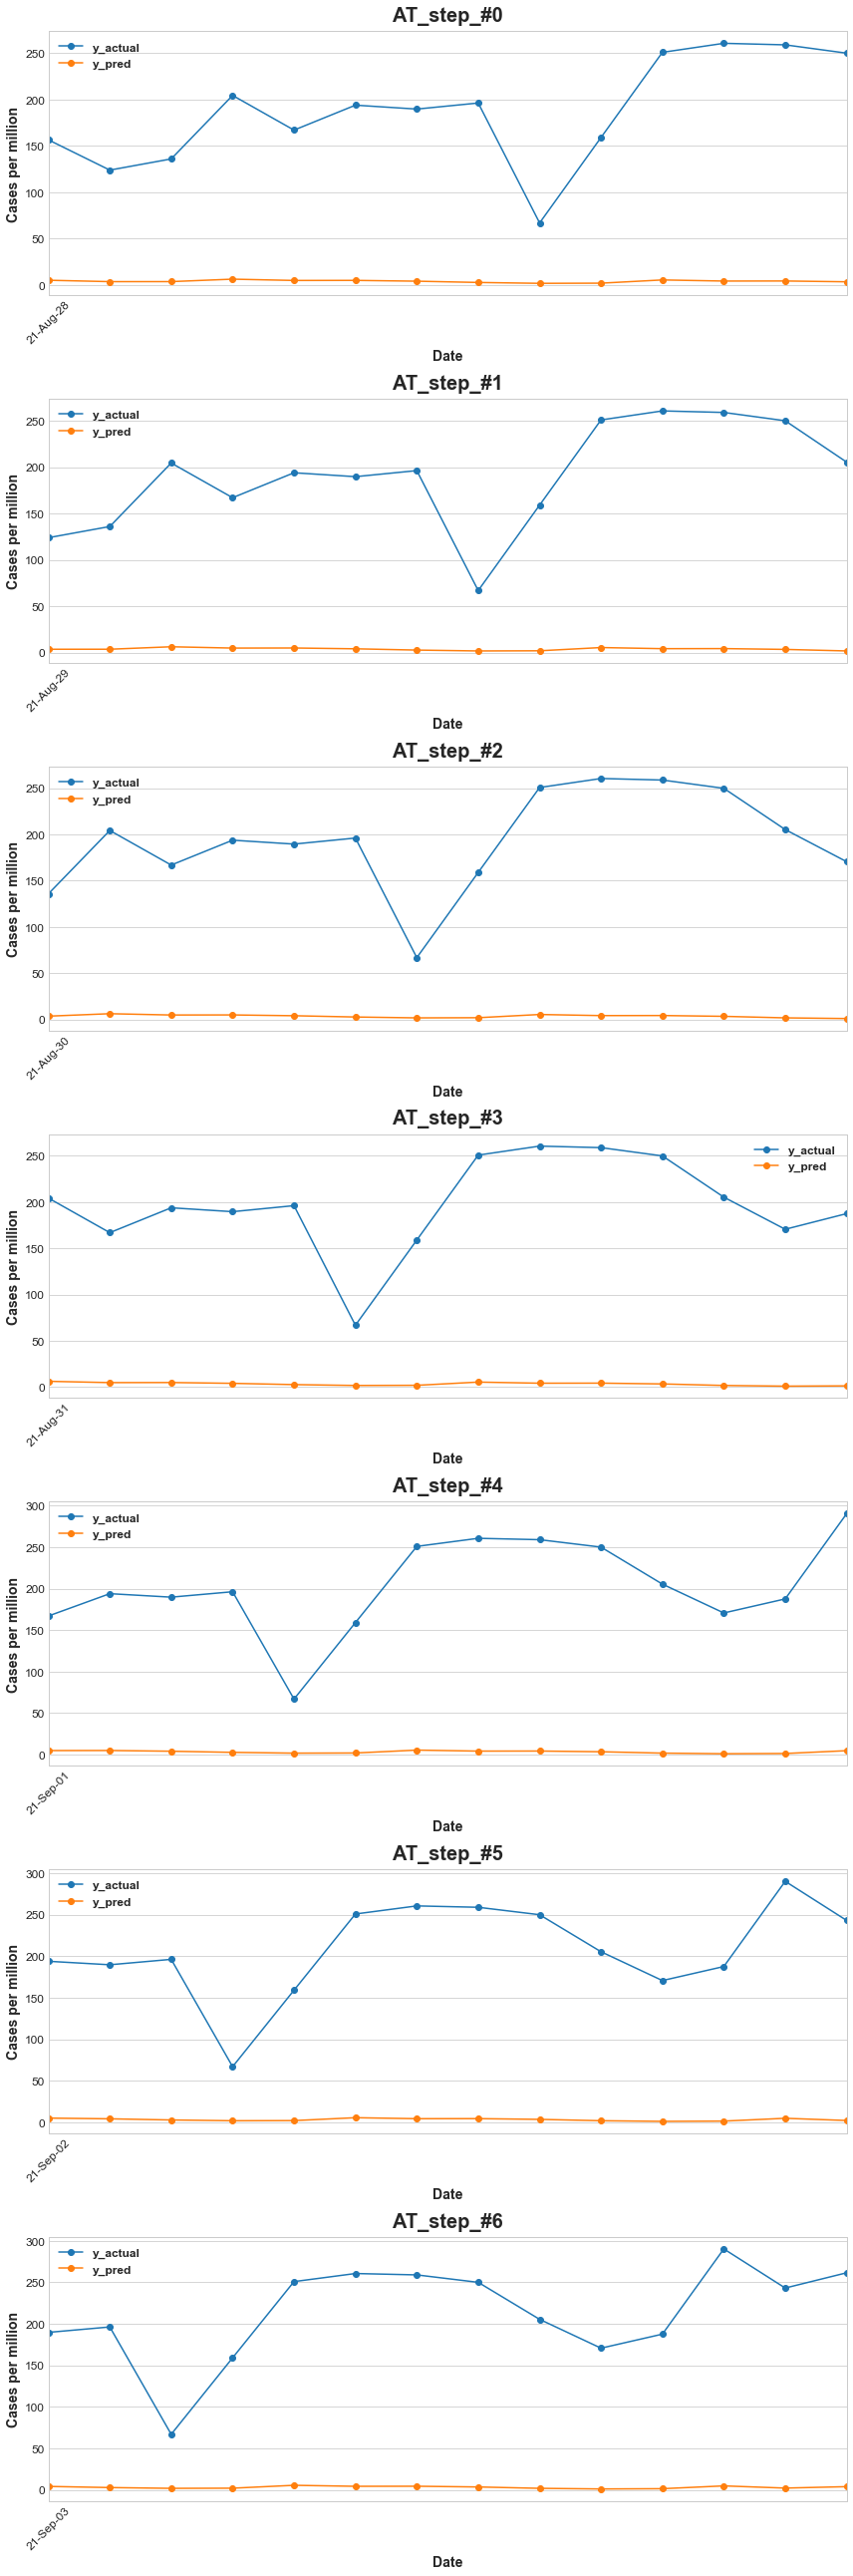

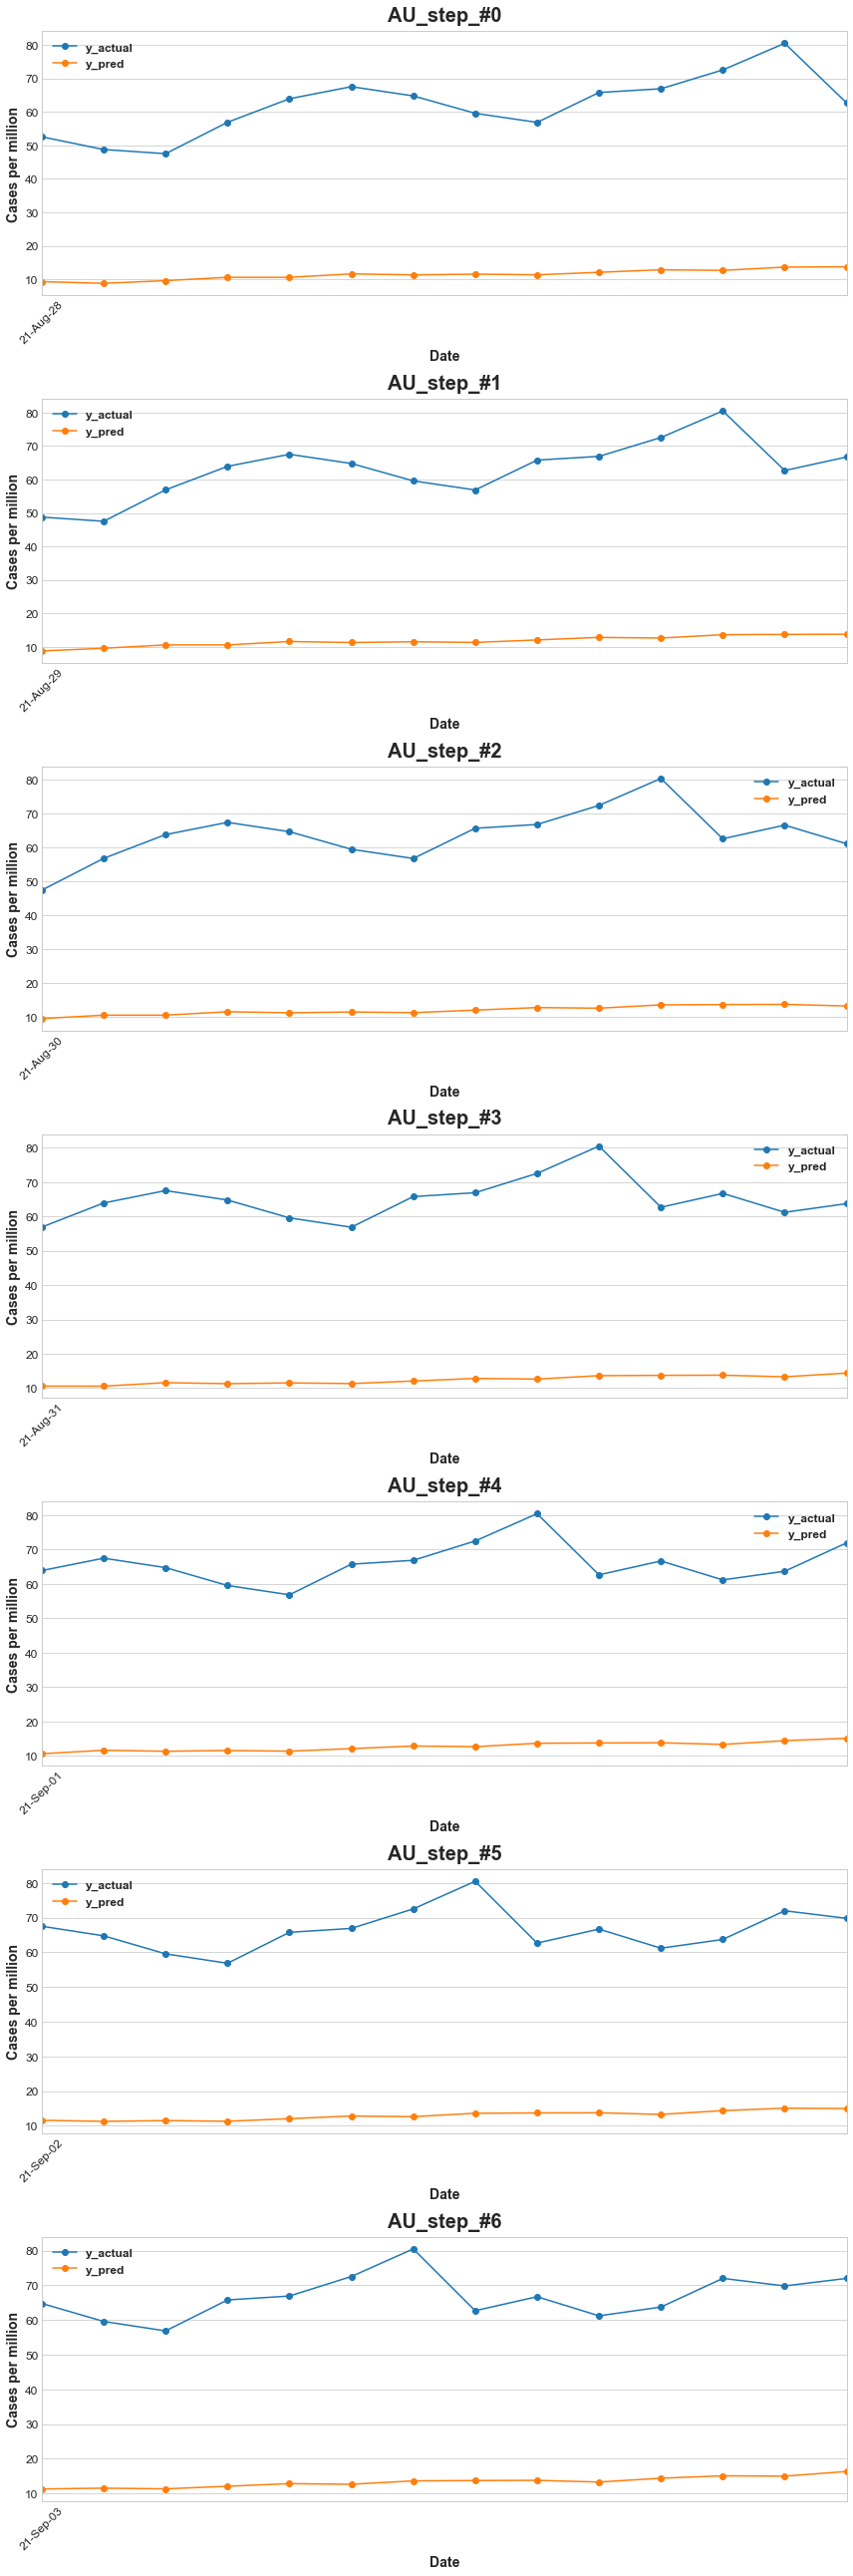

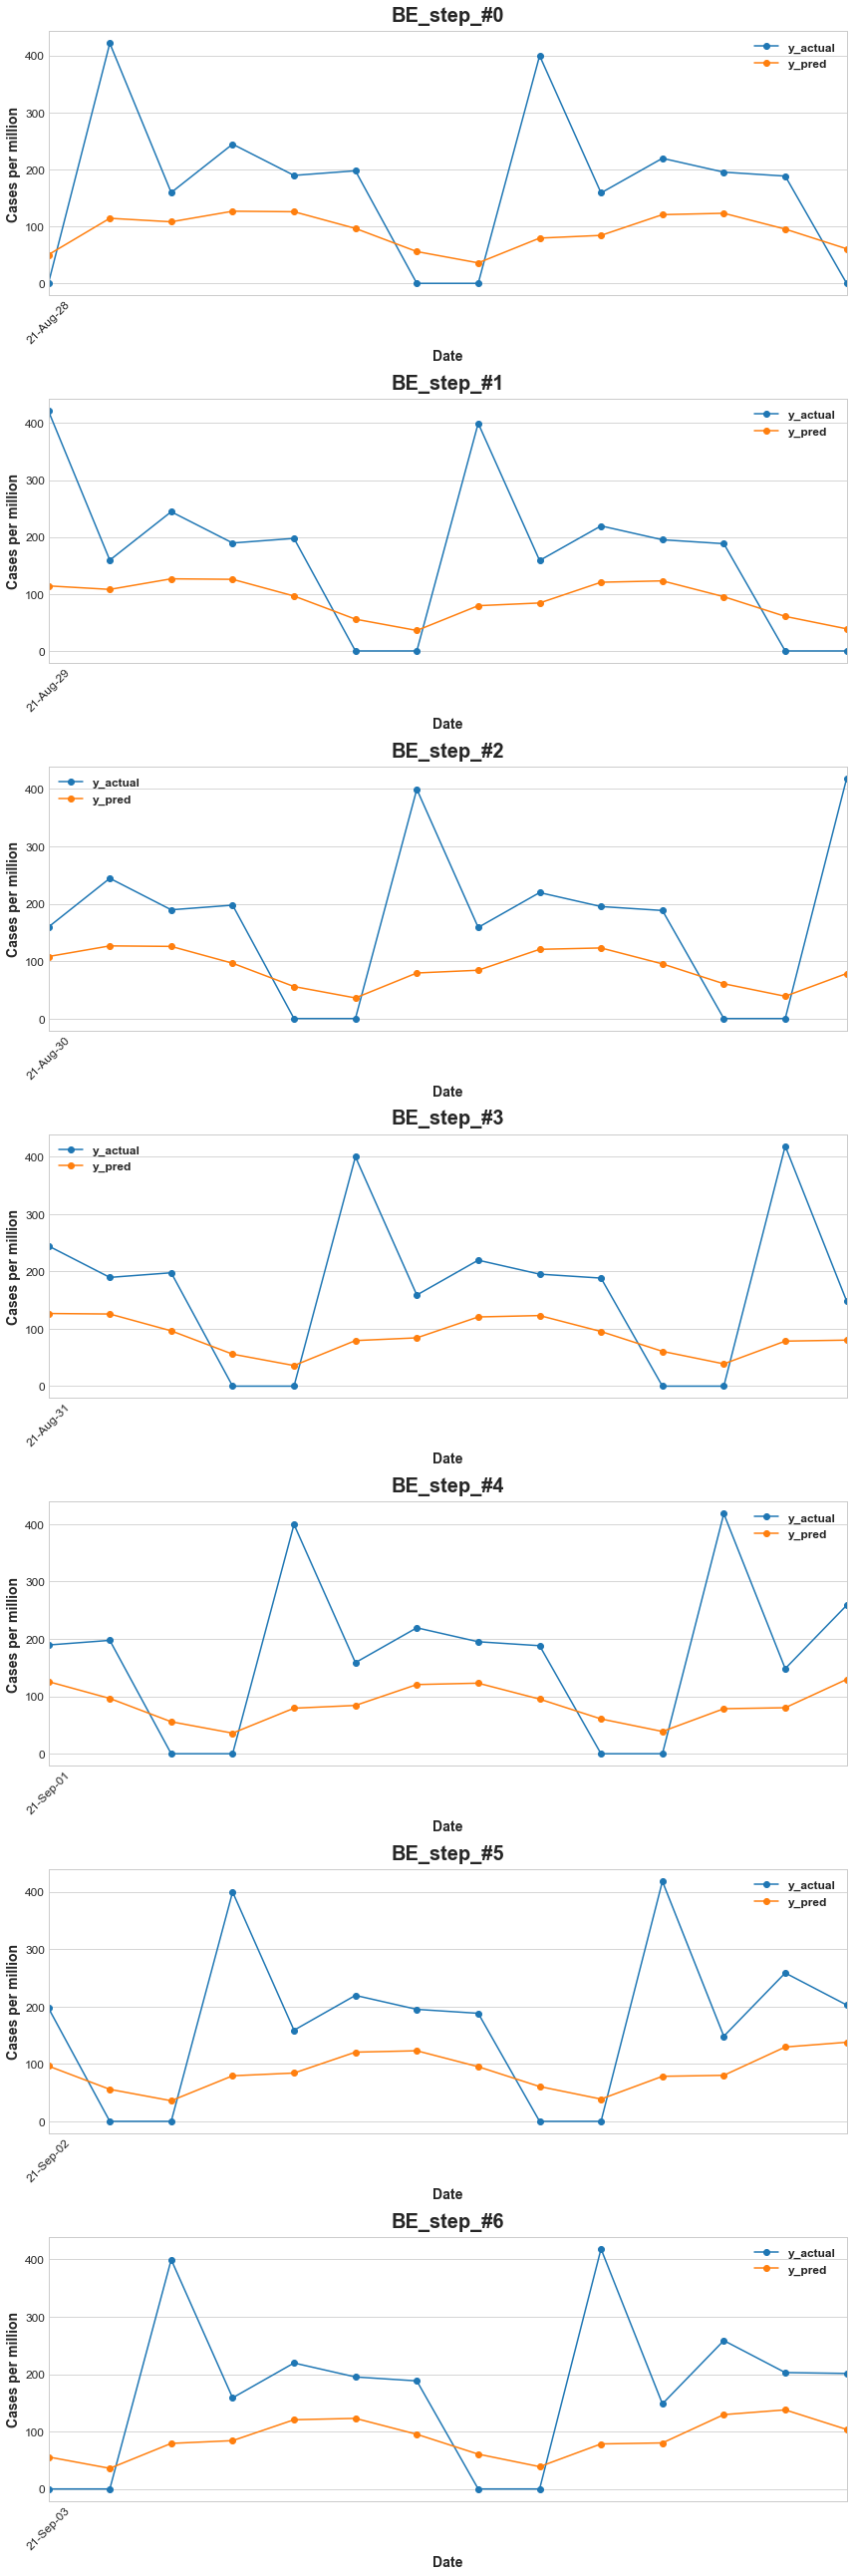

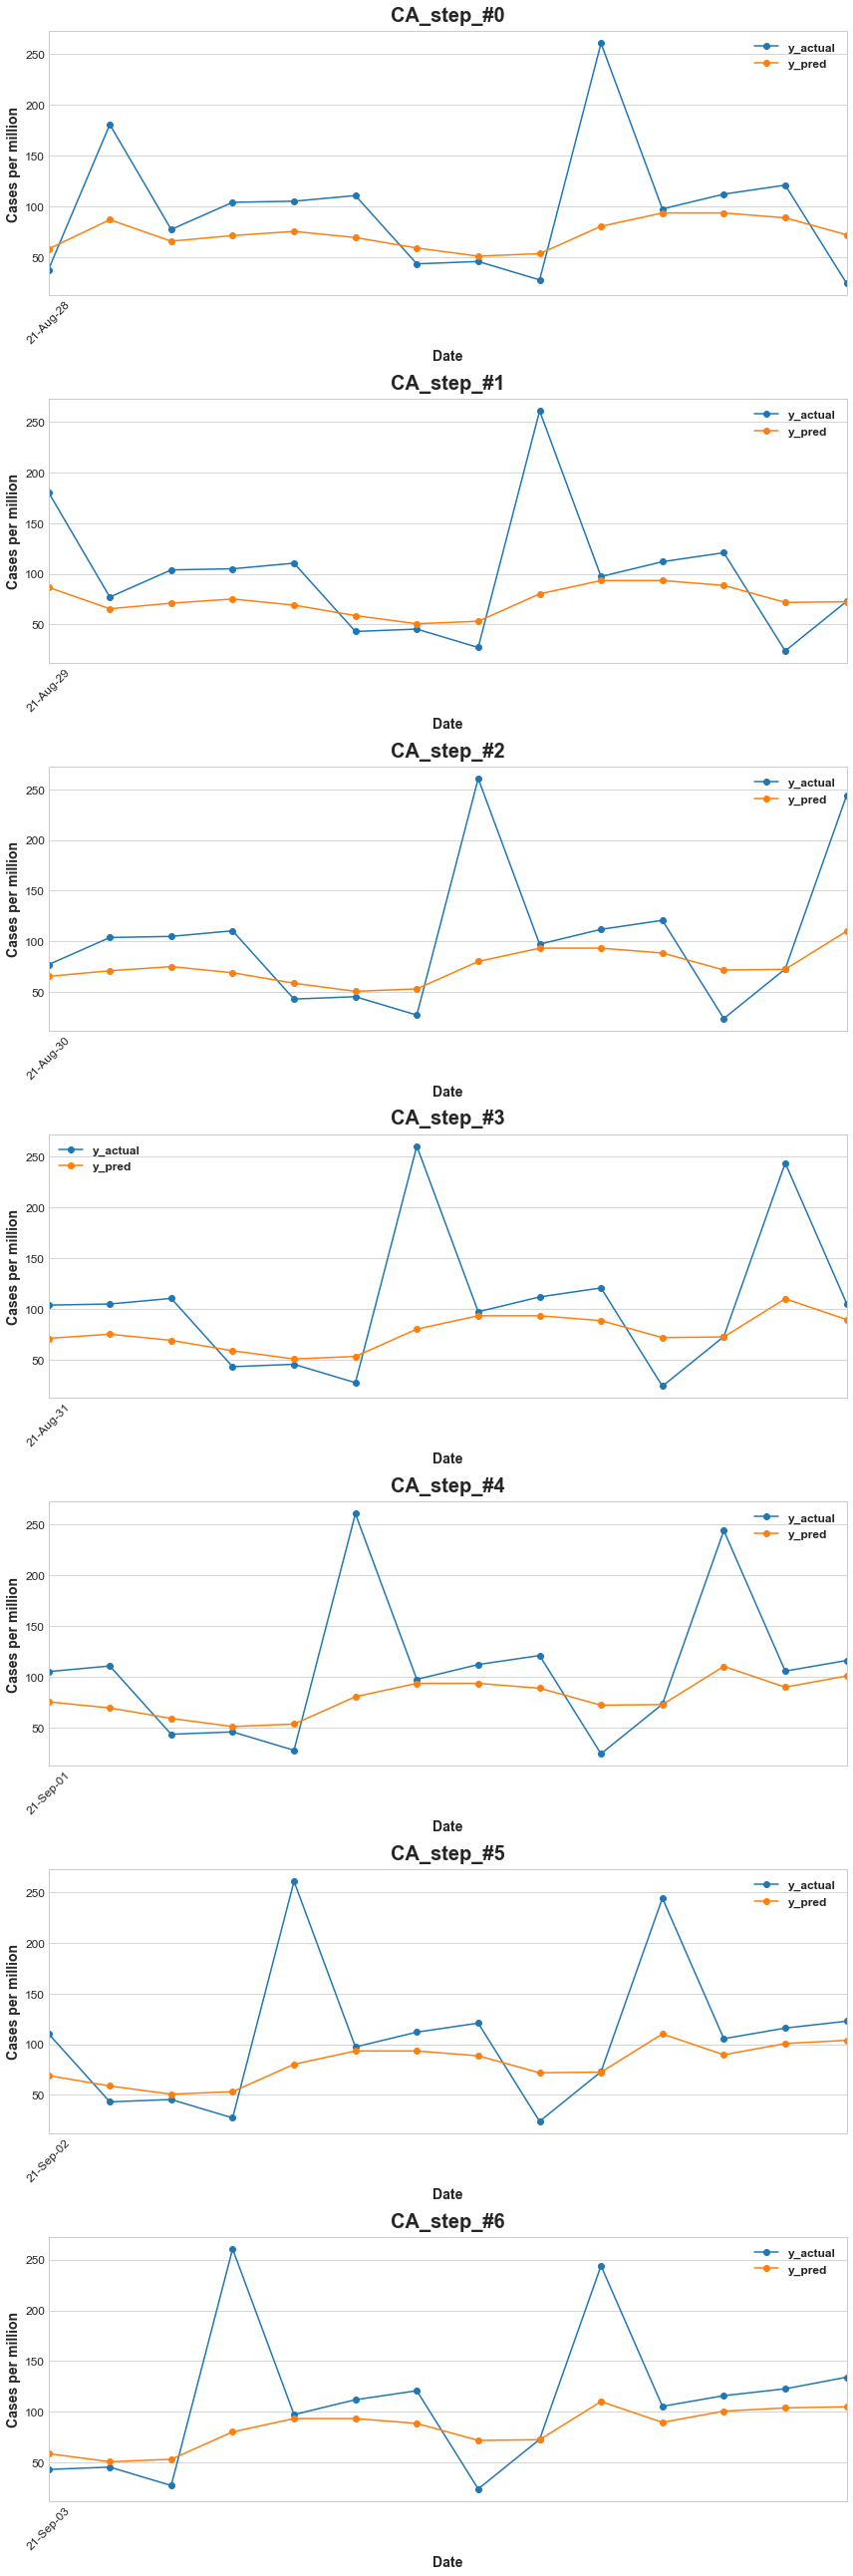

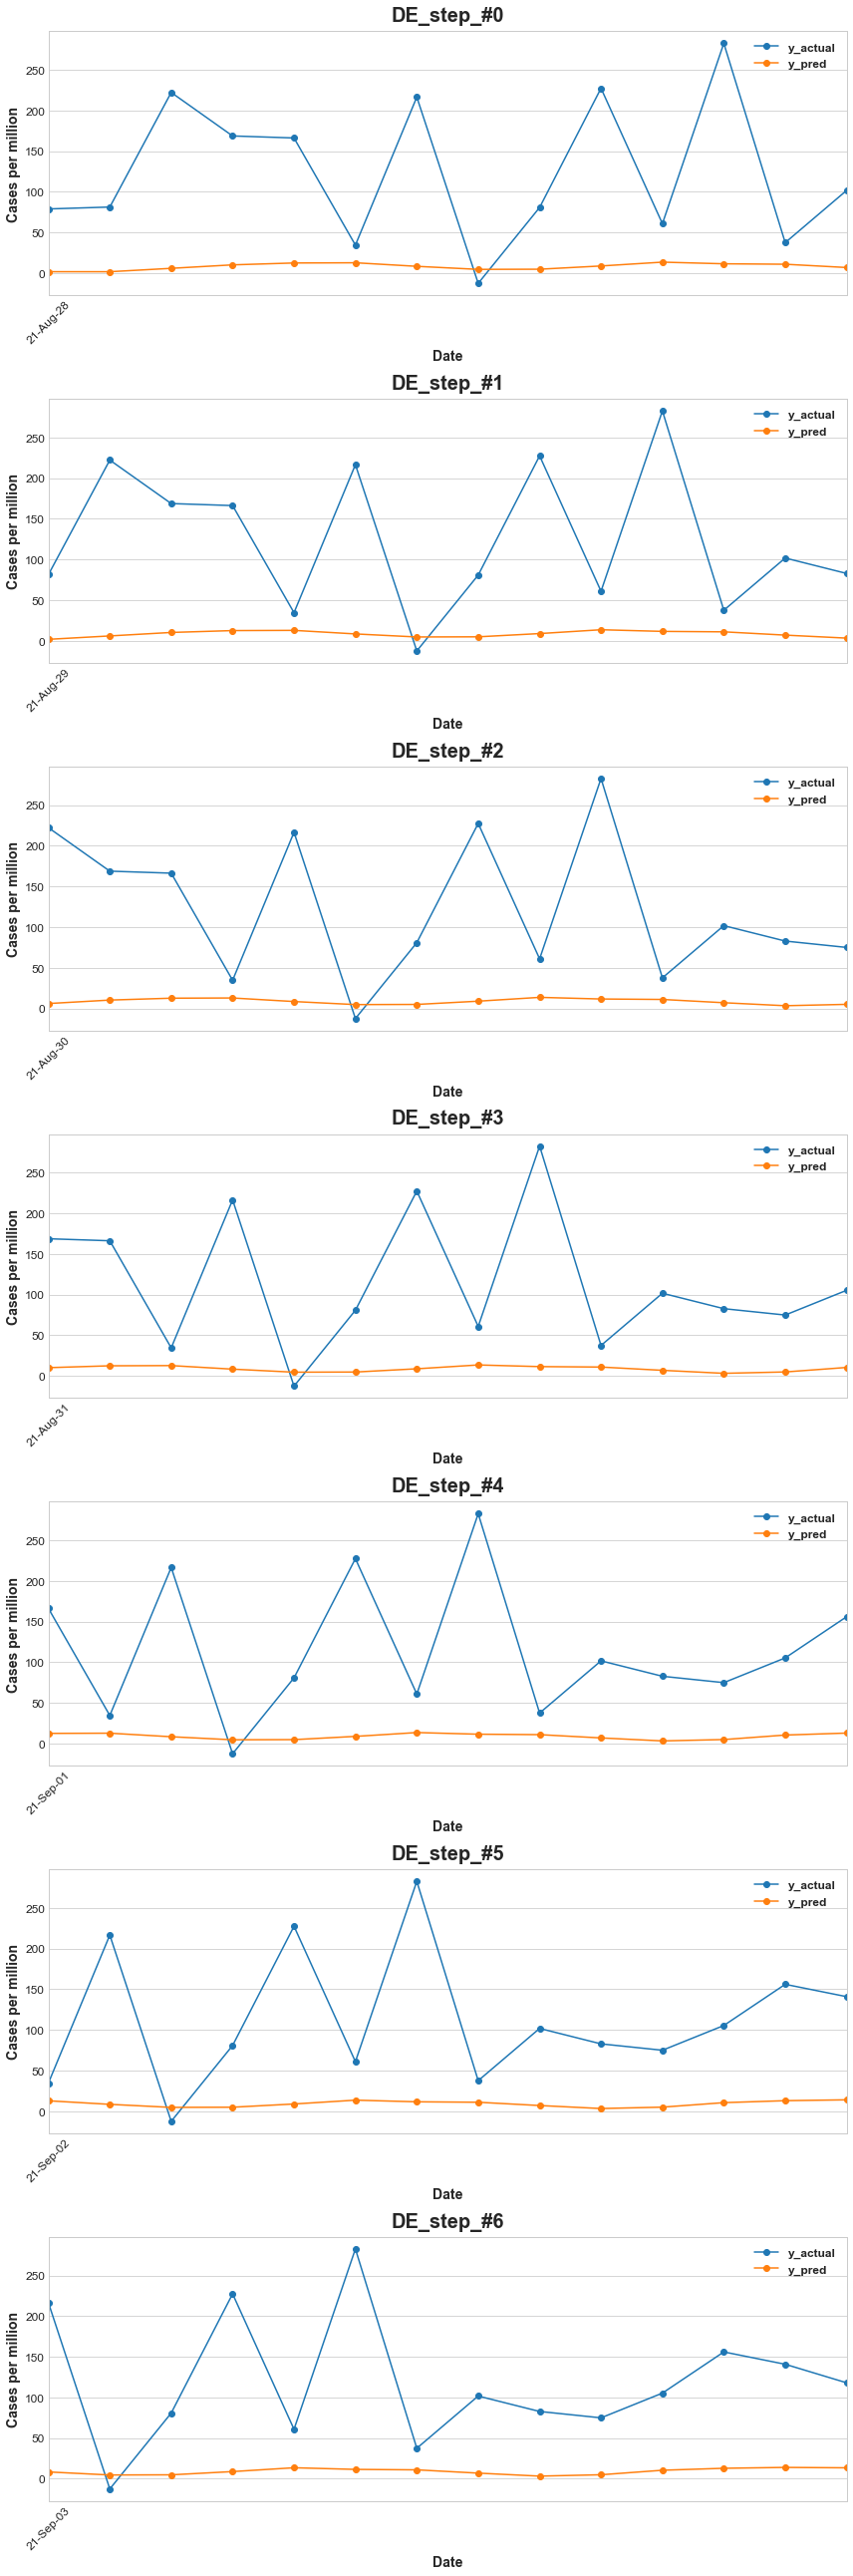

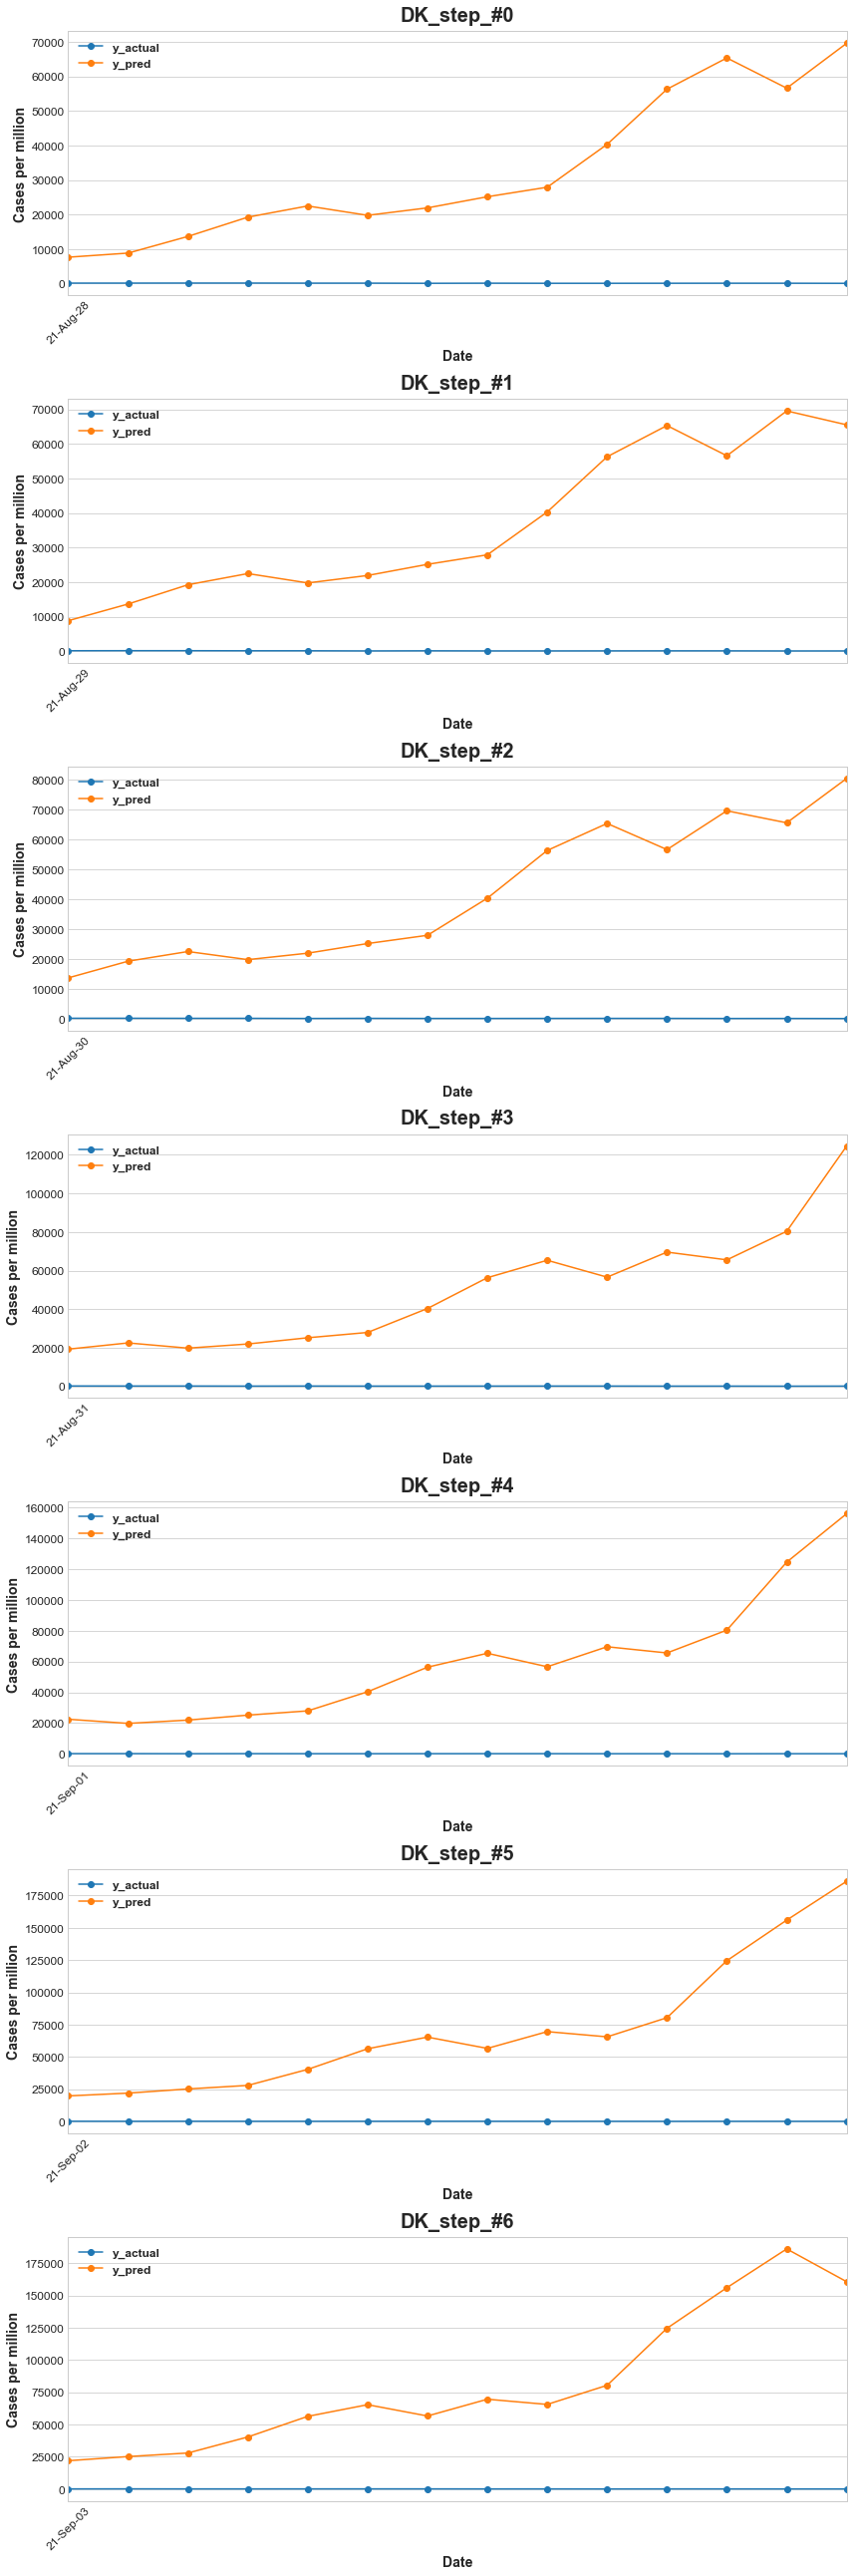

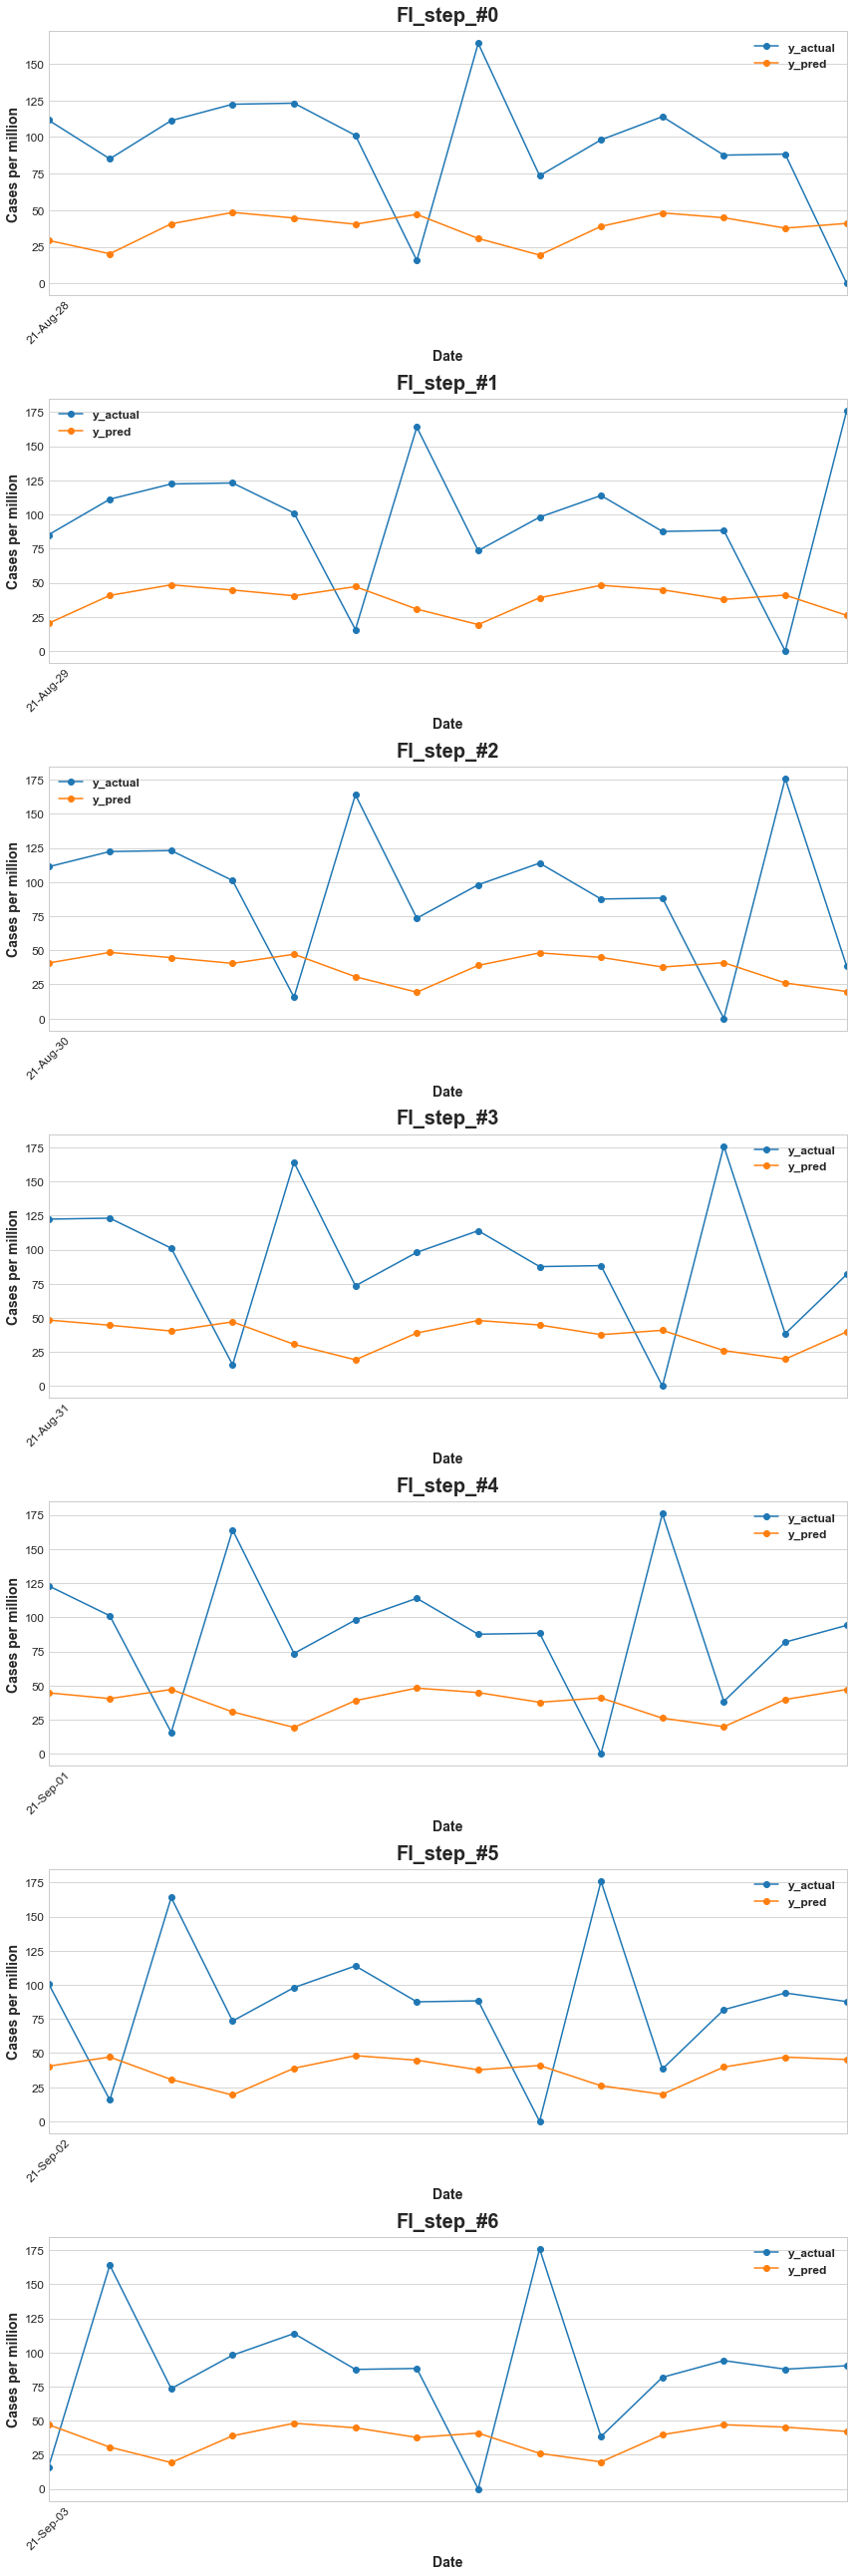

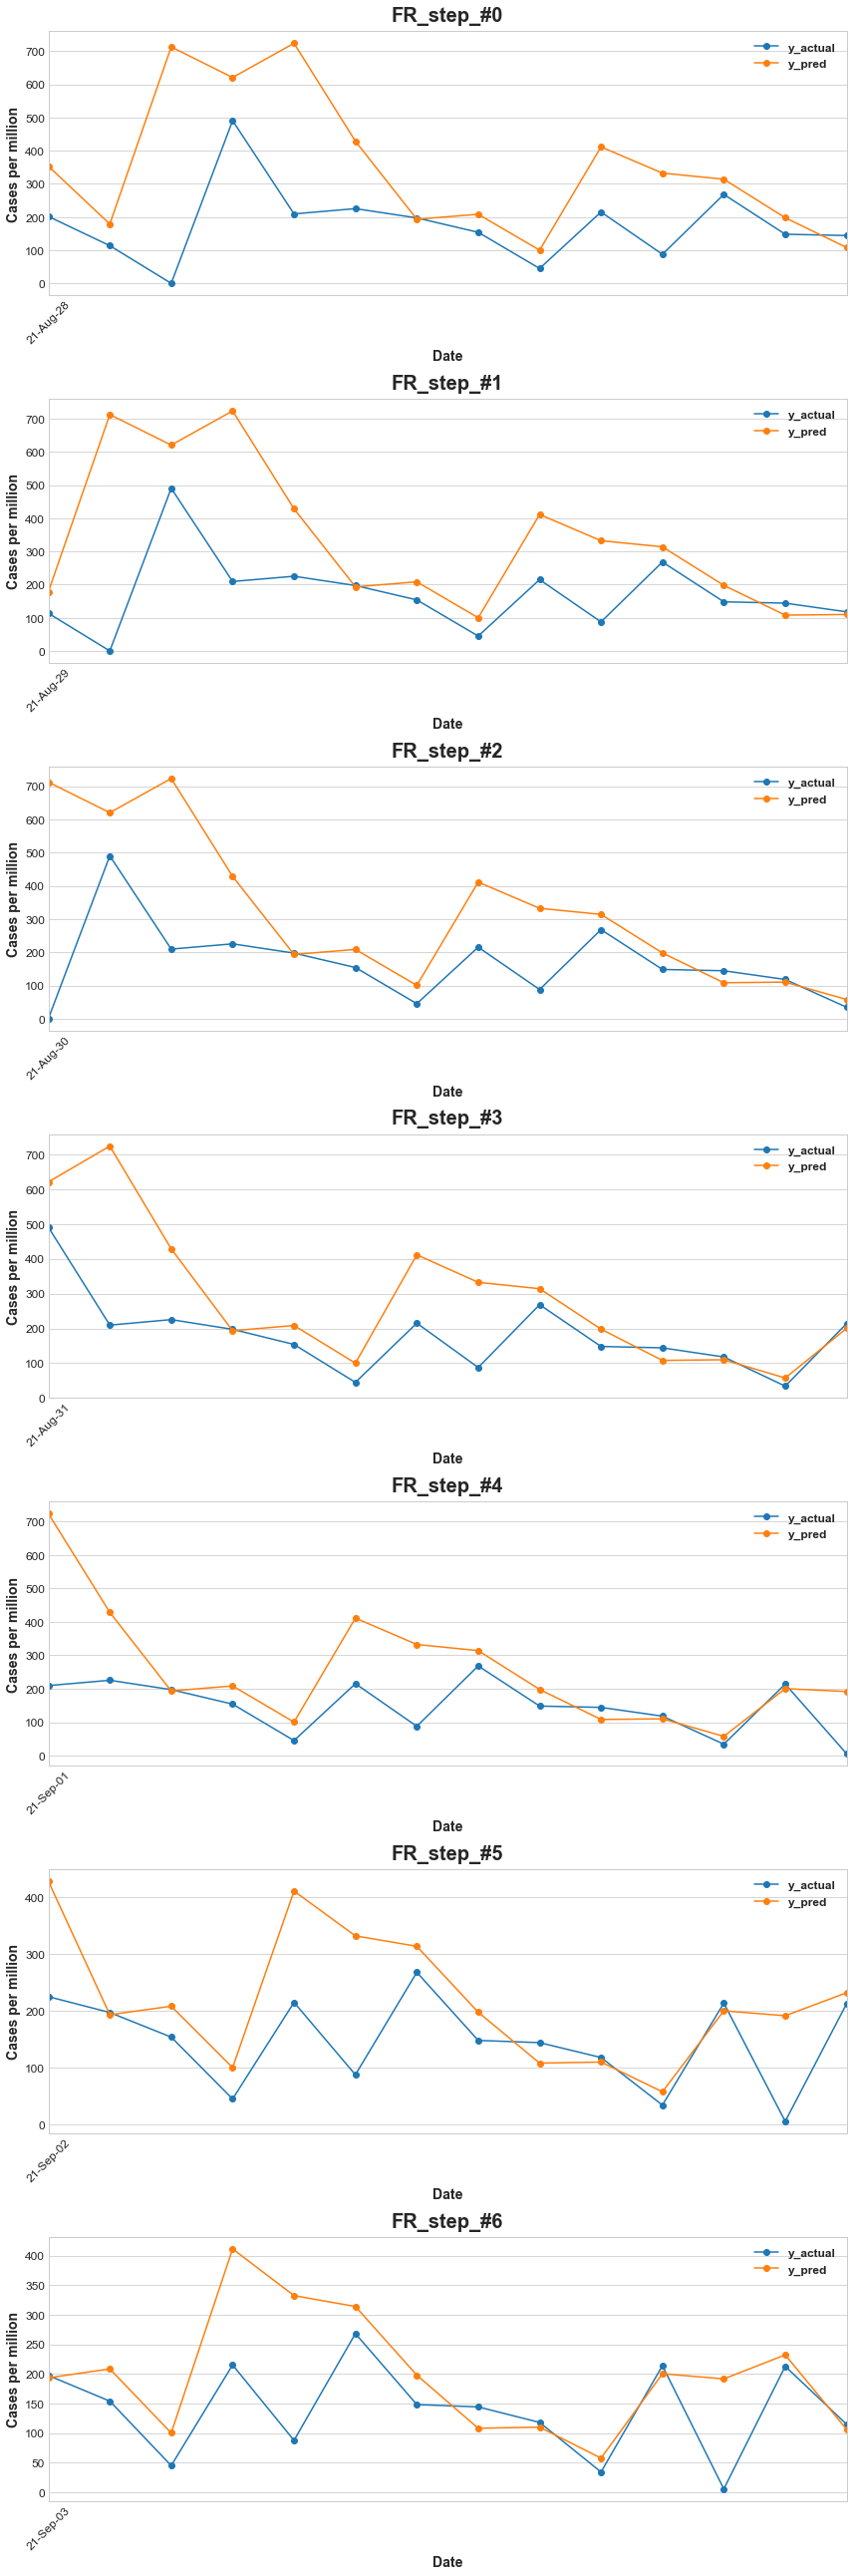

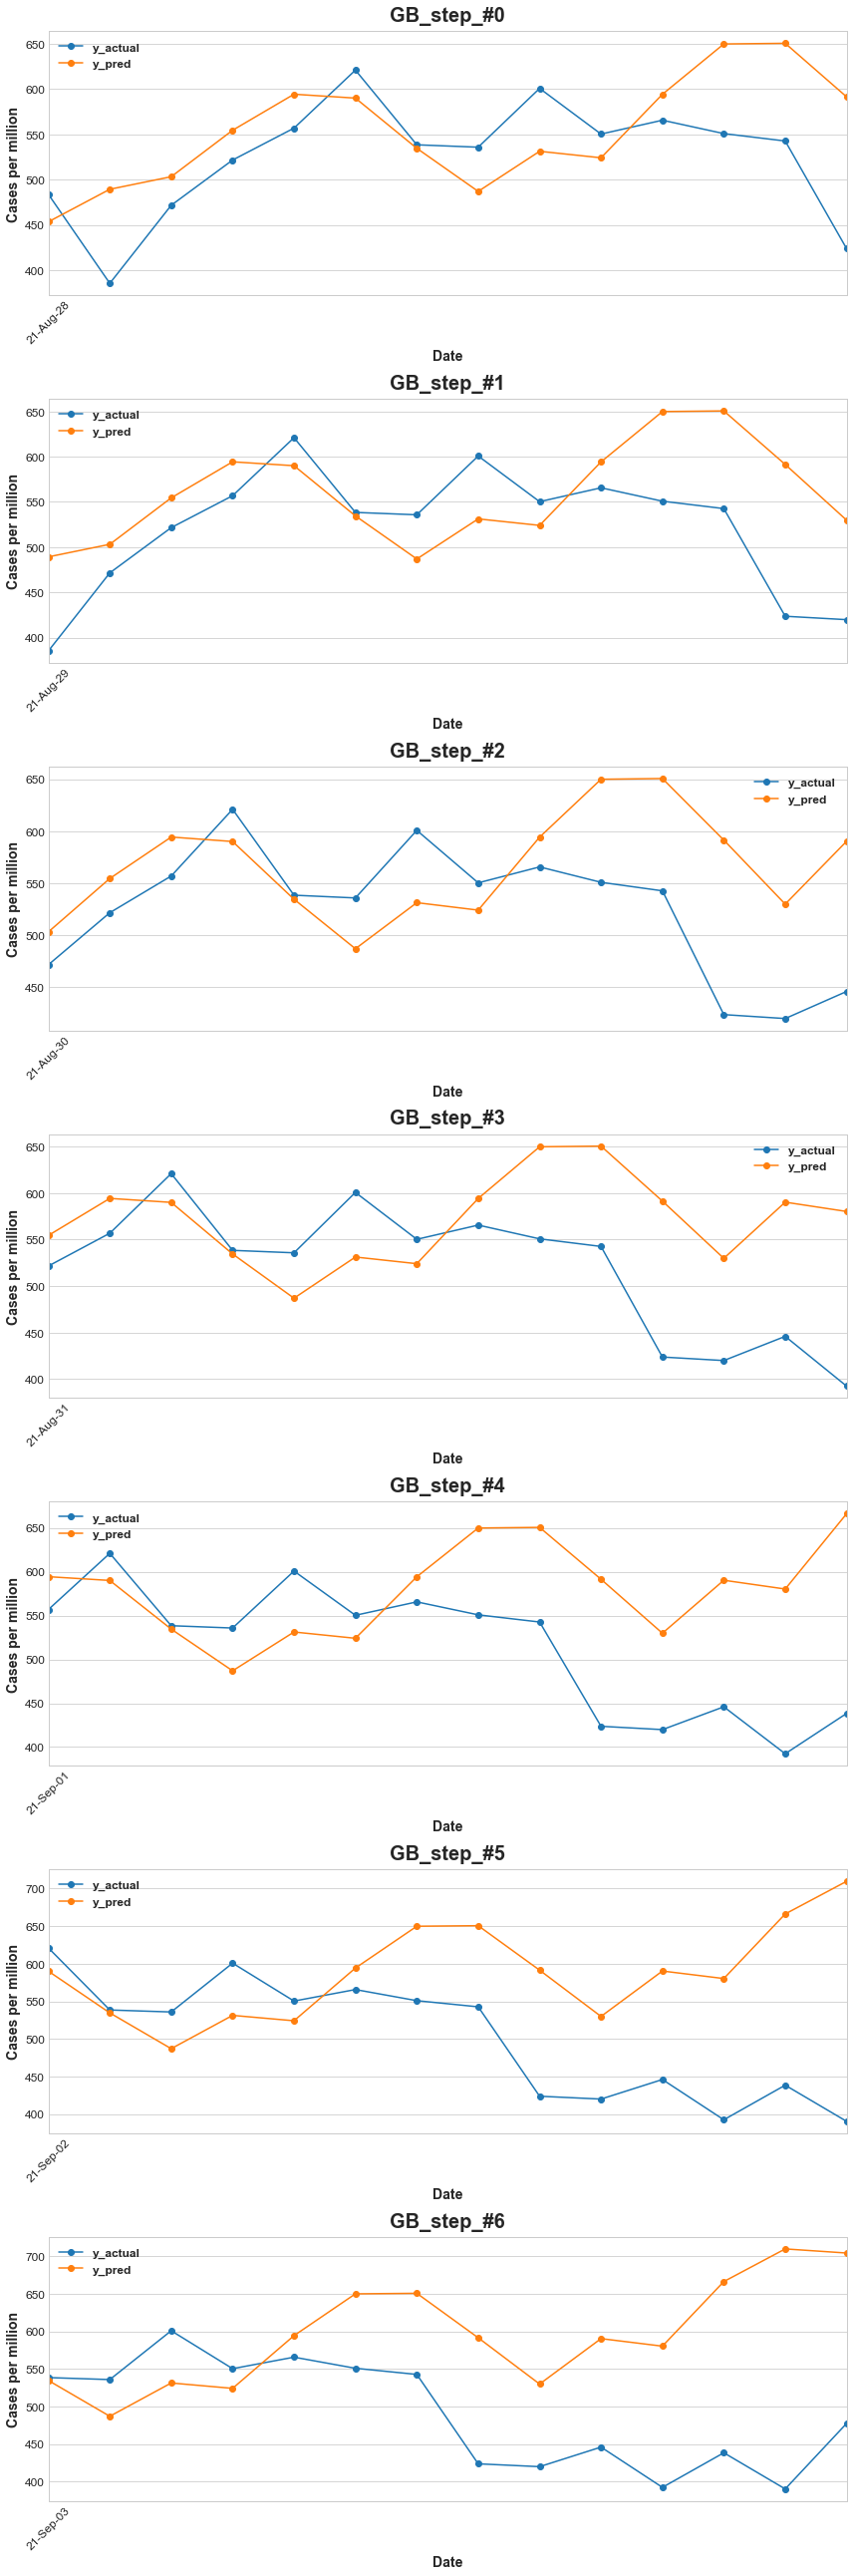

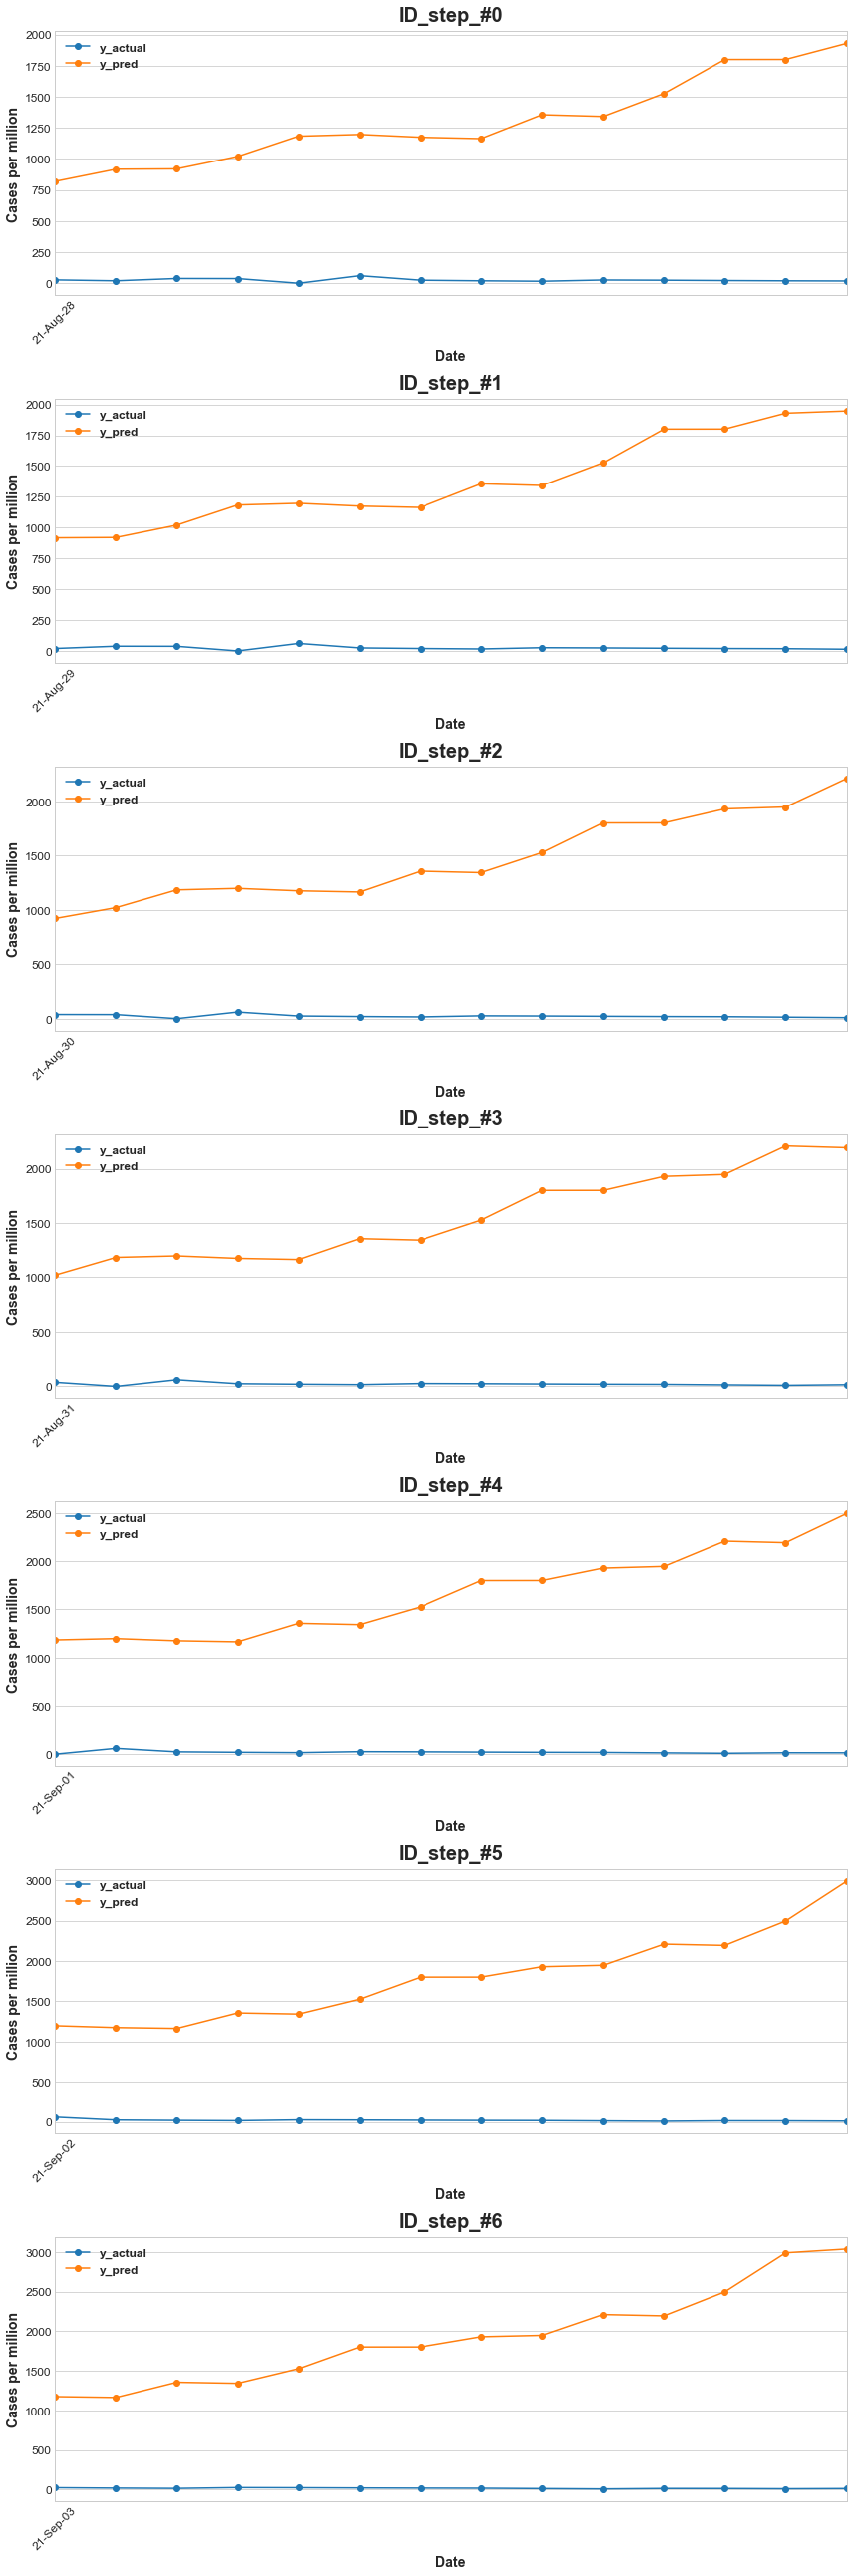

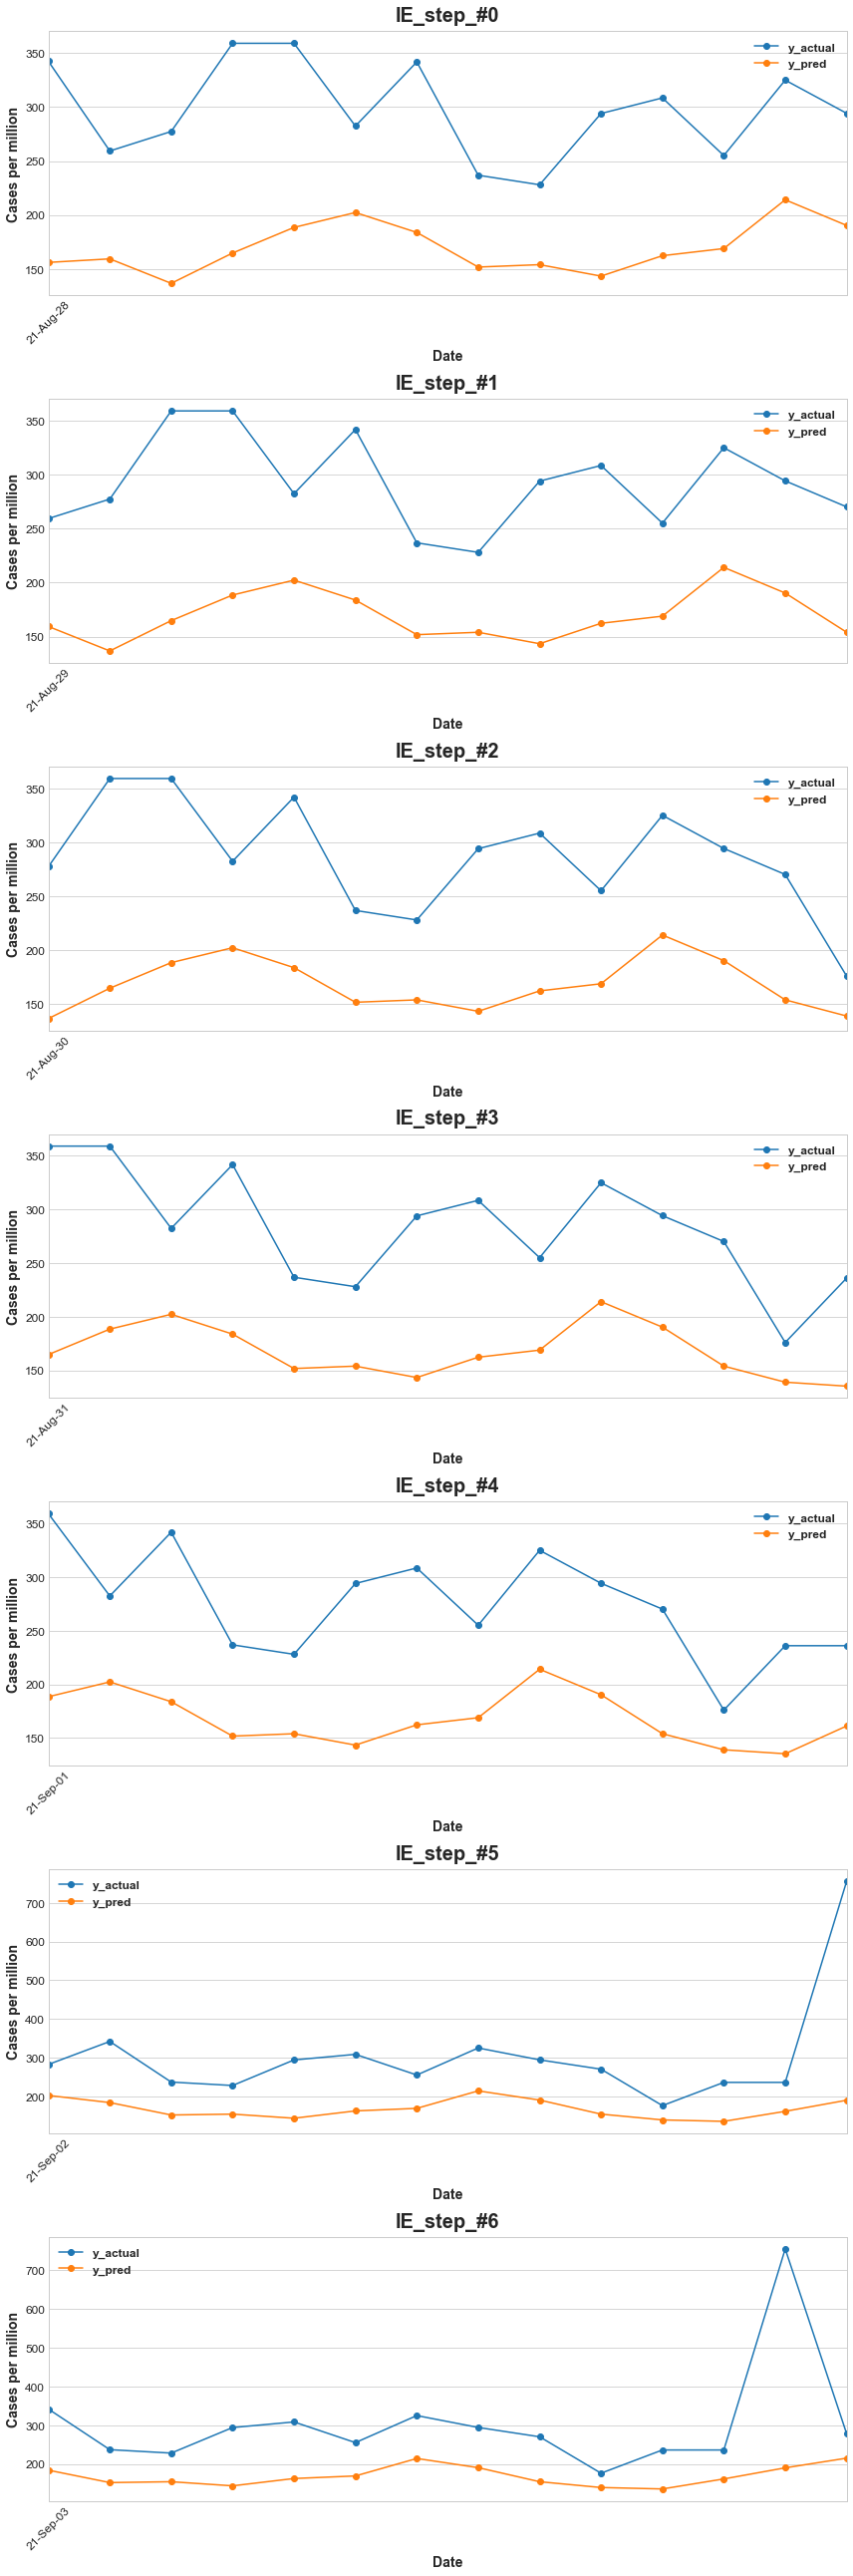

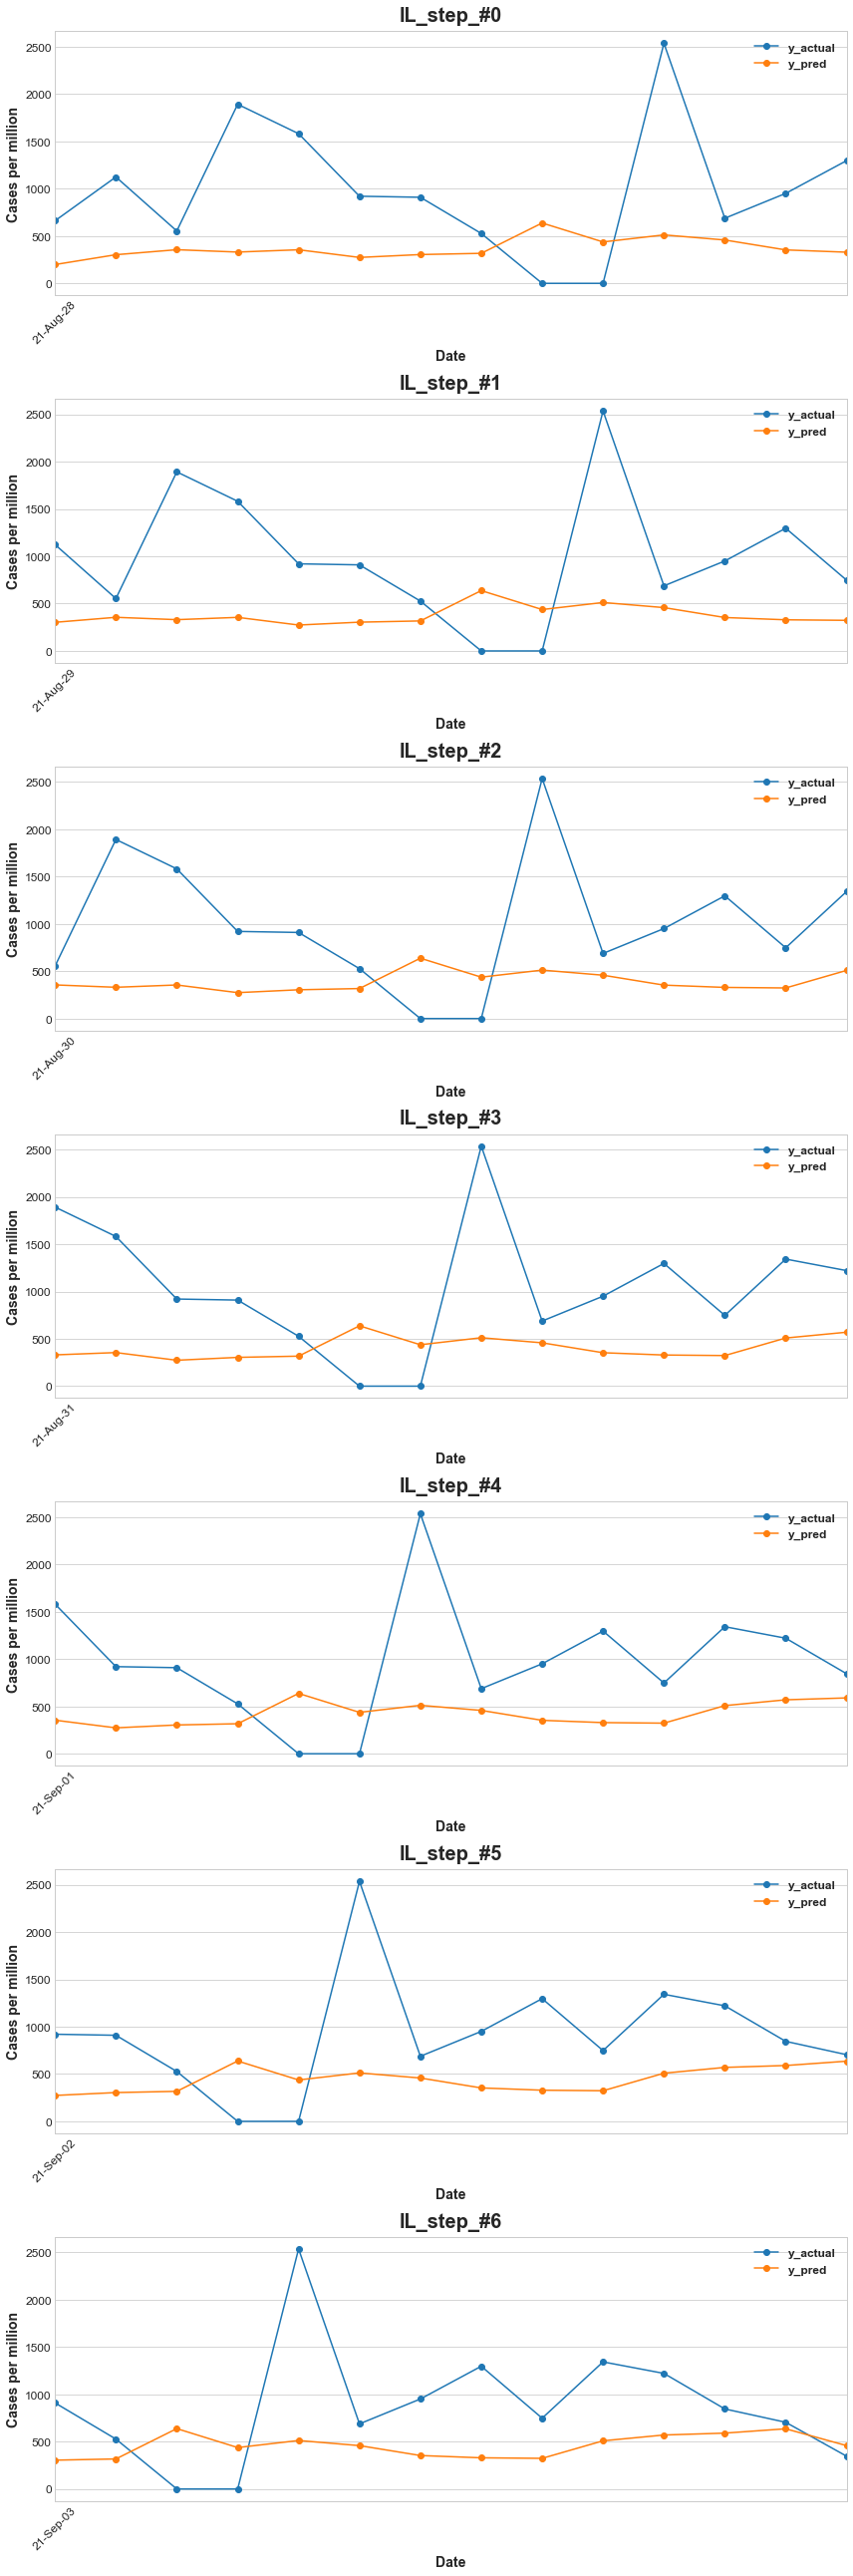

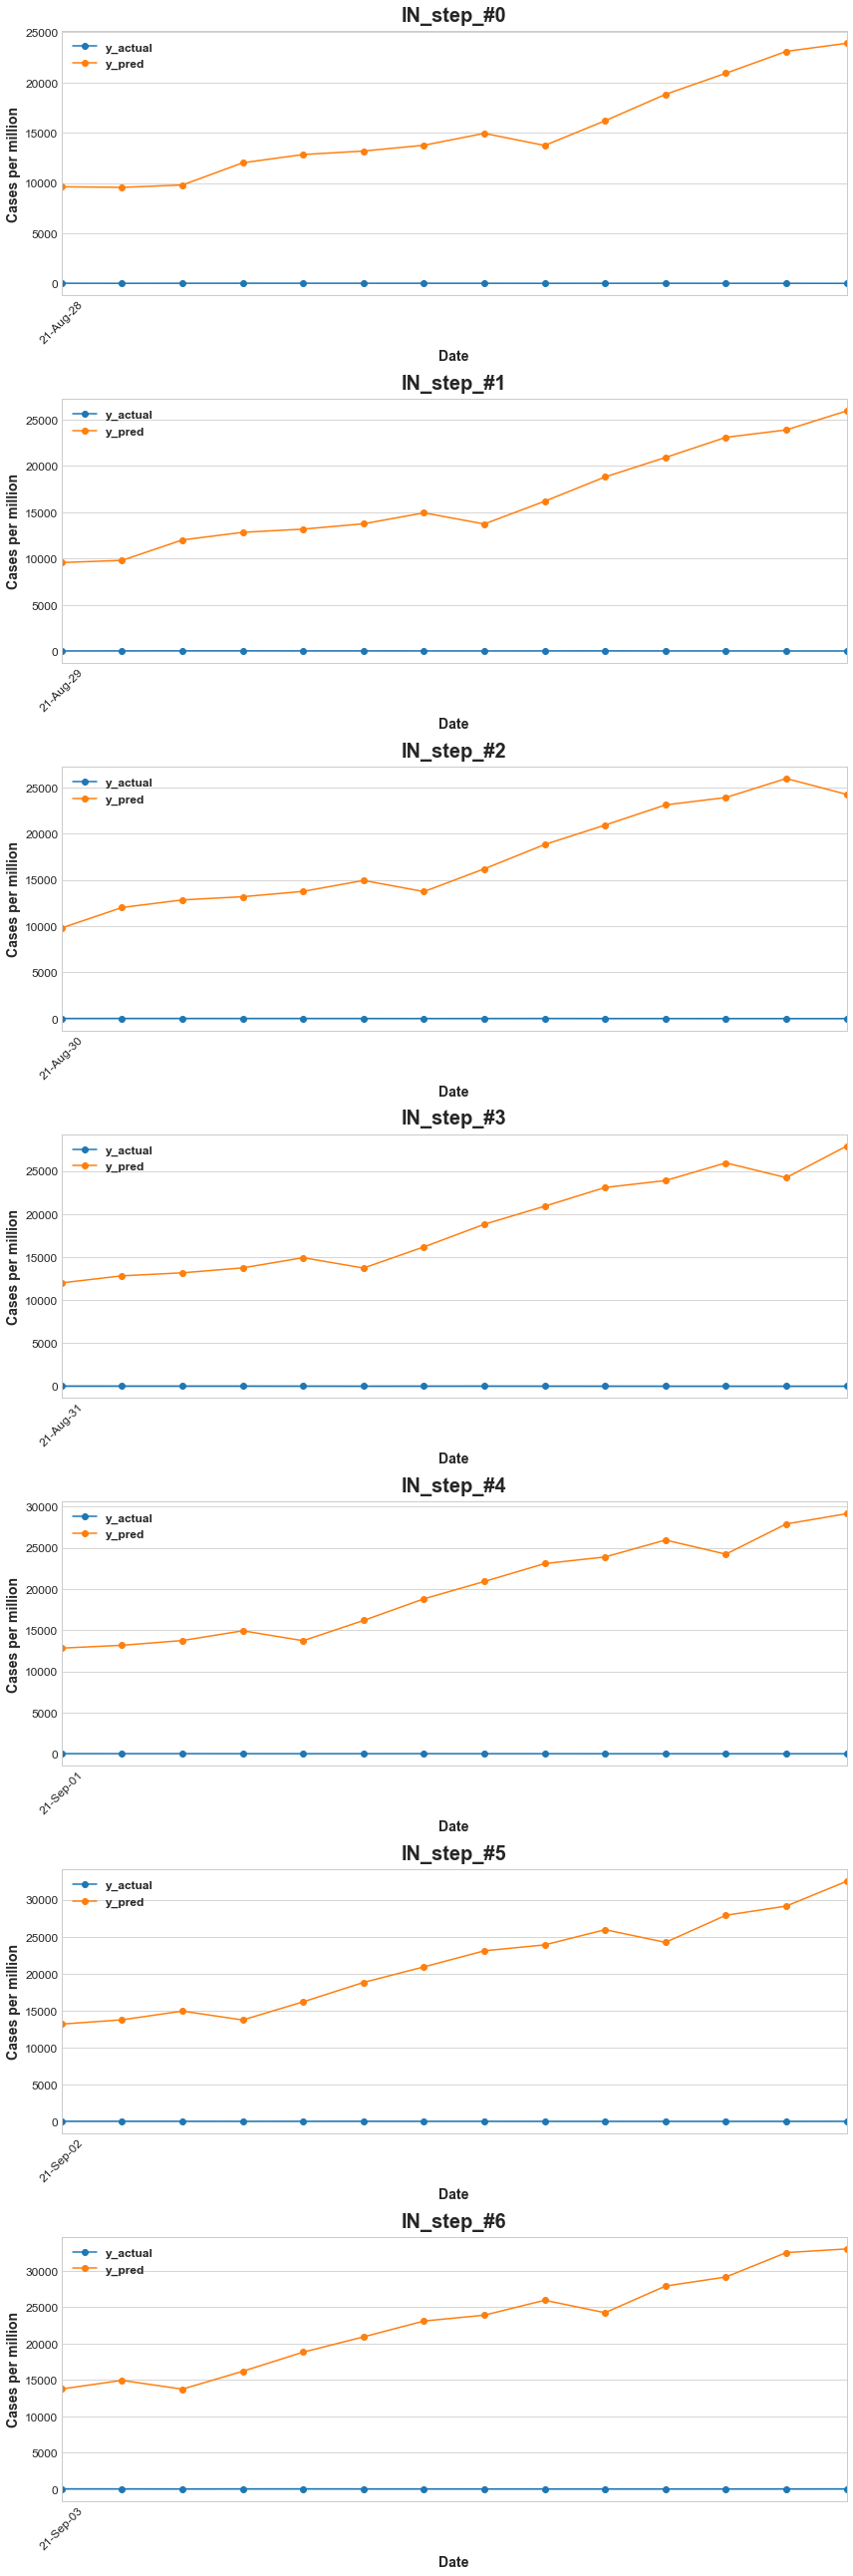

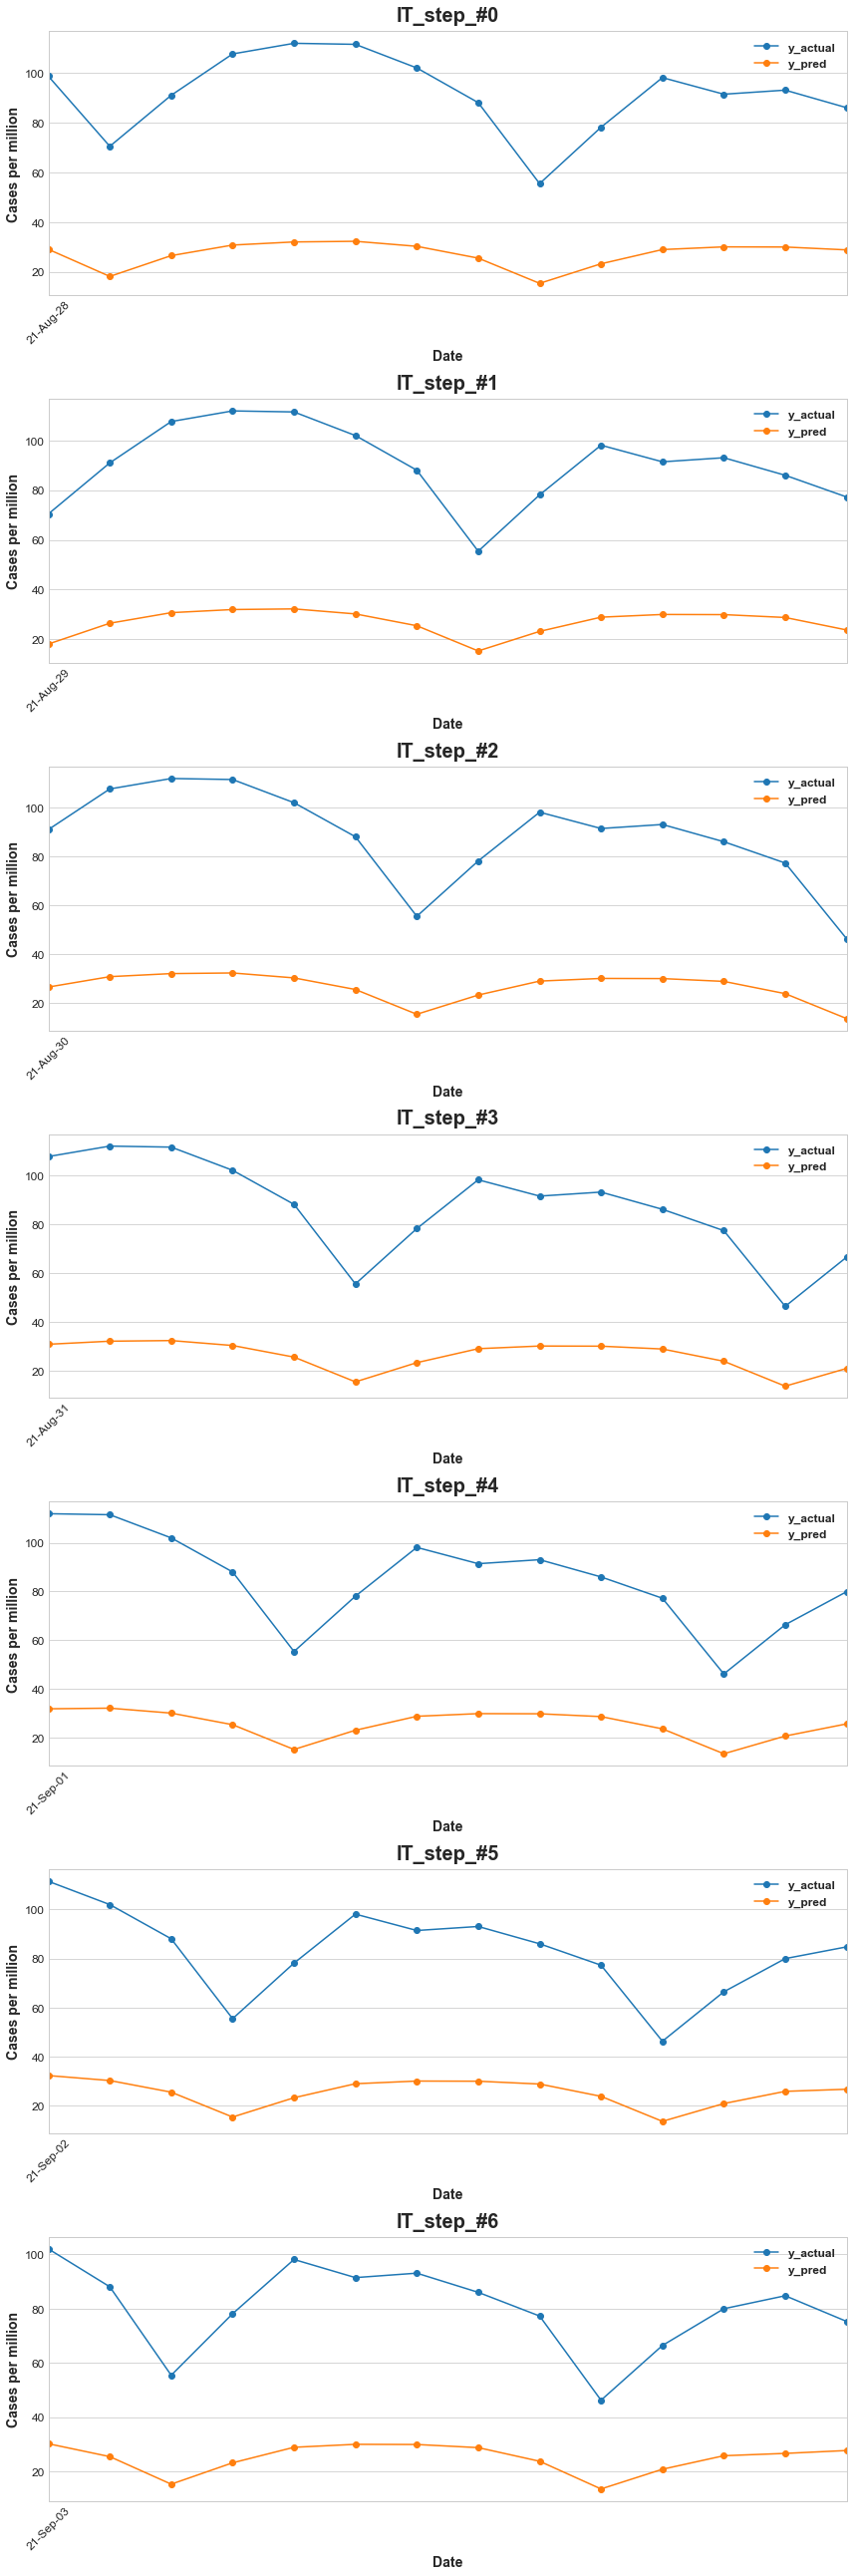

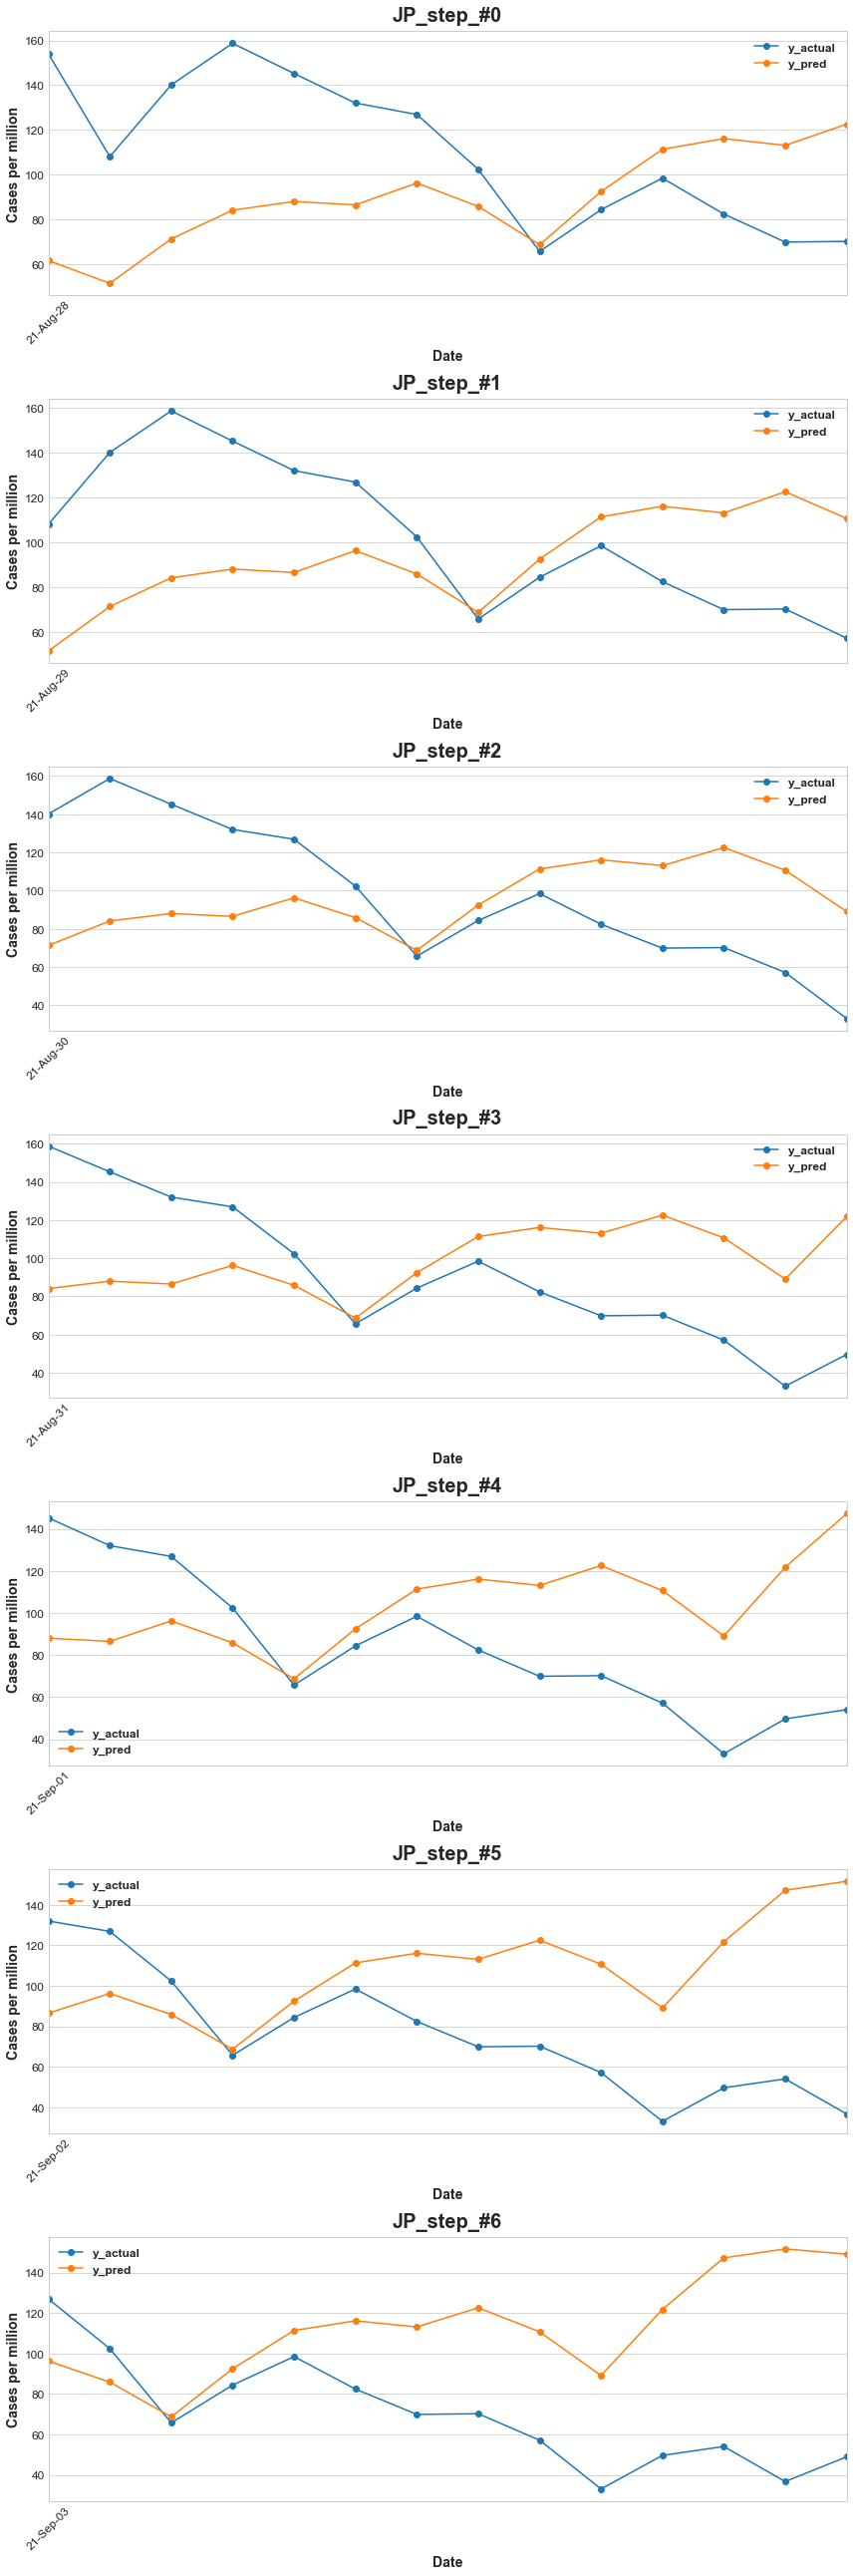

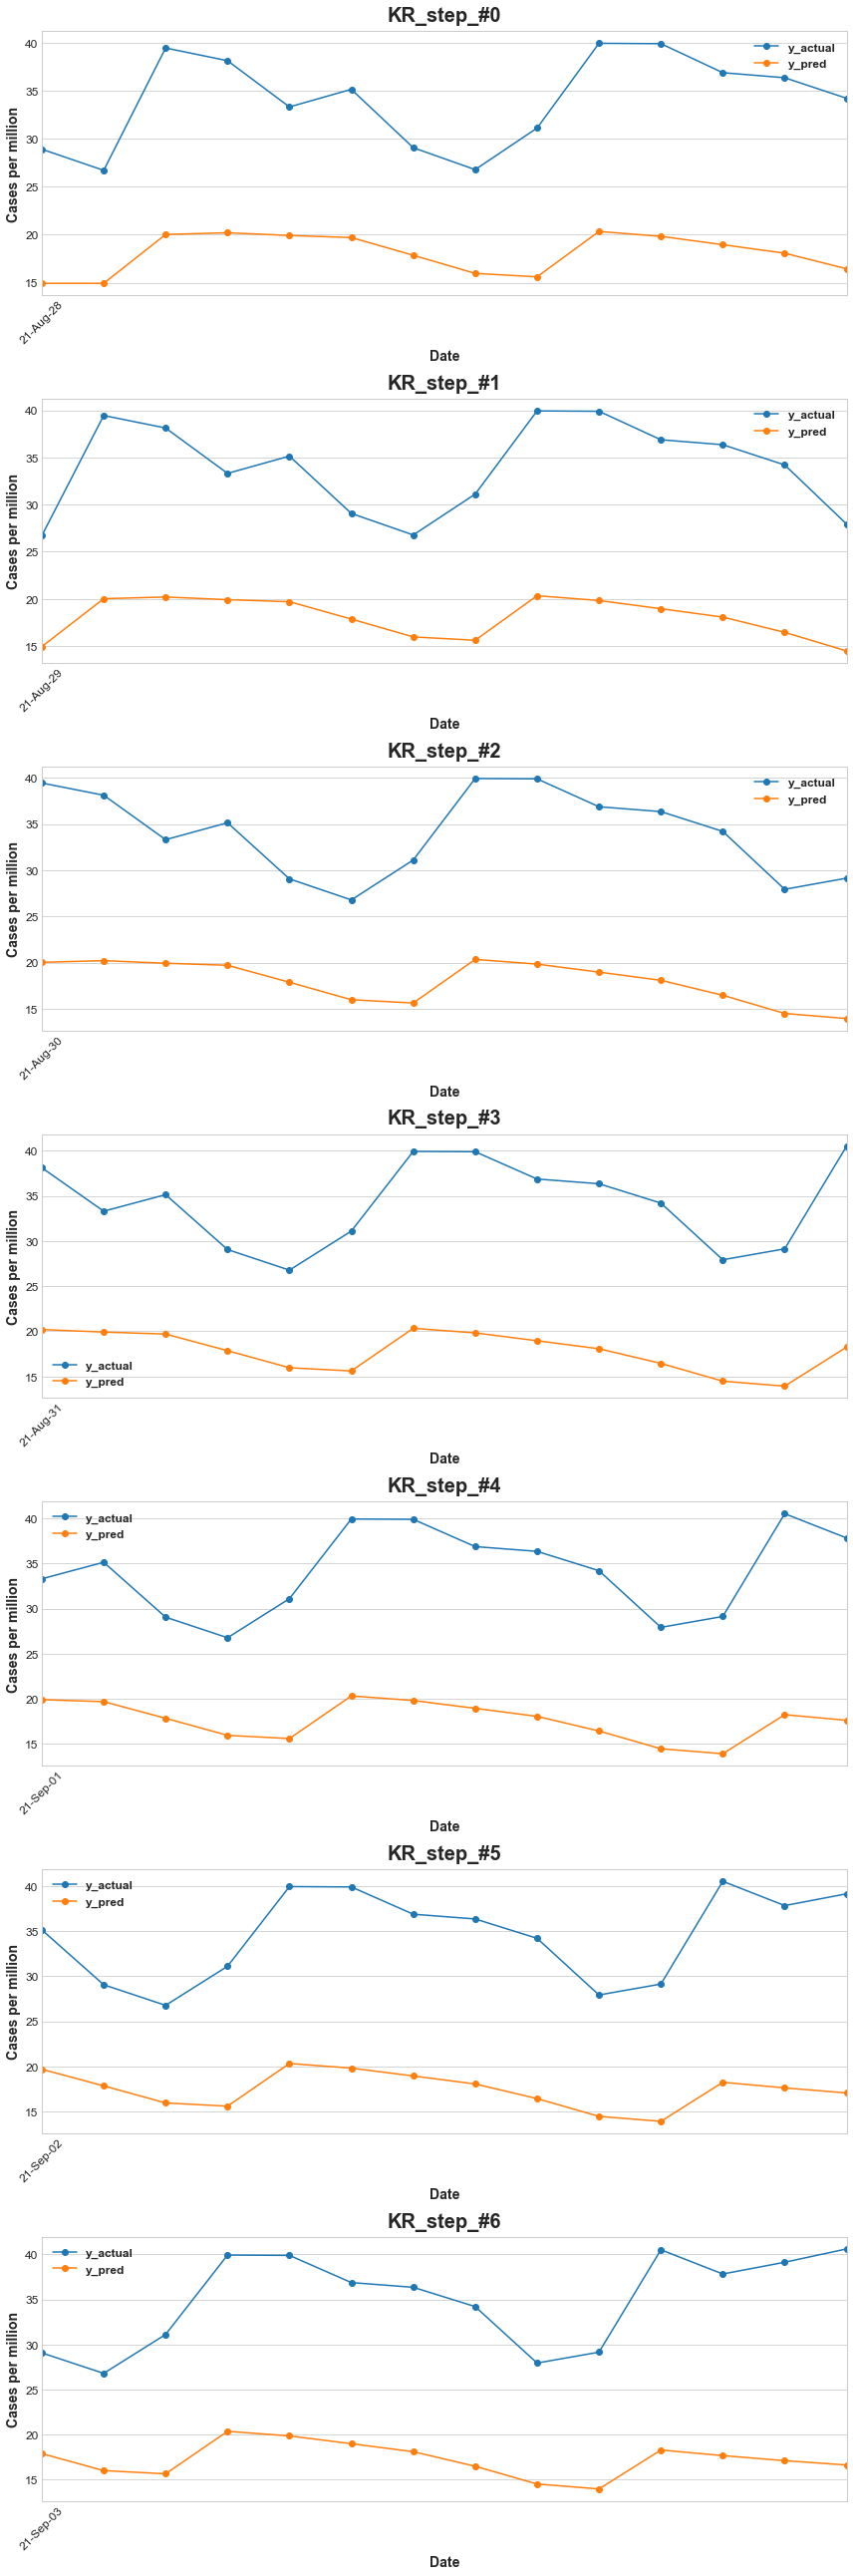

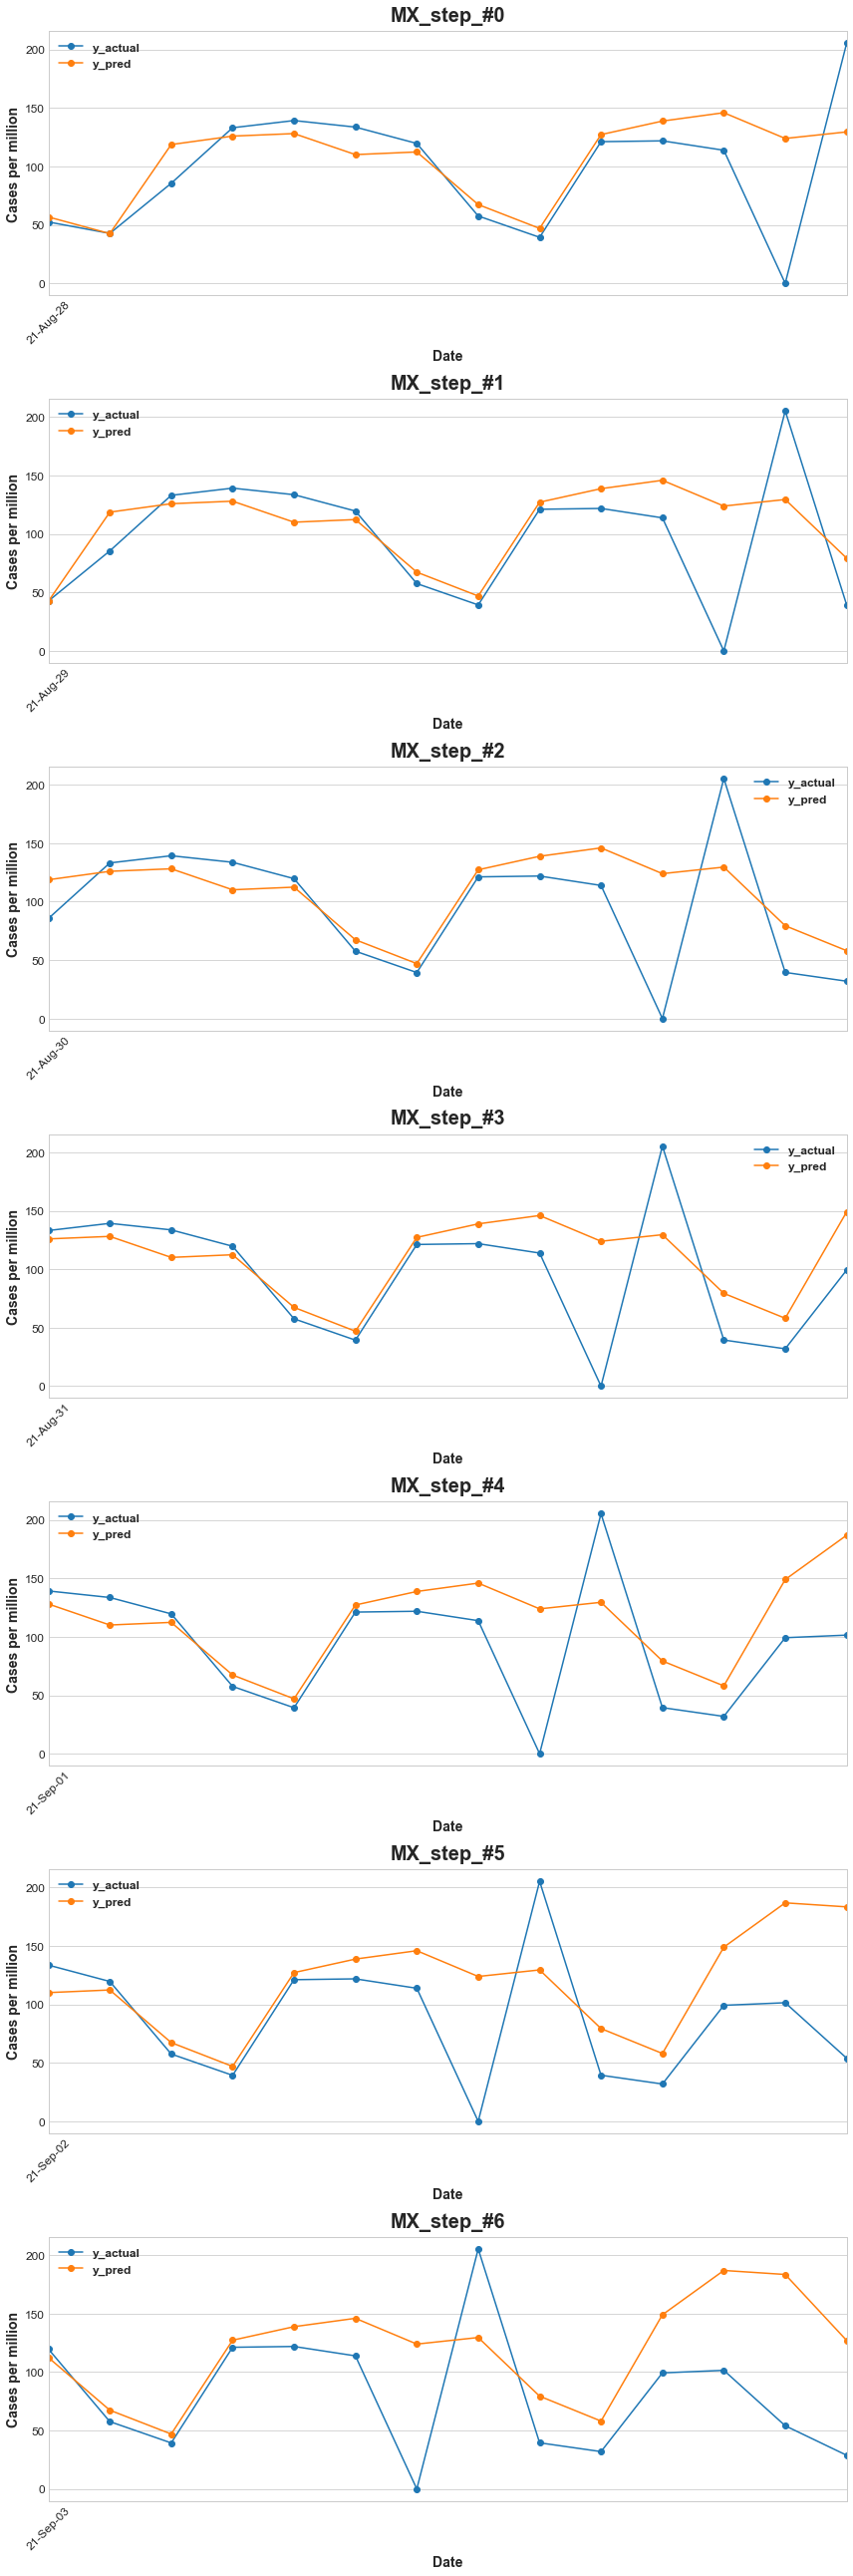

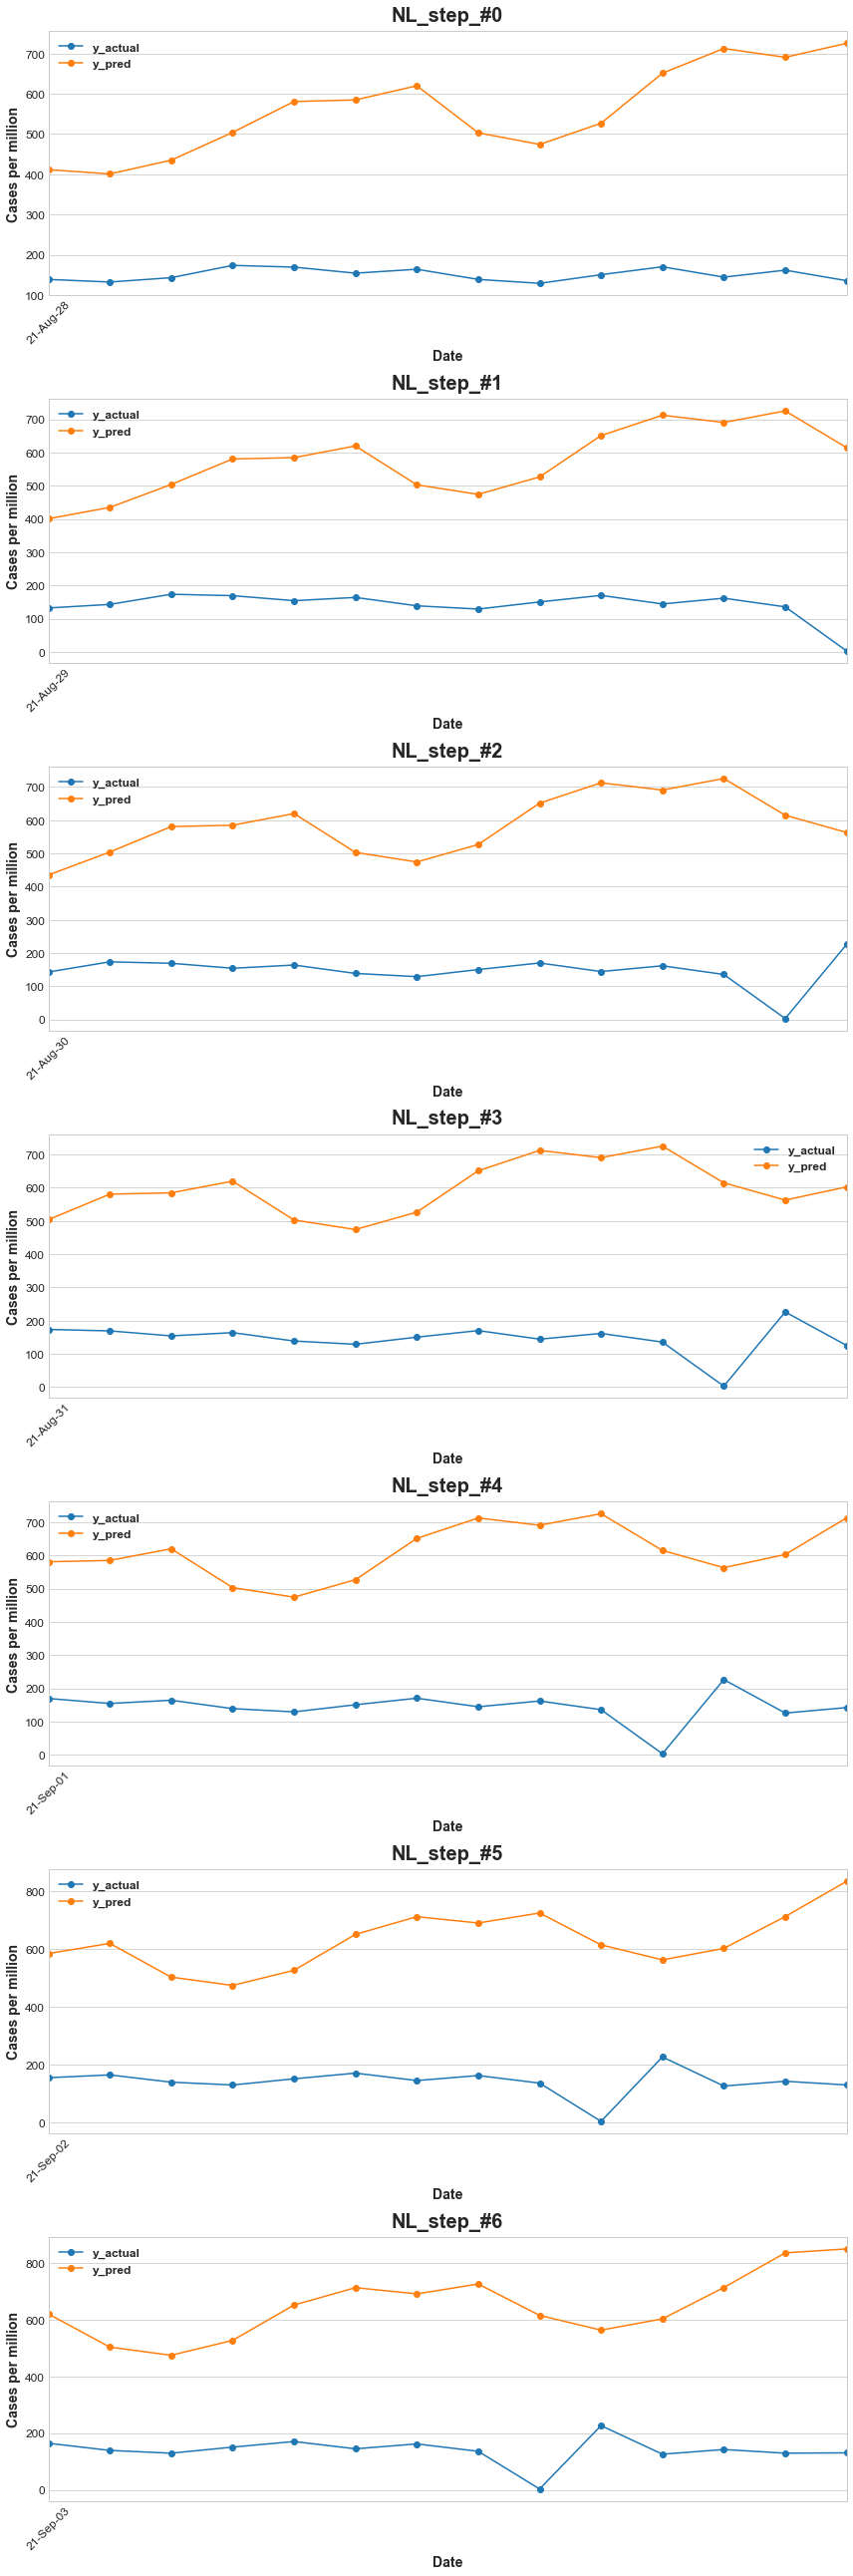

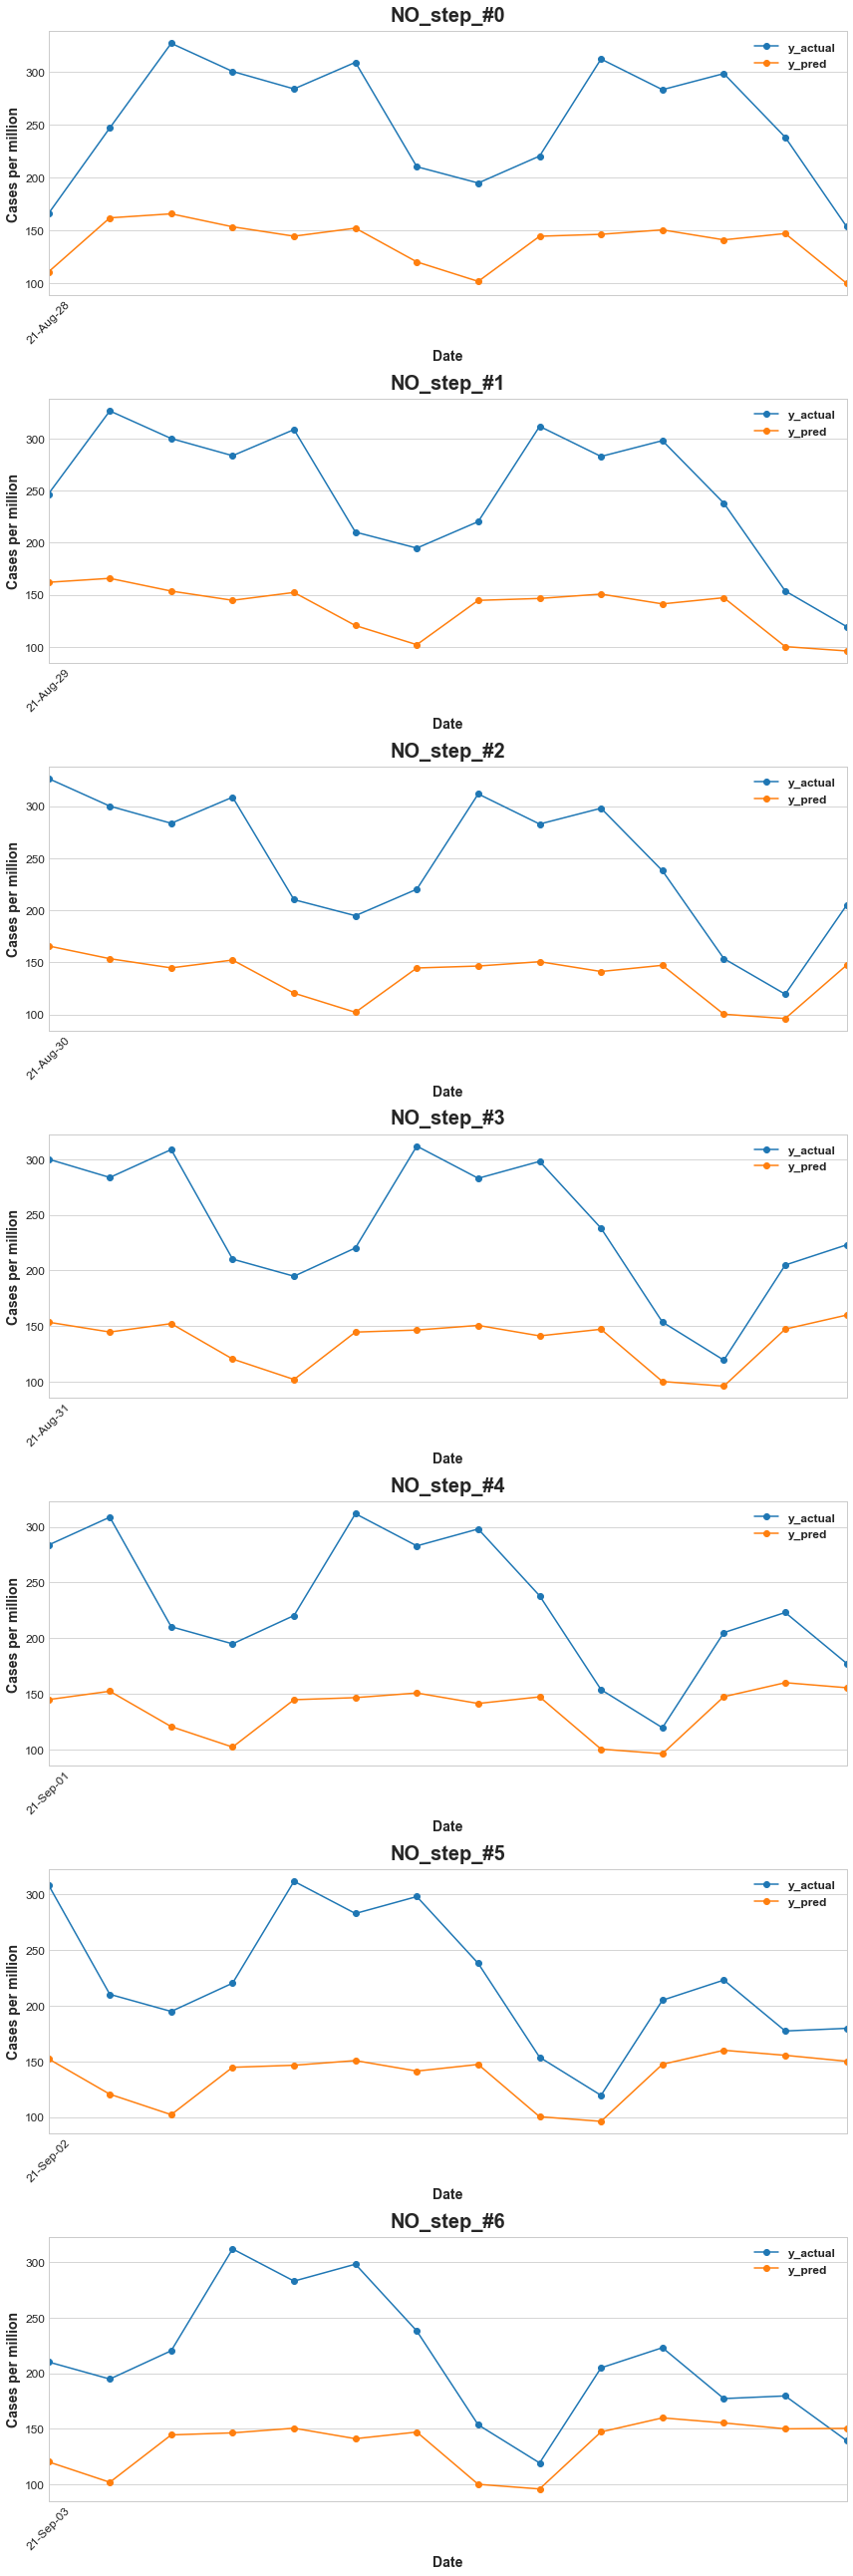

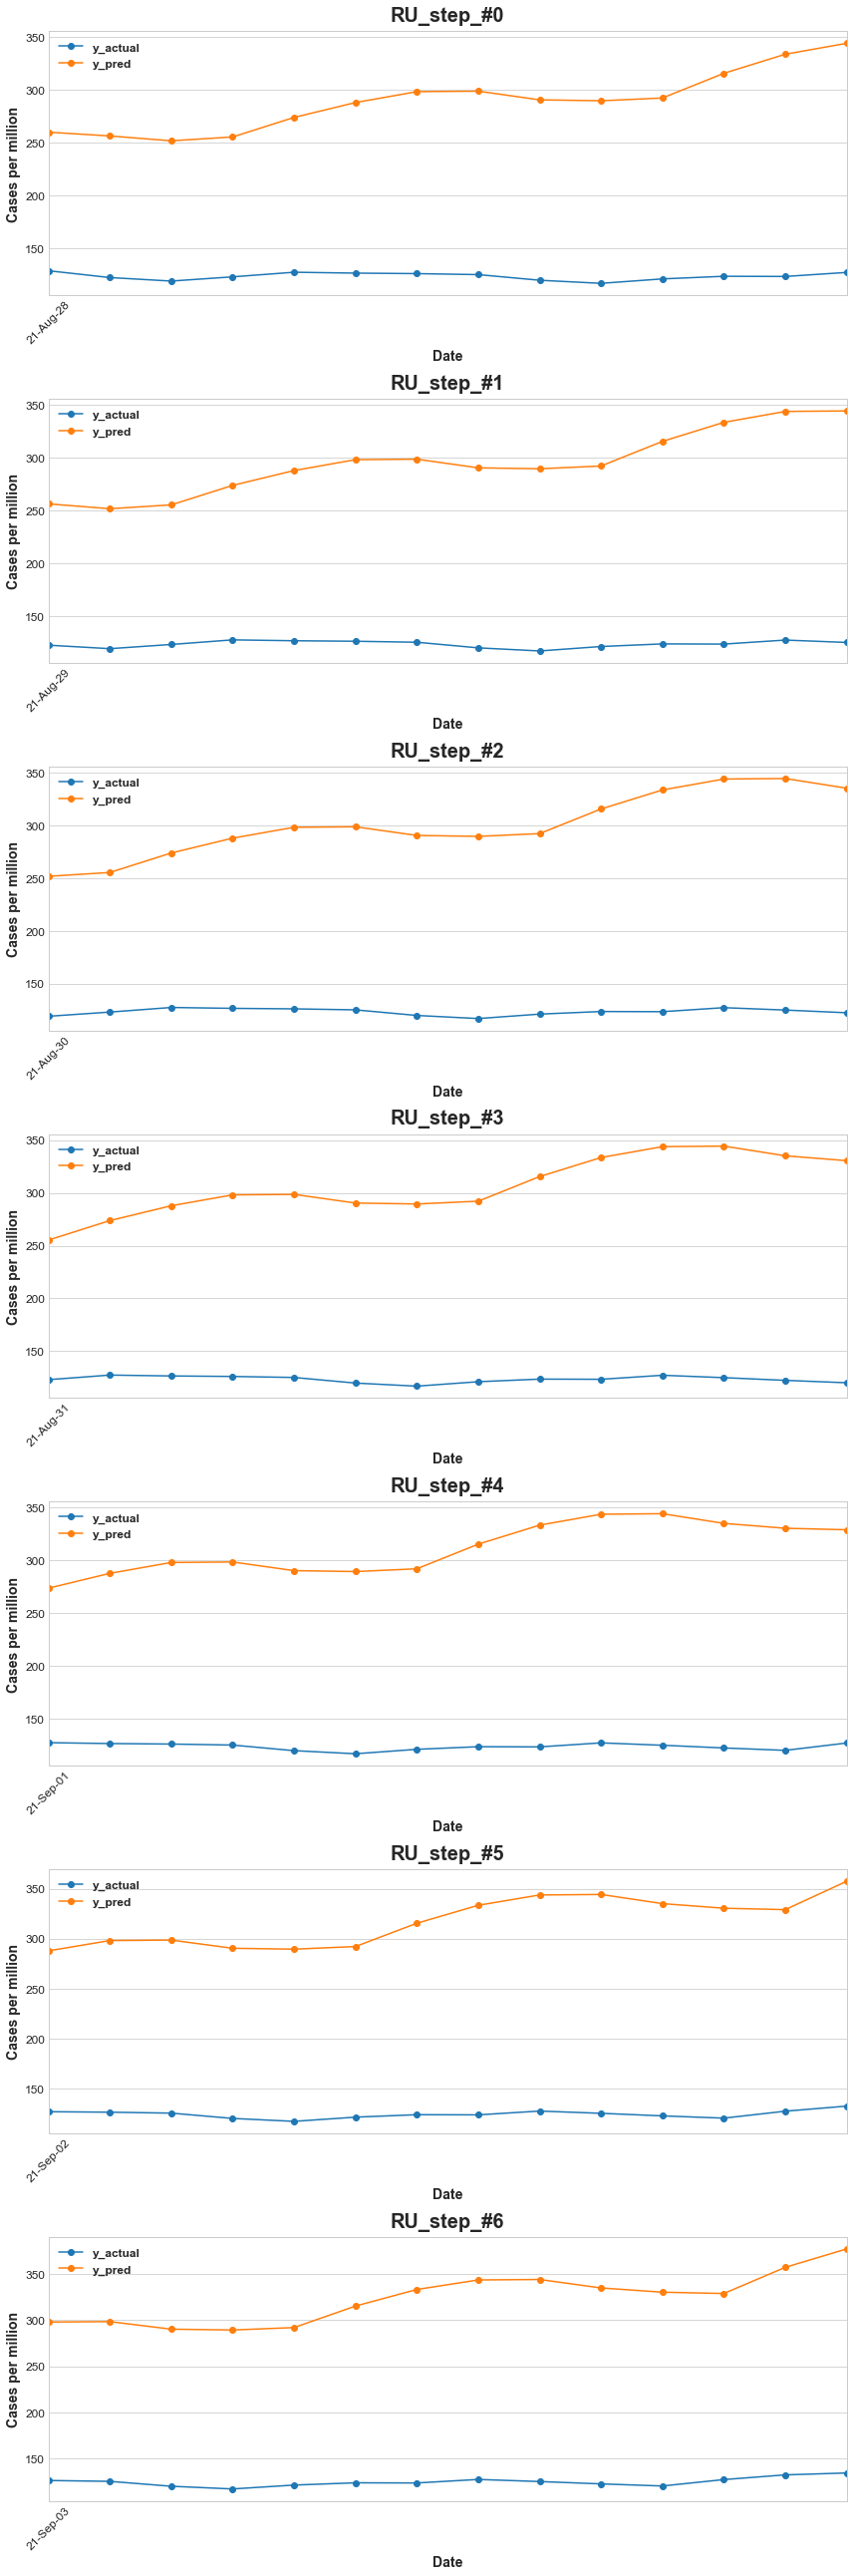

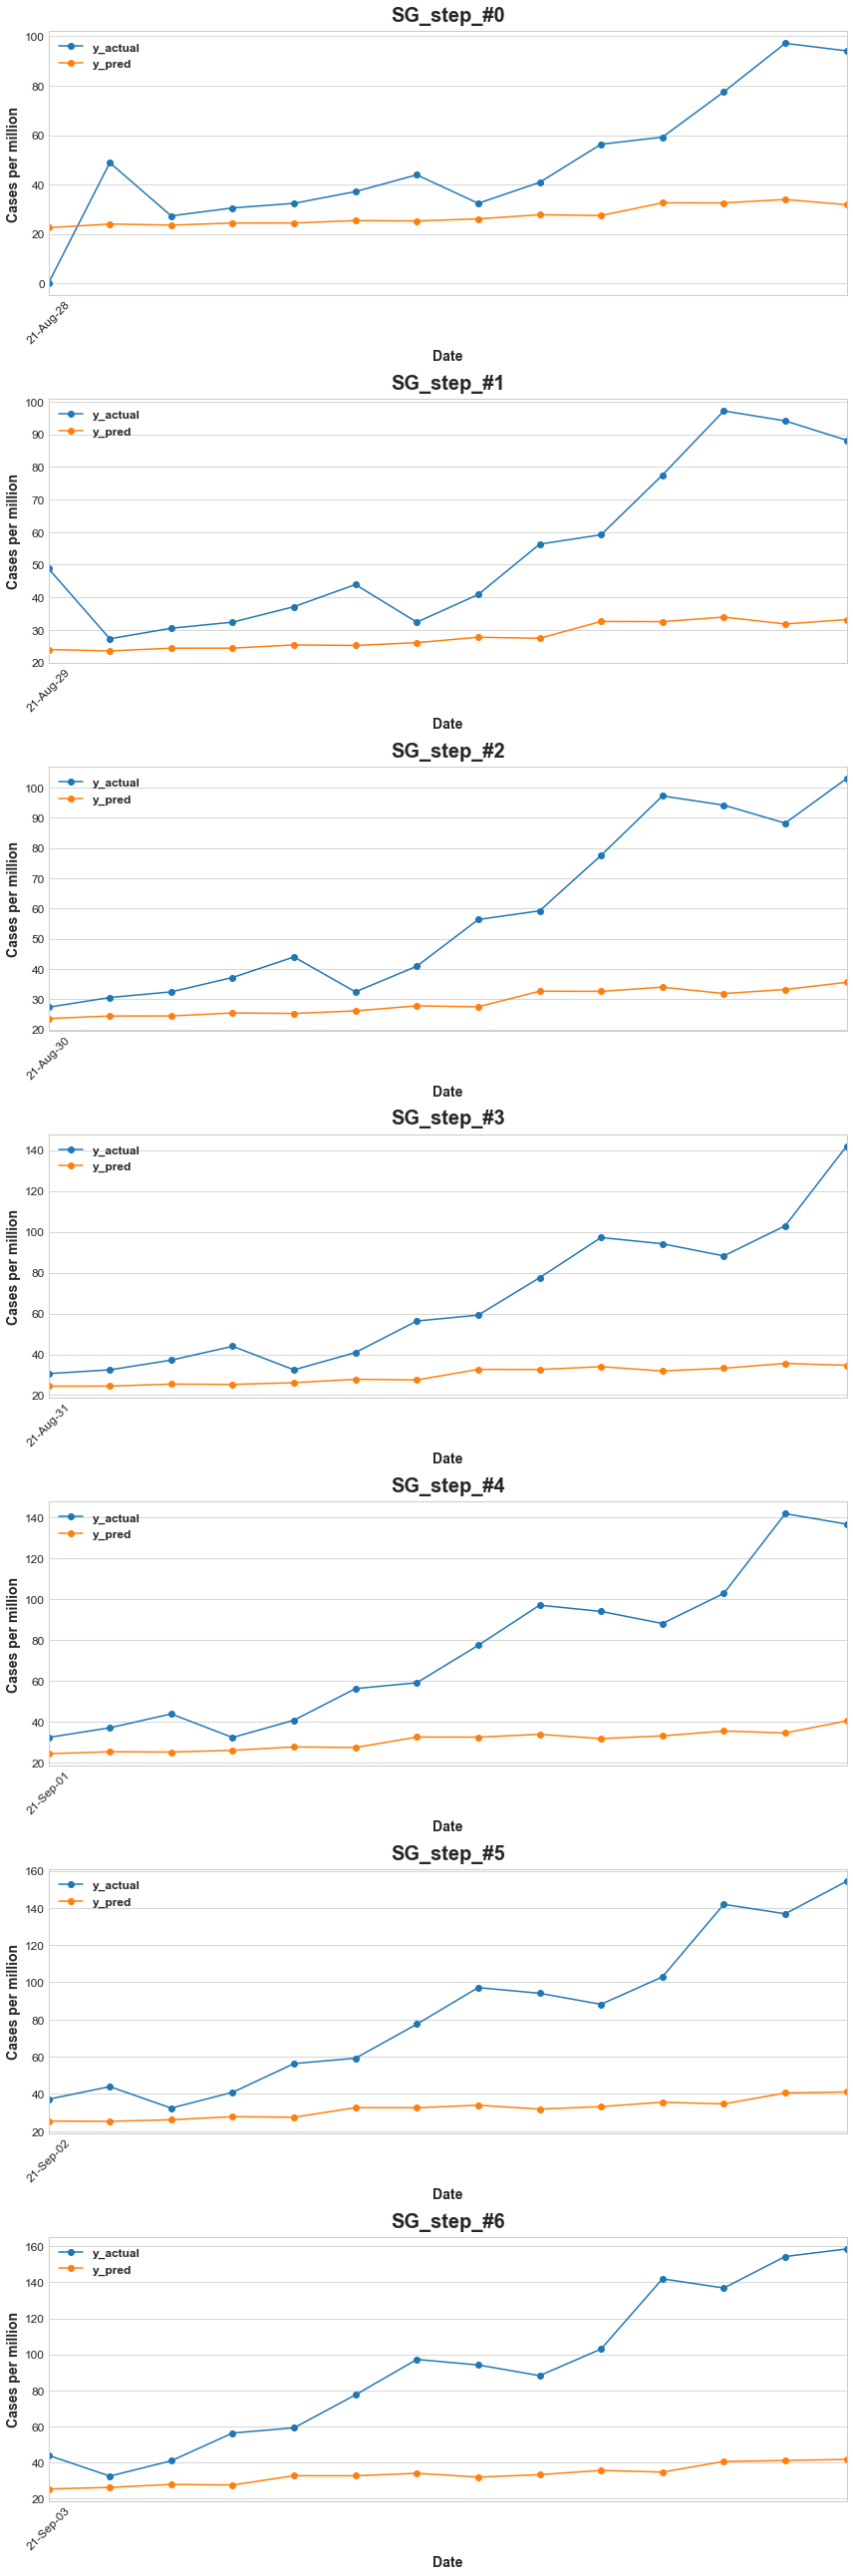

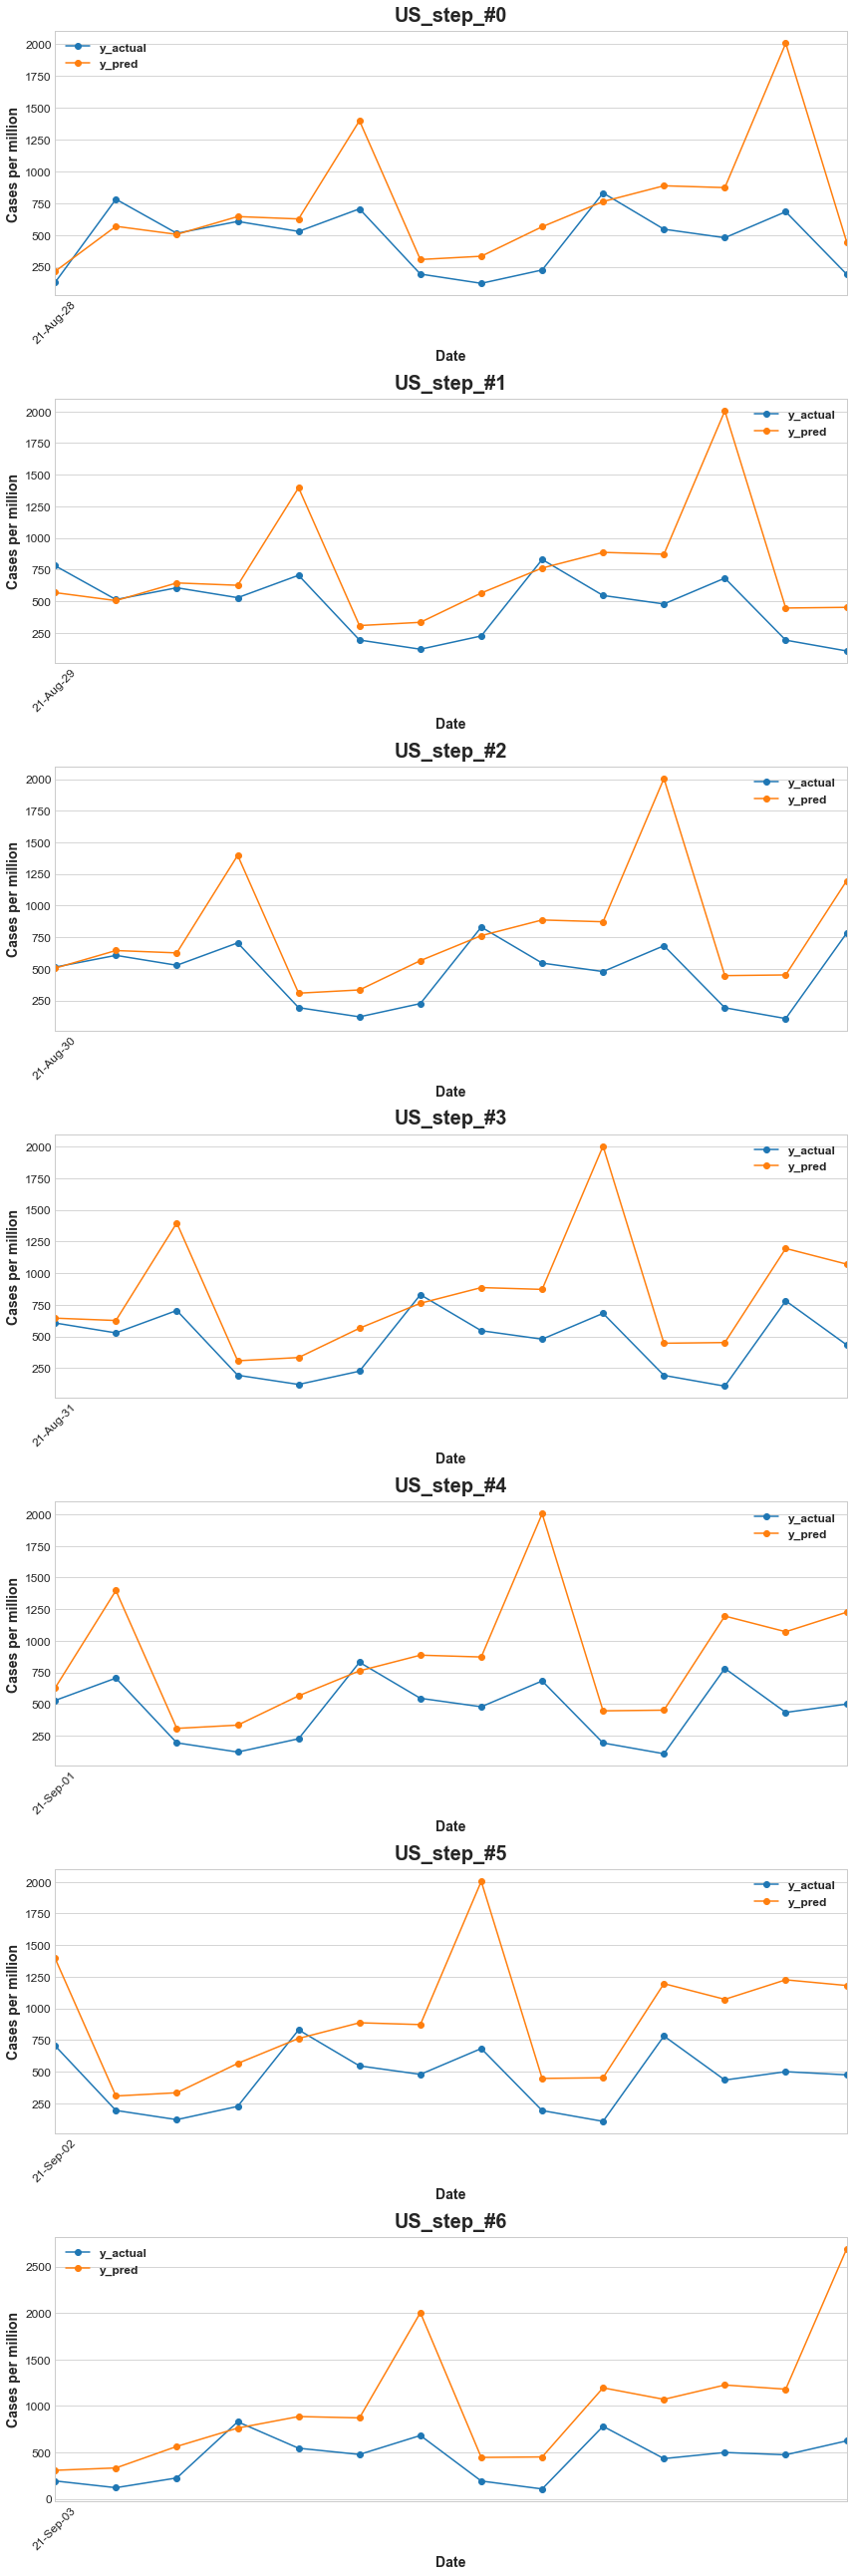

In [59]:
plot_actual_predicted(rez_country_srm_7d['test'], dict_country, 'test', n_steps_out=7)